In [1]:
import sys
import torch


'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '../data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/raw_data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR

True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


In [2]:
import polars as pl

target_dyn_demand_monthly = pl.read_parquet(DIR + 'target_dyn_demand_monthly.parquet')

In [3]:
from modeling_module.data_loader.MultiPartDataModule import MultiPartDataModule
from modeling_module.training.config import TrainingConfig


plan_yyyymm = 202101

train_cfg = TrainingConfig()
data_module = MultiPartDataModule(
    target_dyn_demand_monthly,
    train_cfg,
    batch_size = 64,
    val_ratio = 0.2,
    is_running = False
)

inference_loader = data_module.get_inference_loader_at_plan(
    plan_dt = plan_yyyymm
)

In [4]:
from modeling_module.utils.checkpoint import load_model_dict
from modeling_module.models.PatchTST.common.configs import PatchTSTConfigMonthly
from modeling_module.models.Titan.common.configs import TitanConfigMonthly
from modeling_module.models.PatchMixer.common.configs import PatchMixerConfigMonthly

save_dir = DIR + 'fit/l_24_h_6'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from modeling_module.models.model_builder import (
    build_patch_mixer_base, build_patch_mixer_quantile,
    build_titan_base, build_titan_lmm, build_titan_seq2seq,
    build_patchTST_base, build_patchTST_quantile,
)

# 1) config
pm_config = PatchMixerConfigMonthly(
    device=device, loss_mode='quantile', quantiles=(0.1, 0.5, 0.9)
)
ti_config = TitanConfigMonthly(
    device=device, loss_mode='point', point_loss='huber'
)
pt_config = PatchTSTConfigMonthly(
    device=device, loss_mode='auto', quantiles=(0.1, 0.5, 0.9)
)

# 2) builders: 인자 무시 + 외부 config 강제 주입 return Model
builders = {
    "patchmixer_base":    lambda *_ , **__: build_patch_mixer_base(pm_config),
    "patchmixer_quantile":lambda *_ , **__: build_patch_mixer_quantile(pm_config),
    "titan_base":         lambda *_ , **__: build_titan_base(ti_config),
    "titan_lmm":          lambda *_ , **__: build_titan_lmm(ti_config),
    "titan_seq2seq":      lambda *_ , **__: build_titan_seq2seq(ti_config),
    "patchtst_base":      lambda *_ , **__: build_patchTST_base(pt_config),
    "patchtst_quantile":  lambda *_ , **__: build_patchTST_quantile(pt_config),
}

loaded = load_model_dict(save_dir, builders, device=device)

# 3) (선택) 로드 결과 검증
for k, m in loaded.items():
    if hasattr(m, "configs"):
        print(k, m.configs.loss_mode, getattr(m.configs, "quantiles", None))
    m.eval()


[load] patchmixer_base ← C:/Users/USER/PycharmProjects/research/raw_data/fit/l_24_h_6\patchmixer_base.pt
[load] patchmixer_quantile ← C:/Users/USER/PycharmProjects/research/raw_data/fit/l_24_h_6\patchmixer_quantile.pt
[load] titan_base ← C:/Users/USER/PycharmProjects/research/raw_data/fit/l_24_h_6\titan_base.pt
[load] titan_lmm ← C:/Users/USER/PycharmProjects/research/raw_data/fit/l_24_h_6\titan_lmm.pt
[load] titan_seq2seq ← C:/Users/USER/PycharmProjects/research/raw_data/fit/l_24_h_6\titan_seq2seq.pt
[load] patchtst_base ← C:/Users/USER/PycharmProjects/research/raw_data/fit/l_24_h_6\patchtst_base.pt
[load] patchtst_quantile ← C:/Users/USER/PycharmProjects/research/raw_data/fit/l_24_h_6\patchtst_quantile.pt


In [5]:
from modeling_module.utils.date_util import DateUtil
import numpy as np
from modeling_module.utils.exogenous_utils import calendar_cb
%load_ext autoreload
%autoreload 2

import importlib
import modeling_module.utils.plot_utils as plot_utils
importlib.reload(plot_utils)   # 선택: 확실히 새 코드로

def make_truth_cb_monthly(target_df: pl.DataFrame):
    def truth_cb(part_id: str, plan_dt: int, H: int, granularity: str = "month"):
        assert granularity == "month"
        months = [DateUtil.add_months_yyyymm(plan_dt, k) for k in range(H)]  # plan 포함
        sub = (target_df
               .filter((pl.col('oper_part_no') == part_id) & (pl.col('demand_dt').is_in(months)))
               .select(['demand_dt', 'demand_qty'])
               .sort('demand_dt'))
        mp = {int(m): float(v) for m, v in zip(sub['demand_dt'].to_numpy(), sub['demand_qty'].to_numpy())}
        out = [mp.get(m, np.nan) for m in months]
        return np.asarray(out, dtype=float)
    return truth_cb

truth_cb = make_truth_cb_monthly(target_dyn_demand_monthly)

C:\Users\USER\python\py312\Lib\site-packages\torch\nn\modules\conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv1d(


model PatchMixer QuantileModel [DBG] t 0 q10: -0.24688434600830078 q50: 4.170114040374756 q90: 13.637401580810547
model PatchMixer QuantileModel [DBG] t 1 q10: -2.0456390380859375 q50: 2.9250106811523438 q90: 10.400739669799805
model PatchMixer QuantileModel [DBG] t 2 q10: 1.4173378944396973 q50: 4.104735851287842 q90: 8.180604934692383
model PatchMixer QuantileModel [DBG] t 3 q10: 1.7204031944274902 q50: 3.739175319671631 q90: 9.260050773620605
model PatchMixer QuantileModel [DBG] t 4 q10: 1.8834457397460938 q50: 3.7131733894348145 q90: 8.040515899658203
model PatchTST QuantileModel [DBG] t 0 q10: 4.474097728729248 q50: 9.28483772277832 q90: 17.708663940429688
model PatchTST QuantileModel [DBG] t 1 q10: 6.023477554321289 q50: 7.129288673400879 q90: 16.61443328857422
model PatchTST QuantileModel [DBG] t 2 q10: 5.594308376312256 q50: 11.13283920288086 q90: 16.324268341064453
model PatchTST QuantileModel [DBG] t 3 q10: 6.189651966094971 q50: 7.327880859375 q90: 13.848974227905273
model P

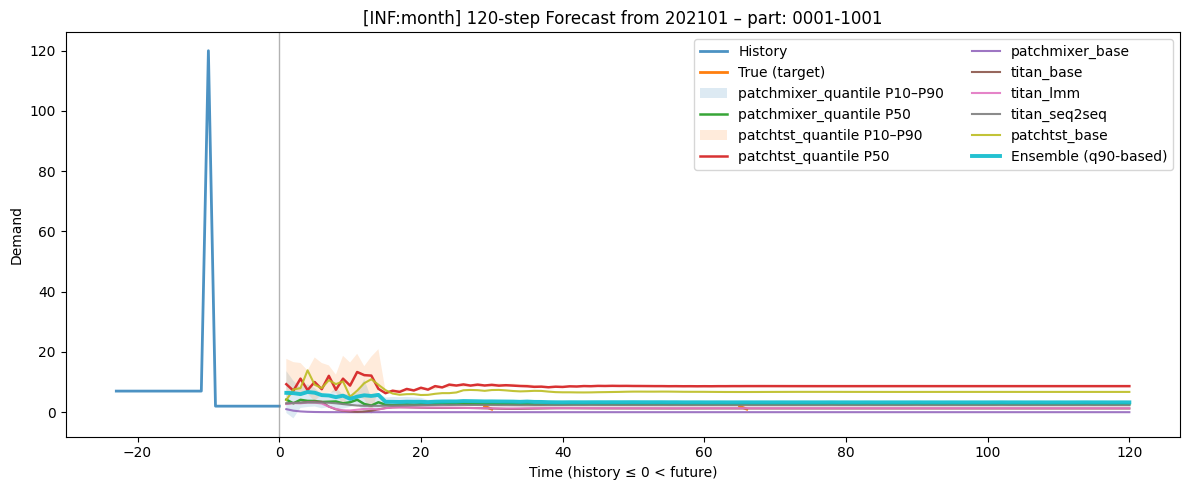

model PatchMixer QuantileModel [DBG] t 0 q10: 0.9906261563301086 q50: 1.005069375038147 q90: 1.0268772840499878
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9994215369224548 q50: 0.9995700716972351 q90: 0.9996503591537476
model PatchMixer QuantileModel [DBG] t 2 q10: 0.9993498921394348 q50: 0.9994750022888184 q90: 0.9998481869697571
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9993153810501099 q50: 0.999517560005188 q90: 0.9996435642242432
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9993610382080078 q50: 0.9995560646057129 q90: 1.0000532865524292
model PatchTST QuantileModel [DBG] t 0 q10: 1.0081284046173096 q50: 1.010634422302246 q90: 1.1315332651138306
model PatchTST QuantileModel [DBG] t 1 q10: 0.9997022747993469 q50: 0.9999669194221497 q90: 1.0017908811569214
model PatchTST QuantileModel [DBG] t 2 q10: 0.9995759129524231 q50: 1.0001952648162842 q90: 1.0018435716629028
model PatchTST QuantileModel [DBG] t 3 q10: 0.9994648694992065 q50: 0.999803364276886 q90: 1.001932263374

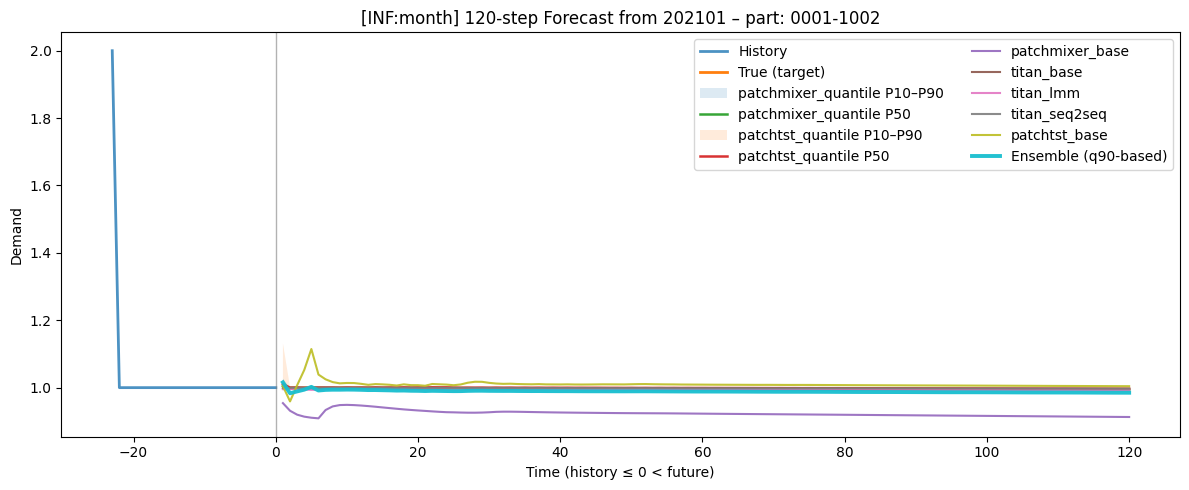

model PatchMixer QuantileModel [DBG] t 0 q10: 2.605804920196533 q50: 4.1496901512146 q90: 10.004940032958984
model PatchMixer QuantileModel [DBG] t 1 q10: 2.985408067703247 q50: 4.140064239501953 q90: 8.847285270690918
model PatchMixer QuantileModel [DBG] t 2 q10: 3.4303791522979736 q50: 4.581076145172119 q90: 8.840665817260742
model PatchMixer QuantileModel [DBG] t 3 q10: 3.9951682090759277 q50: 4.775739669799805 q90: 8.52781867980957
model PatchMixer QuantileModel [DBG] t 4 q10: 4.309814453125 q50: 4.987213134765625 q90: 8.05063247680664
model PatchTST QuantileModel [DBG] t 0 q10: 4.911393642425537 q50: 5.236290454864502 q90: 5.539968490600586
model PatchTST QuantileModel [DBG] t 1 q10: 5.01991605758667 q50: 5.199176788330078 q90: 5.6058855056762695
model PatchTST QuantileModel [DBG] t 2 q10: 5.173323154449463 q50: 5.474844455718994 q90: 5.776805400848389
model PatchTST QuantileModel [DBG] t 3 q10: 5.544634819030762 q50: 5.651930332183838 q90: 5.8313093185424805
model PatchTST Quanti

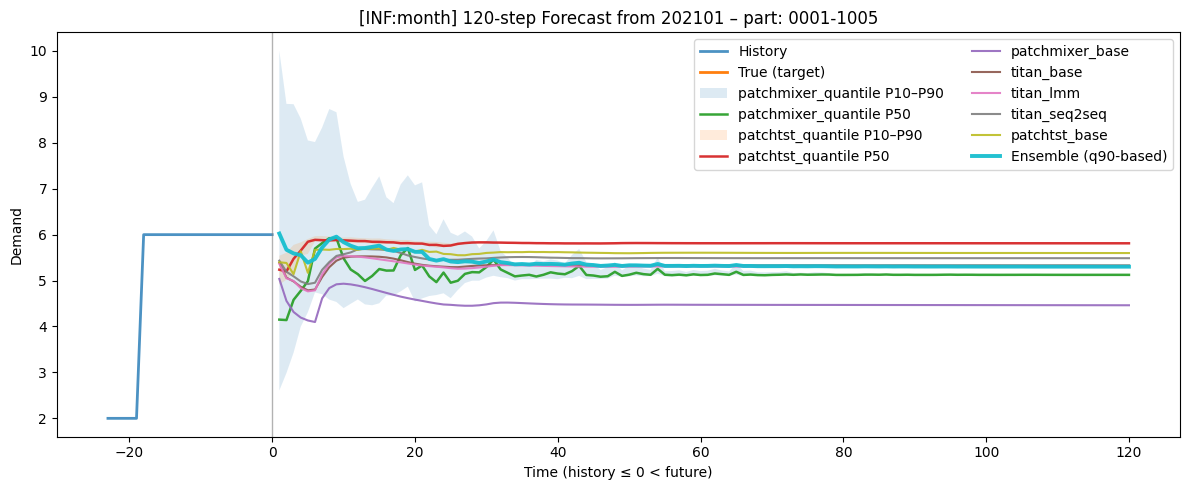

model PatchMixer QuantileModel [DBG] t 0 q10: 0.9992461204528809 q50: 0.9994205832481384 q90: 0.9997384548187256
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9992043972015381 q50: 0.9993777871131897 q90: 0.9997034668922424
model PatchMixer QuantileModel [DBG] t 2 q10: 0.9991669654846191 q50: 0.9993583559989929 q90: 0.9997172355651855
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9991217851638794 q50: 0.999293327331543 q90: 0.9997464418411255
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9990863800048828 q50: 0.9992753863334656 q90: 0.9996991753578186
model PatchTST QuantileModel [DBG] t 0 q10: 0.9991579651832581 q50: 0.9995782375335693 q90: 1.0014750957489014
model PatchTST QuantileModel [DBG] t 1 q10: 0.9991275072097778 q50: 0.9995693564414978 q90: 1.0014744997024536
model PatchTST QuantileModel [DBG] t 2 q10: 0.9991117119789124 q50: 0.9995369911193848 q90: 1.0014644861221313
model PatchTST QuantileModel [DBG] t 3 q10: 0.9991029500961304 q50: 0.9995430111885071 q90: 1.001441478

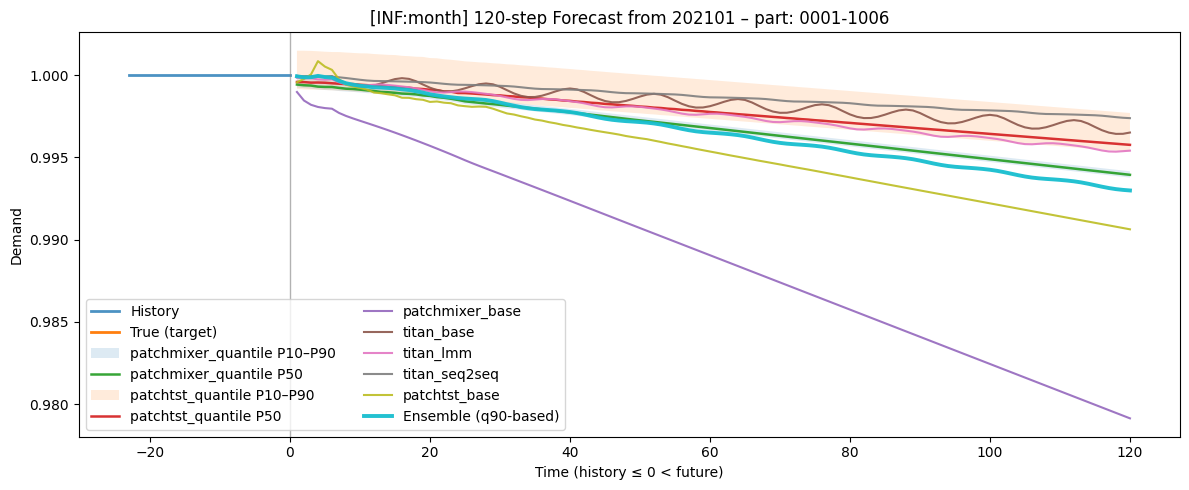

model PatchMixer QuantileModel [DBG] t 0 q10: 9.999246597290039 q50: 9.999420166015625 q90: 9.999738693237305
model PatchMixer QuantileModel [DBG] t 1 q10: 9.999204635620117 q50: 9.999378204345703 q90: 9.999703407287598
model PatchMixer QuantileModel [DBG] t 2 q10: 9.999167442321777 q50: 9.999359130859375 q90: 9.999717712402344
model PatchMixer QuantileModel [DBG] t 3 q10: 9.999122619628906 q50: 9.99929428100586 q90: 9.999746322631836
model PatchMixer QuantileModel [DBG] t 4 q10: 9.9990873336792 q50: 9.999276161193848 q90: 9.999698638916016
model PatchTST QuantileModel [DBG] t 0 q10: 9.999157905578613 q50: 9.999578475952148 q90: 10.00147533416748
model PatchTST QuantileModel [DBG] t 1 q10: 9.999128341674805 q50: 9.9995698928833 q90: 10.001474380493164
model PatchTST QuantileModel [DBG] t 2 q10: 9.999112129211426 q50: 9.999537467956543 q90: 10.00146484375
model PatchTST QuantileModel [DBG] t 3 q10: 9.999103546142578 q50: 9.999543190002441 q90: 10.001441955566406
model PatchTST QuantileM

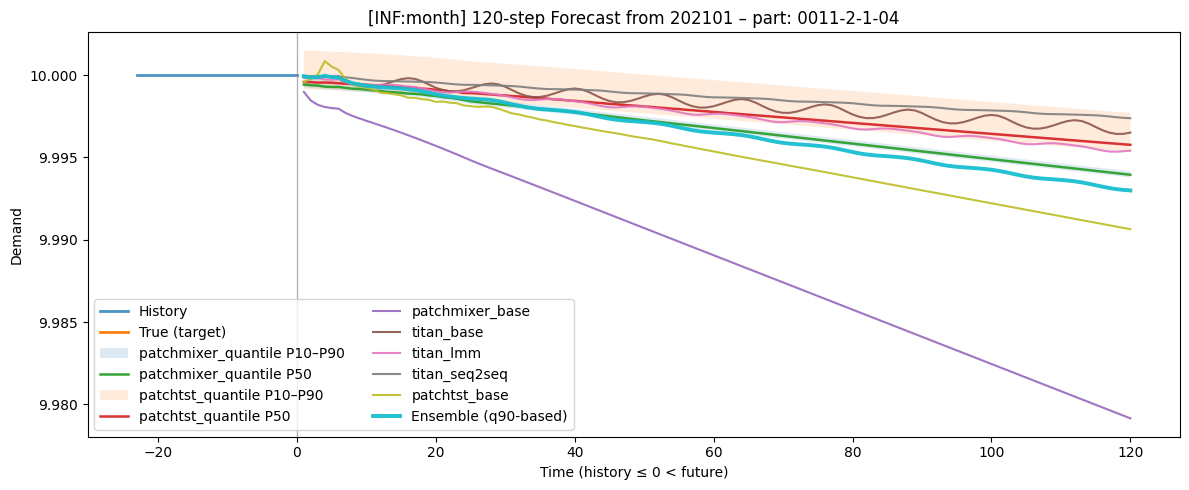

model PatchMixer QuantileModel [DBG] t 0 q10: 9.999246597290039 q50: 9.999420166015625 q90: 9.999738693237305
model PatchMixer QuantileModel [DBG] t 1 q10: 9.999204635620117 q50: 9.999378204345703 q90: 9.999703407287598
model PatchMixer QuantileModel [DBG] t 2 q10: 9.999167442321777 q50: 9.999359130859375 q90: 9.999717712402344
model PatchMixer QuantileModel [DBG] t 3 q10: 9.999122619628906 q50: 9.99929428100586 q90: 9.999746322631836
model PatchMixer QuantileModel [DBG] t 4 q10: 9.9990873336792 q50: 9.999276161193848 q90: 9.999698638916016
model PatchTST QuantileModel [DBG] t 0 q10: 9.999157905578613 q50: 9.999578475952148 q90: 10.00147533416748
model PatchTST QuantileModel [DBG] t 1 q10: 9.999128341674805 q50: 9.9995698928833 q90: 10.001474380493164
model PatchTST QuantileModel [DBG] t 2 q10: 9.999112129211426 q50: 9.999537467956543 q90: 10.00146484375
model PatchTST QuantileModel [DBG] t 3 q10: 9.999103546142578 q50: 9.999543190002441 q90: 10.001441955566406
model PatchTST QuantileM

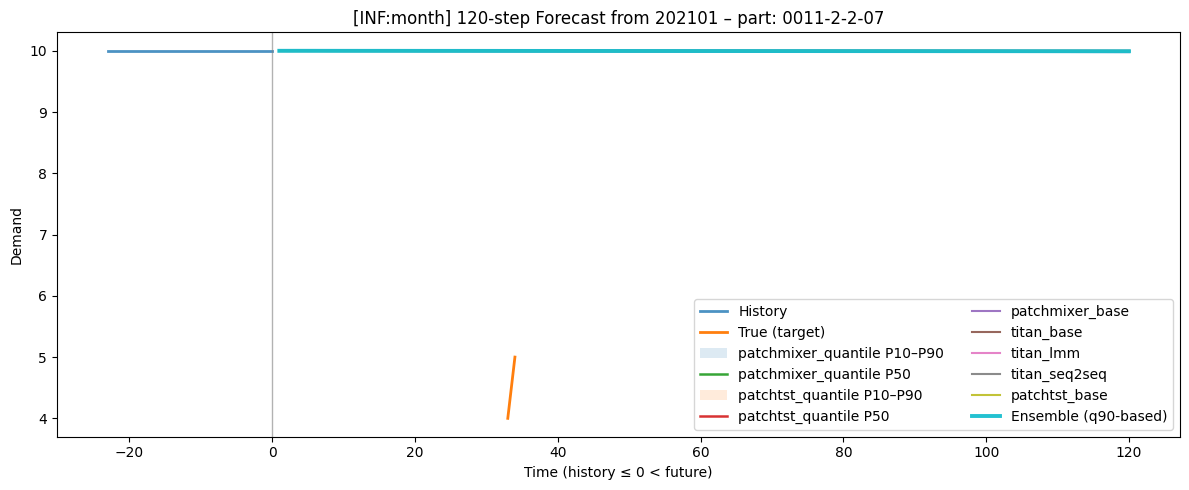

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

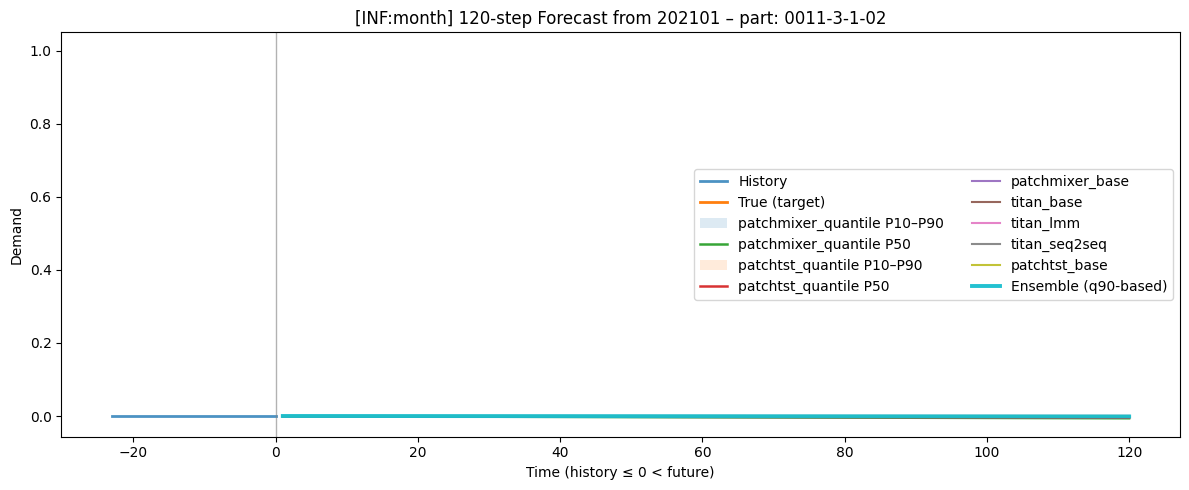

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

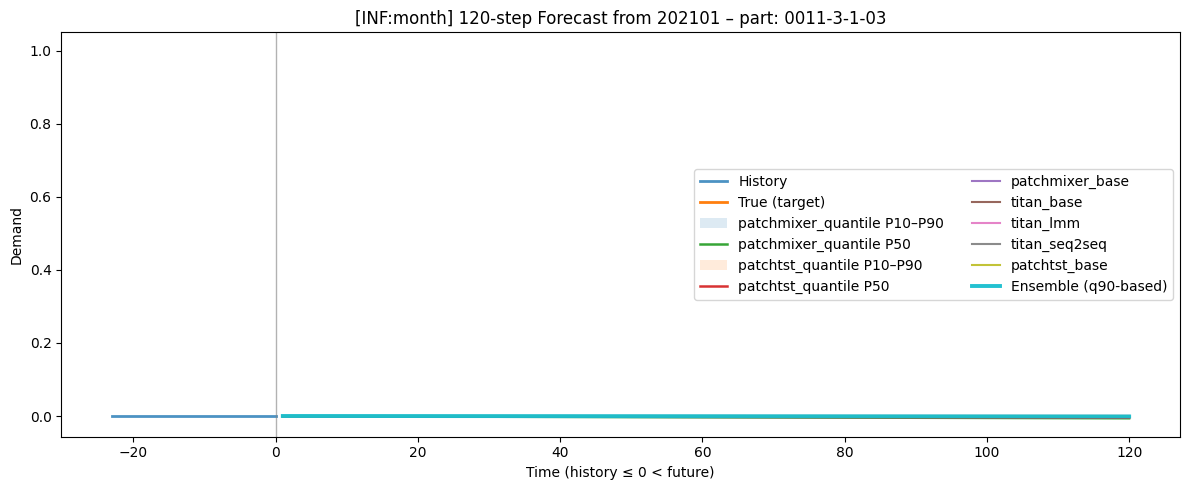

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

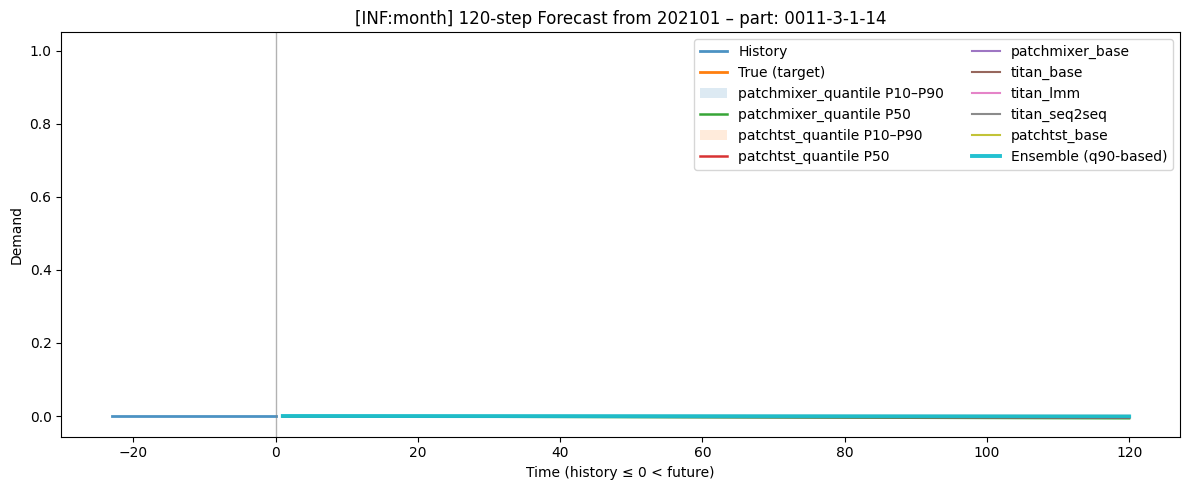

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

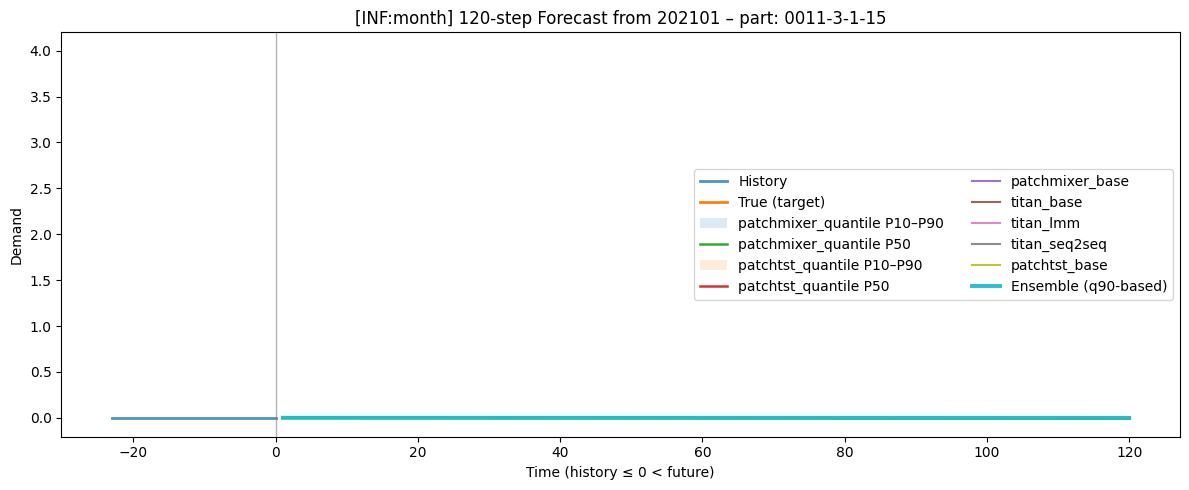

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

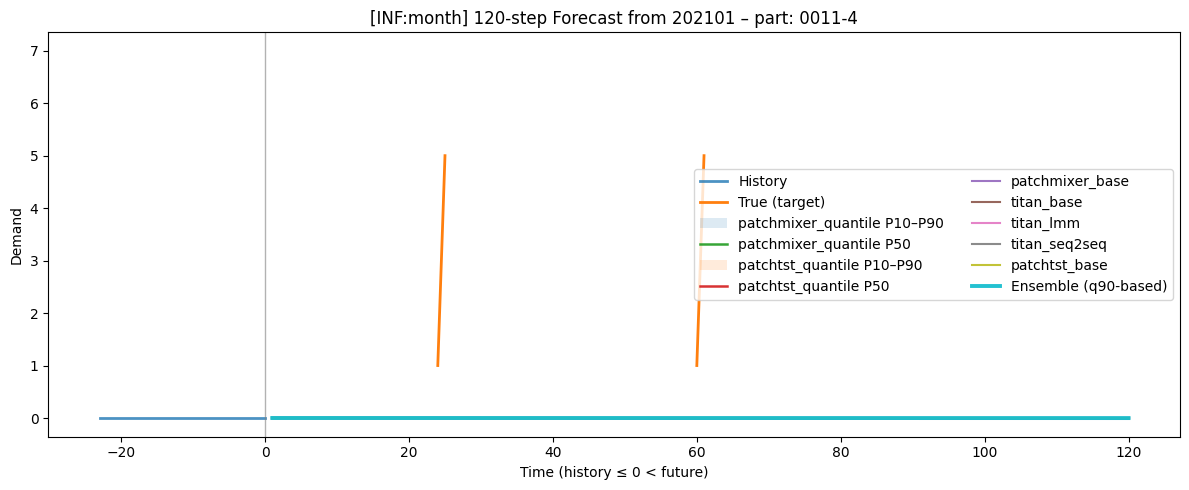

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

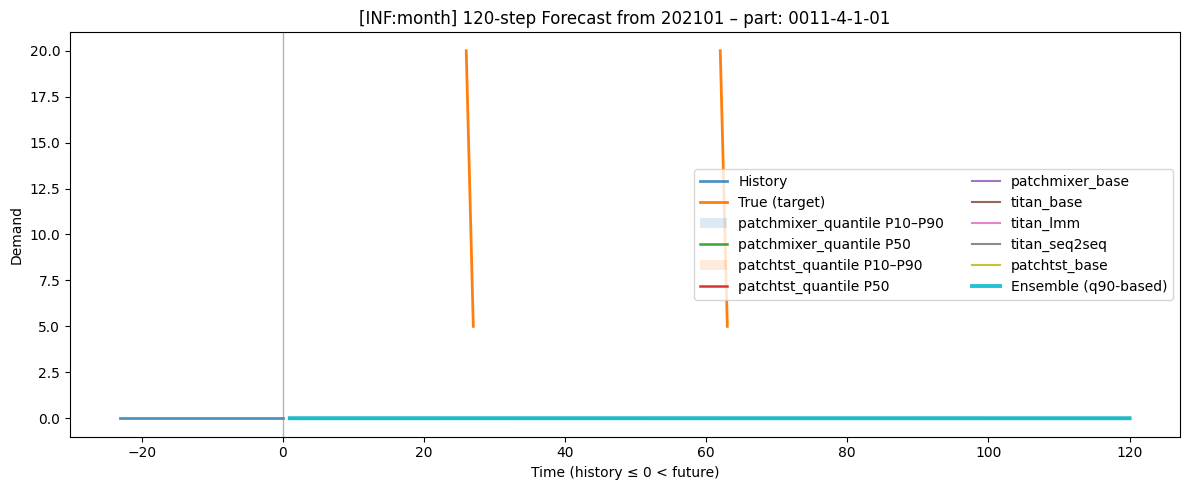

model PatchMixer QuantileModel [DBG] t 0 q10: 0.03566598892211914 q50: 0.47143563628196716 q90: 1.9166314601898193
model PatchMixer QuantileModel [DBG] t 1 q10: 0.12796133756637573 q50: 0.4704219102859497 q90: 1.9161615371704102
model PatchMixer QuantileModel [DBG] t 2 q10: 0.2046988606452942 q50: 0.546414852142334 q90: 1.7661666870117188
model PatchMixer QuantileModel [DBG] t 3 q10: 0.36731240153312683 q50: 0.6063690185546875 q90: 1.726248025894165
model PatchMixer QuantileModel [DBG] t 4 q10: 0.42375659942626953 q50: 0.6615111231803894 q90: 1.7064173221588135
model PatchTST QuantileModel [DBG] t 0 q10: 0.7199116349220276 q50: 0.7684913277626038 q90: 0.8087475299835205
model PatchTST QuantileModel [DBG] t 1 q10: 0.7104872465133667 q50: 0.7999349236488342 q90: 0.8808921575546265
model PatchTST QuantileModel [DBG] t 2 q10: 0.7479930520057678 q50: 0.7862155437469482 q90: 0.8946166634559631
model PatchTST QuantileModel [DBG] t 3 q10: 0.7866971492767334 q50: 0.867431104183197 q90: 0.930588

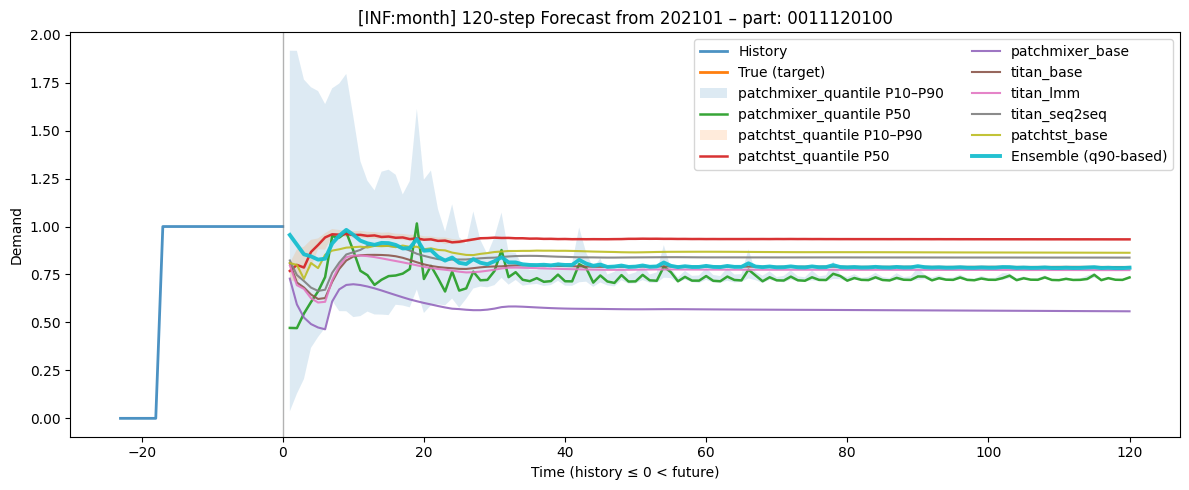

model PatchMixer QuantileModel [DBG] t 0 q10: -0.24278908967971802 q50: 0.3732140362262726 q90: 2.269195556640625
model PatchMixer QuantileModel [DBG] t 1 q10: -0.11899054050445557 q50: 0.34362921118736267 q90: 2.030588388442993
model PatchMixer QuantileModel [DBG] t 2 q10: 0.031561195850372314 q50: 0.4478823244571686 q90: 1.989528775215149
model PatchMixer QuantileModel [DBG] t 3 q10: 0.11598771810531616 q50: 0.4790460467338562 q90: 2.0399651527404785
model PatchMixer QuantileModel [DBG] t 4 q10: 0.14707785844802856 q50: 0.509397029876709 q90: 1.8194212913513184
model PatchTST QuantileModel [DBG] t 0 q10: 0.6217294931411743 q50: 0.655947208404541 q90: 0.7535419464111328
model PatchTST QuantileModel [DBG] t 1 q10: 0.6488963961601257 q50: 0.7256593704223633 q90: 0.7766702771186829
model PatchTST QuantileModel [DBG] t 2 q10: 0.6868671178817749 q50: 0.741266131401062 q90: 0.7933422327041626
model PatchTST QuantileModel [DBG] t 3 q10: 0.6916507482528687 q50: 0.7830620408058167 q90: 0.85038

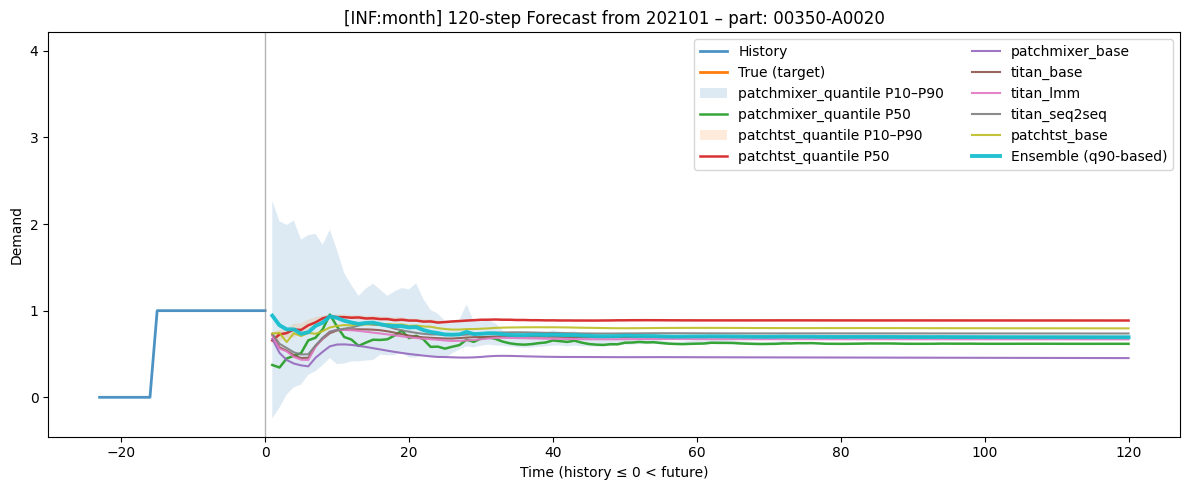

model PatchMixer QuantileModel [DBG] t 0 q10: 0.9799184799194336 q50: 1.0607048273086548 q90: 1.2387323379516602
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9188815355300903 q50: 1.0456058979034424 q90: 1.222267746925354
model PatchMixer QuantileModel [DBG] t 2 q10: 0.9767060875892639 q50: 1.0435956716537476 q90: 1.202858328819275
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9807794094085693 q50: 1.0354034900665283 q90: 1.1251603364944458
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9146543145179749 q50: 1.0184768438339233 q90: 1.2160760164260864
model PatchTST QuantileModel [DBG] t 0 q10: 1.2515677213668823 q50: 1.2878551483154297 q90: 1.6901211738586426
model PatchTST QuantileModel [DBG] t 1 q10: 1.1062523126602173 q50: 1.1695014238357544 q90: 1.4840022325515747
model PatchTST QuantileModel [DBG] t 2 q10: 1.100907802581787 q50: 1.1515346765518188 q90: 1.511725902557373
model PatchTST QuantileModel [DBG] t 3 q10: 1.146307349205017 q50: 1.2430018186569214 q90: 1.4923177957534

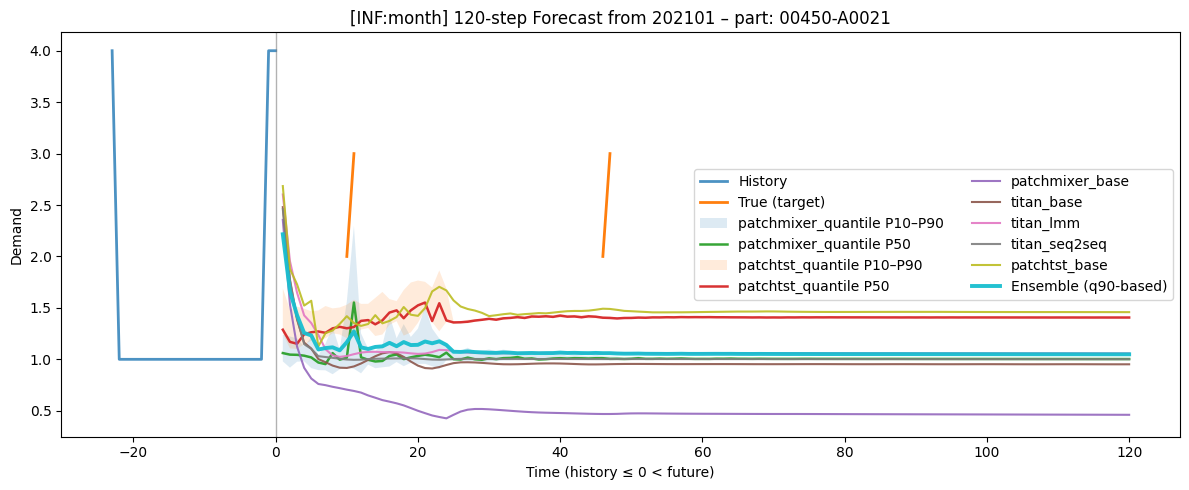

model PatchMixer QuantileModel [DBG] t 0 q10: 0.7368108630180359 q50: 0.8328701257705688 q90: 1.3095475435256958
model PatchMixer QuantileModel [DBG] t 1 q10: 0.961442232131958 q50: 0.991889476776123 q90: 1.041400671005249
model PatchMixer QuantileModel [DBG] t 2 q10: 0.964172899723053 q50: 0.9820100665092468 q90: 1.036325454711914
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9549153447151184 q50: 0.9806413054466248 q90: 1.0614670515060425
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9554738998413086 q50: 0.9771928191184998 q90: 1.0412745475769043
model PatchTST QuantileModel [DBG] t 0 q10: 0.9133175611495972 q50: 0.9808249473571777 q90: 1.0085620880126953
model PatchTST QuantileModel [DBG] t 1 q10: 0.9978475570678711 q50: 0.9988914728164673 q90: 1.0015287399291992
model PatchTST QuantileModel [DBG] t 2 q10: 0.9980846047401428 q50: 0.9985242486000061 q90: 1.001286268234253
model PatchTST QuantileModel [DBG] t 3 q10: 0.998137354850769 q50: 0.9989935755729675 q90: 1.001011610031128

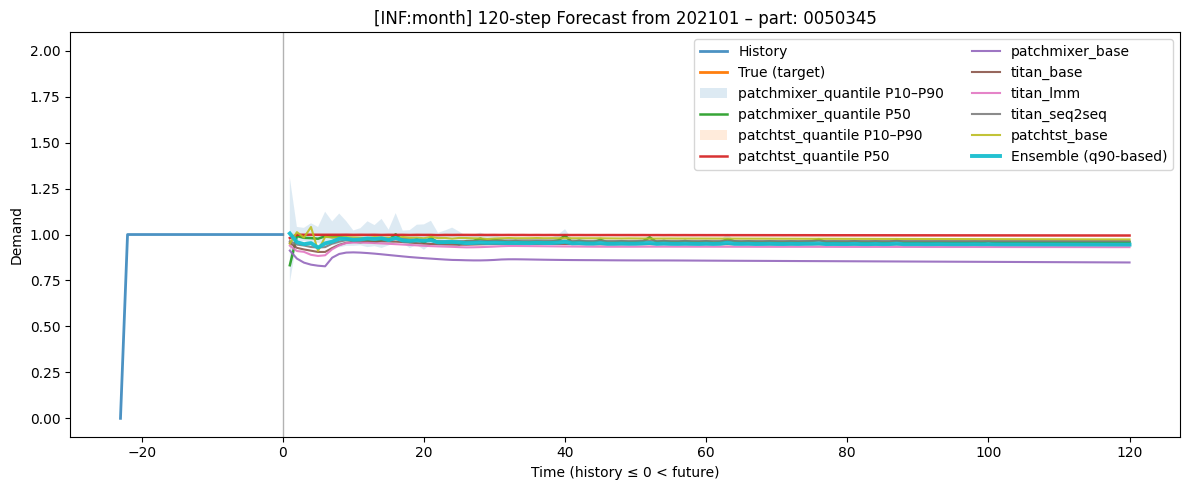

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

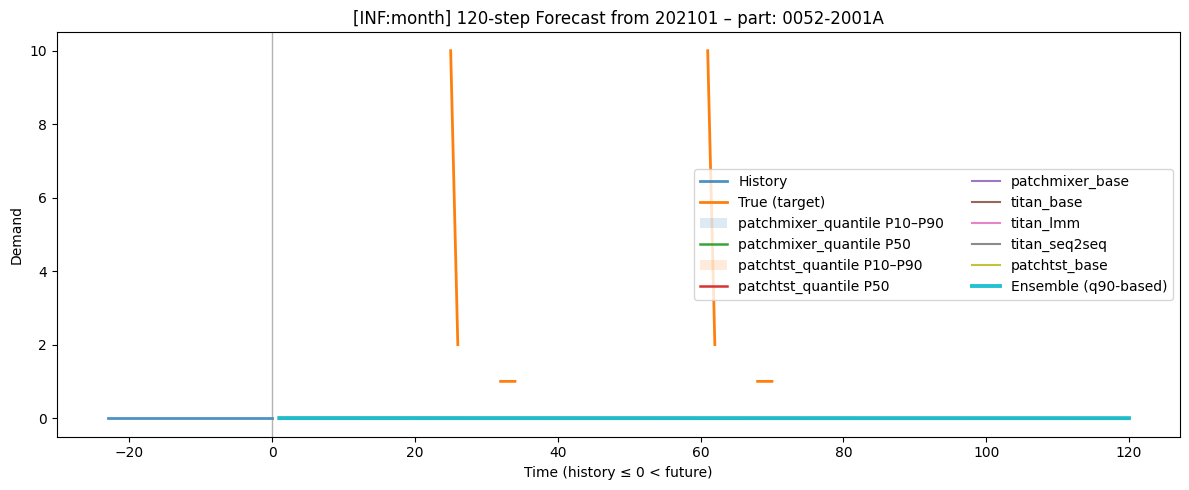

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0060443878173828125 q50: 0.018141746520996094 q90: 0.046512991189956665
model PatchMixer QuantileModel [DBG] t 1 q10: -0.05425158143043518 q50: 0.03171995282173157 q90: 0.14861160516738892
model PatchMixer QuantileModel [DBG] t 2 q10: -0.01592673361301422 q50: 0.02813751995563507 q90: 0.13284213840961456
model PatchMixer QuantileModel [DBG] t 3 q10: -0.013086915016174316 q50: 0.022814929485321045 q90: 0.08152809739112854
model PatchMixer QuantileModel [DBG] t 4 q10: -0.05716802179813385 q50: 0.012903064489364624 q90: 0.1467178761959076
model PatchTST QuantileModel [DBG] t 0 q10: 0.08800443261861801 q50: 0.1225542277097702 q90: 0.316622257232666
model PatchTST QuantileModel [DBG] t 1 q10: 0.066558837890625 q50: 0.11052097380161285 q90: 0.32136964797973633
model PatchTST QuantileModel [DBG] t 2 q10: 0.0635405108332634 q50: 0.09739119559526443 q90: 0.3397102952003479
model PatchTST QuantileModel [DBG] t 3 q10: 0.0940600112080574 q50: 0.1593

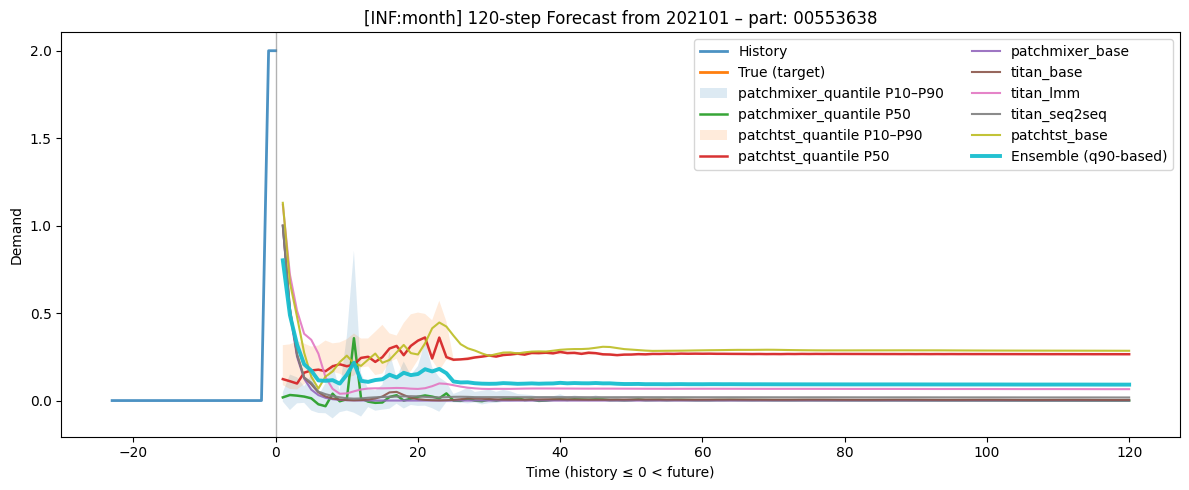

model PatchMixer QuantileModel [DBG] t 0 q10: 1.760615348815918 q50: 2.242711067199707 q90: 3.92077898979187
model PatchMixer QuantileModel [DBG] t 1 q10: 1.744166374206543 q50: 2.1819722652435303 q90: 3.616365909576416
model PatchMixer QuantileModel [DBG] t 2 q10: 1.7048896551132202 q50: 2.0835084915161133 q90: 3.44518780708313
model PatchMixer QuantileModel [DBG] t 3 q10: 1.7405198812484741 q50: 2.1401469707489014 q90: 3.36293363571167
model PatchMixer QuantileModel [DBG] t 4 q10: 1.8198390007019043 q50: 2.1082613468170166 q90: 3.1624884605407715
model PatchTST QuantileModel [DBG] t 0 q10: 2.487133502960205 q50: 2.6325178146362305 q90: 2.799410104751587
model PatchTST QuantileModel [DBG] t 1 q10: 2.5295019149780273 q50: 2.6340599060058594 q90: 2.7583892345428467
model PatchTST QuantileModel [DBG] t 2 q10: 2.4738688468933105 q50: 2.6773202419281006 q90: 2.830590009689331
model PatchTST QuantileModel [DBG] t 3 q10: 2.5022921562194824 q50: 2.6391448974609375 q90: 2.8528428077697754
mode

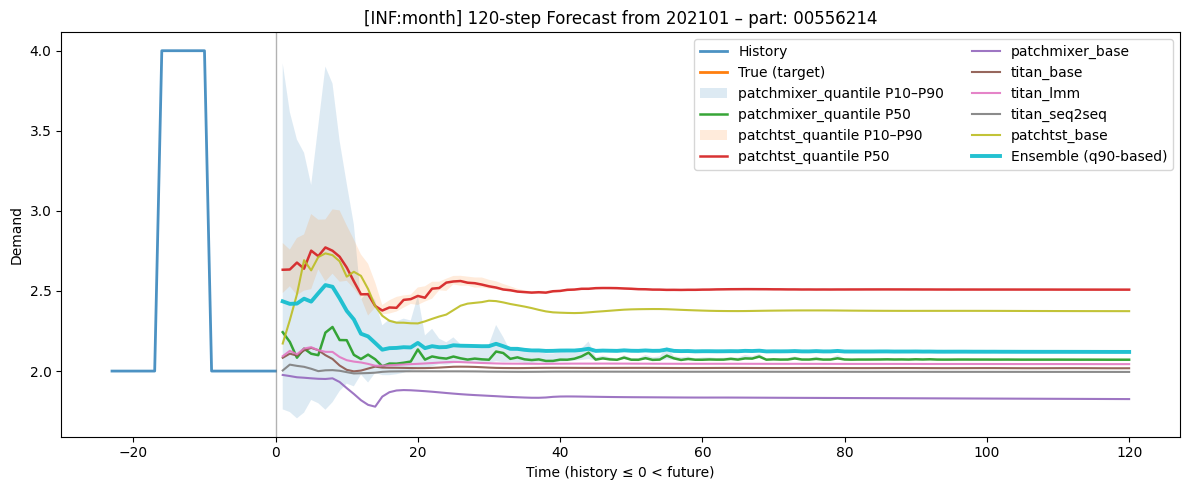

model PatchMixer QuantileModel [DBG] t 0 q10: 0.7711526155471802 q50: 1.3247475624084473 q90: 3.0791656970977783
model PatchMixer QuantileModel [DBG] t 1 q10: 0.8619756102561951 q50: 1.387418270111084 q90: 3.3098907470703125
model PatchMixer QuantileModel [DBG] t 2 q10: 0.8322747945785522 q50: 1.448979139328003 q90: 3.4621663093566895
model PatchMixer QuantileModel [DBG] t 3 q10: 0.8365299105644226 q50: 1.557471513748169 q90: 3.725443124771118
model PatchMixer QuantileModel [DBG] t 4 q10: 1.072981834411621 q50: 2.5558016300201416 q90: 6.005200386047363
model PatchTST QuantileModel [DBG] t 0 q10: 1.616280436515808 q50: 1.6471985578536987 q90: 1.7883577346801758
model PatchTST QuantileModel [DBG] t 1 q10: 1.558705449104309 q50: 1.7640273571014404 q90: 1.8476622104644775
model PatchTST QuantileModel [DBG] t 2 q10: 1.6931134462356567 q50: 1.730319619178772 q90: 1.8828489780426025
model PatchTST QuantileModel [DBG] t 3 q10: 1.6490471363067627 q50: 1.7415603399276733 q90: 1.822636365890503
m

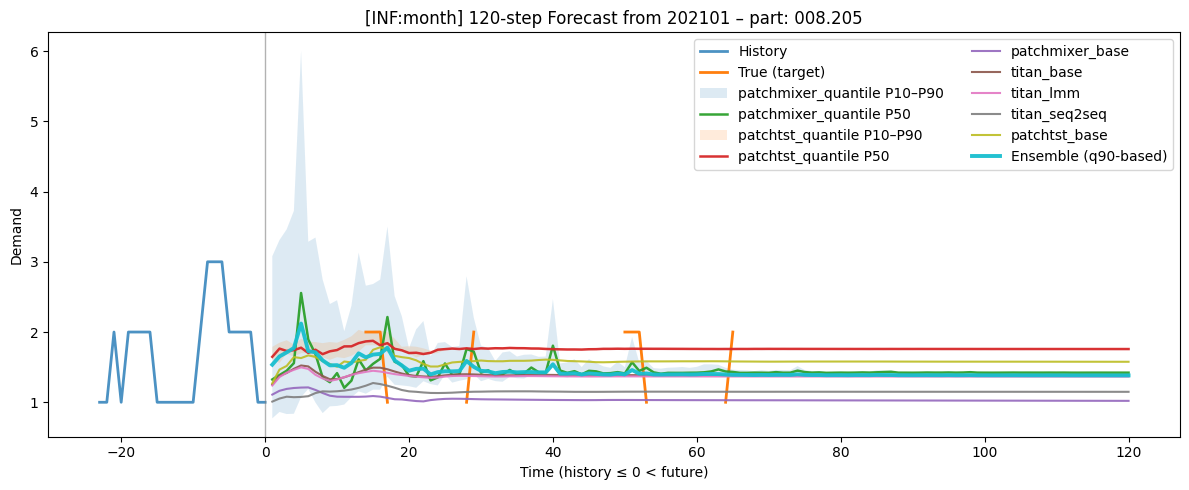

model PatchMixer QuantileModel [DBG] t 0 q10: 1.1259620189666748 q50: 1.4854108095169067 q90: 2.715419292449951
model PatchMixer QuantileModel [DBG] t 1 q10: 1.310594081878662 q50: 1.649103045463562 q90: 2.7099664211273193
model PatchMixer QuantileModel [DBG] t 2 q10: 1.4401578903198242 q50: 1.6593399047851562 q90: 2.7343664169311523
model PatchMixer QuantileModel [DBG] t 3 q10: 1.4936339855194092 q50: 1.701717734336853 q90: 2.5430665016174316
model PatchMixer QuantileModel [DBG] t 4 q10: 1.505215048789978 q50: 1.9300535917282104 q90: 2.8862948417663574
model PatchTST QuantileModel [DBG] t 0 q10: 1.6997092962265015 q50: 1.7679603099822998 q90: 1.891603946685791
model PatchTST QuantileModel [DBG] t 1 q10: 1.7593339681625366 q50: 1.8283352851867676 q90: 1.9254695177078247
model PatchTST QuantileModel [DBG] t 2 q10: 1.8467164039611816 q50: 1.8891825675964355 q90: 1.9217771291732788
model PatchTST QuantileModel [DBG] t 3 q10: 1.8502604961395264 q50: 1.9246994256973267 q90: 1.94582128524780

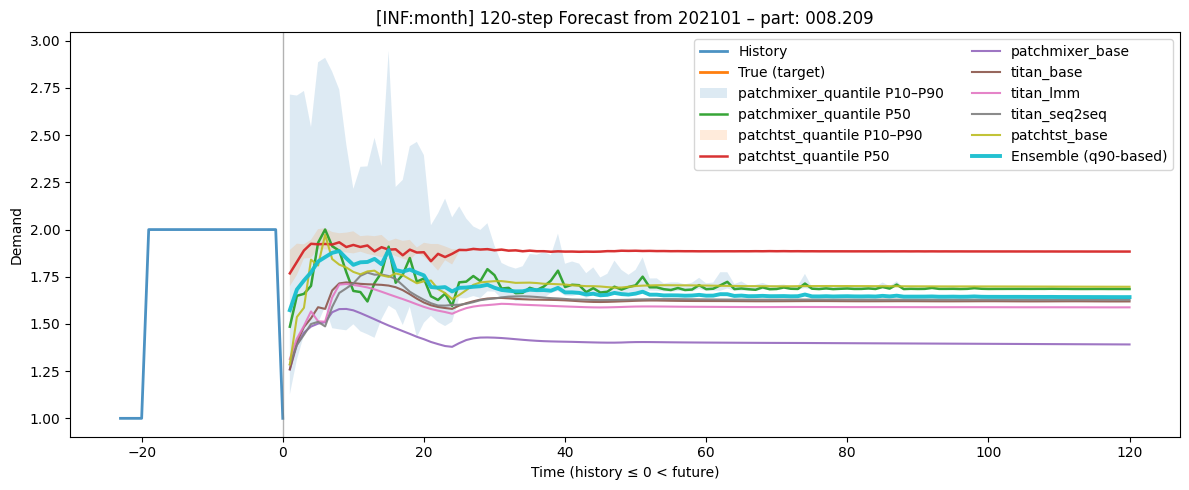

model PatchMixer QuantileModel [DBG] t 0 q10: 0.9992461204528809 q50: 0.9994205832481384 q90: 0.9997384548187256
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9992043972015381 q50: 0.9993777871131897 q90: 0.9997034668922424
model PatchMixer QuantileModel [DBG] t 2 q10: 0.9991669654846191 q50: 0.9993583559989929 q90: 0.9997172355651855
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9991217851638794 q50: 0.999293327331543 q90: 0.9997464418411255
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9990863800048828 q50: 0.9992753863334656 q90: 0.9996991753578186
model PatchTST QuantileModel [DBG] t 0 q10: 0.9991579651832581 q50: 0.9995782375335693 q90: 1.0014750957489014
model PatchTST QuantileModel [DBG] t 1 q10: 0.9991275072097778 q50: 0.9995693564414978 q90: 1.0014744997024536
model PatchTST QuantileModel [DBG] t 2 q10: 0.9991117119789124 q50: 0.9995369911193848 q90: 1.0014644861221313
model PatchTST QuantileModel [DBG] t 3 q10: 0.9991029500961304 q50: 0.9995430111885071 q90: 1.001441478

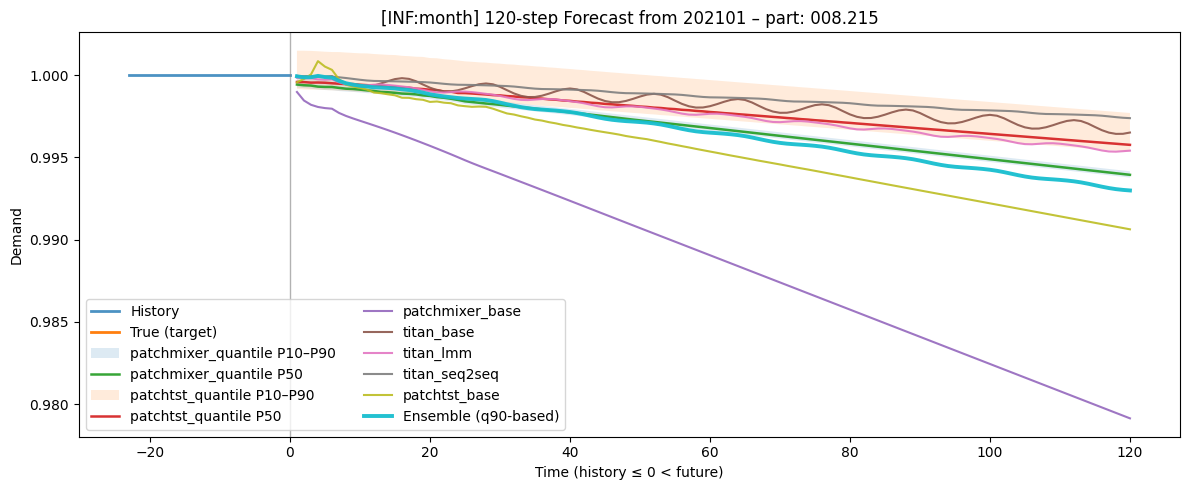

model PatchMixer QuantileModel [DBG] t 0 q10: 0.1492633819580078 q50: 1.7675178050994873 q90: 8.765329360961914
model PatchMixer QuantileModel [DBG] t 1 q10: 0.2529282569885254 q50: 1.6142663955688477 q90: 8.75149154663086
model PatchMixer QuantileModel [DBG] t 2 q10: 0.3976348638534546 q50: 1.367650032043457 q90: 5.345174312591553
model PatchMixer QuantileModel [DBG] t 3 q10: 0.48628199100494385 q50: 1.607755184173584 q90: 5.750925064086914
model PatchMixer QuantileModel [DBG] t 4 q10: 0.5198017358779907 q50: 1.5225131511688232 q90: 5.537149429321289
model PatchTST QuantileModel [DBG] t 0 q10: 1.9299442768096924 q50: 3.3043429851531982 q90: 4.853424549102783
model PatchTST QuantileModel [DBG] t 1 q10: 2.409865617752075 q50: 2.500401020050049 q90: 3.810361862182617
model PatchTST QuantileModel [DBG] t 2 q10: 2.1551685333251953 q50: 2.275498628616333 q90: 2.5075912475585938
model PatchTST QuantileModel [DBG] t 3 q10: 2.19887113571167 q50: 2.308969497680664 q90: 2.5944764614105225
model 

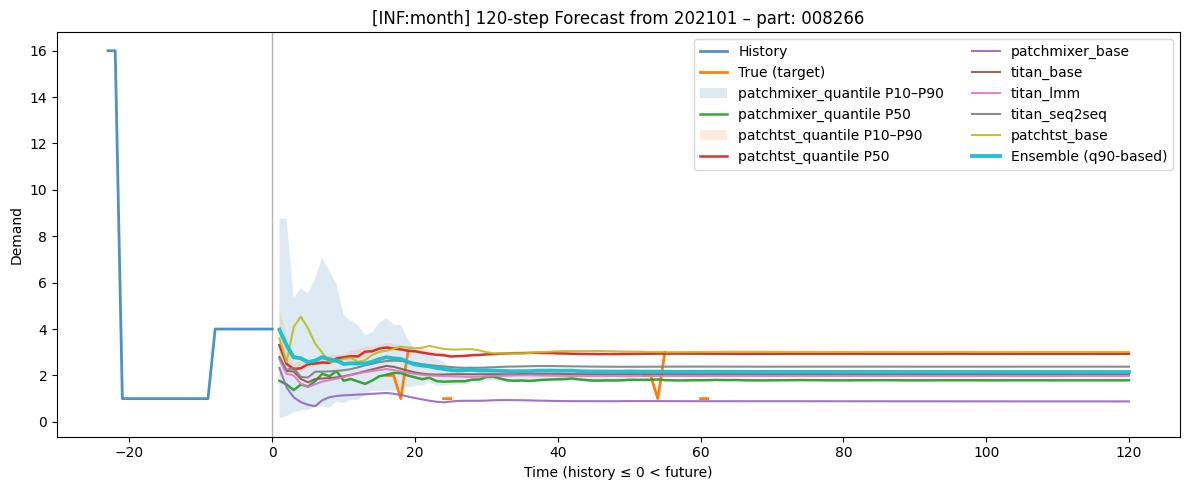

model PatchMixer QuantileModel [DBG] t 0 q10: 0.9906261563301086 q50: 1.005069375038147 q90: 1.0268772840499878
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9994215369224548 q50: 0.9995700716972351 q90: 0.9996503591537476
model PatchMixer QuantileModel [DBG] t 2 q10: 0.9993498921394348 q50: 0.9994750022888184 q90: 0.9998481869697571
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9993153810501099 q50: 0.999517560005188 q90: 0.9996435642242432
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9993610382080078 q50: 0.9995560646057129 q90: 1.0000532865524292
model PatchTST QuantileModel [DBG] t 0 q10: 1.0081284046173096 q50: 1.010634422302246 q90: 1.1315332651138306
model PatchTST QuantileModel [DBG] t 1 q10: 0.9997022747993469 q50: 0.9999669194221497 q90: 1.0017908811569214
model PatchTST QuantileModel [DBG] t 2 q10: 0.9995759129524231 q50: 1.0001952648162842 q90: 1.0018435716629028
model PatchTST QuantileModel [DBG] t 3 q10: 0.9994648694992065 q50: 0.999803364276886 q90: 1.001932263374

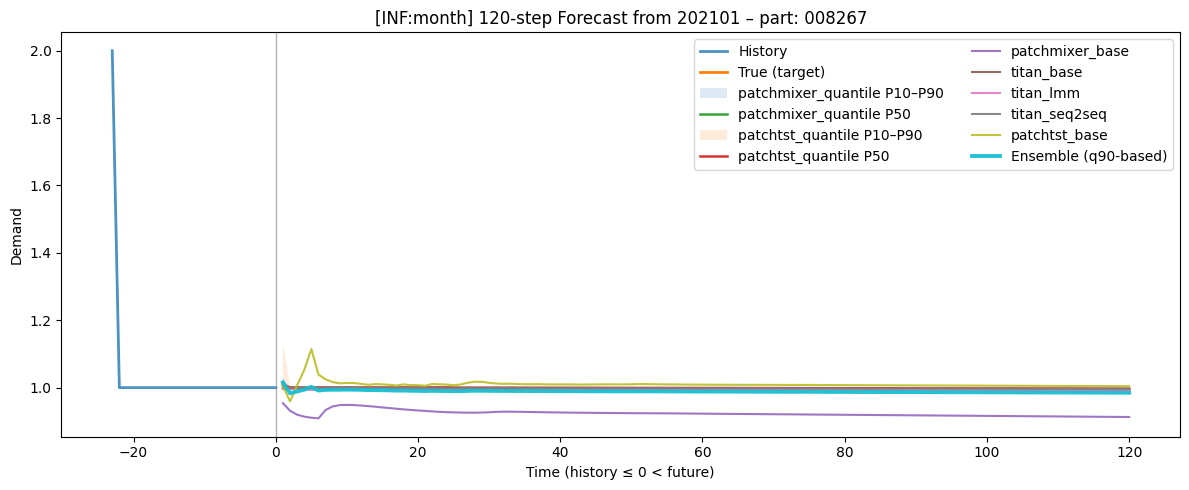

model PatchMixer QuantileModel [DBG] t 0 q10: 1.7842764854431152 q50: 1.9447953701019287 q90: 2.48679518699646
model PatchMixer QuantileModel [DBG] t 1 q10: 1.7744005918502808 q50: 2.027860403060913 q90: 2.746025323867798
model PatchMixer QuantileModel [DBG] t 2 q10: 1.8156983852386475 q50: 2.0449910163879395 q90: 2.743333578109741
model PatchMixer QuantileModel [DBG] t 3 q10: 1.8607455492019653 q50: 1.954308032989502 q90: 2.269864797592163
model PatchMixer QuantileModel [DBG] t 4 q10: 1.8707503080368042 q50: 1.969288945198059 q90: 2.4212772846221924
model PatchTST QuantileModel [DBG] t 0 q10: 2.0476245880126953 q50: 2.1265883445739746 q90: 2.249617576599121
model PatchTST QuantileModel [DBG] t 1 q10: 2.1011128425598145 q50: 2.1385271549224854 q90: 2.2040791511535645
model PatchTST QuantileModel [DBG] t 2 q10: 2.07338809967041 q50: 2.153378963470459 q90: 2.2421135902404785
model PatchTST QuantileModel [DBG] t 3 q10: 2.0481646060943604 q50: 2.0889596939086914 q90: 2.2482166290283203
mod

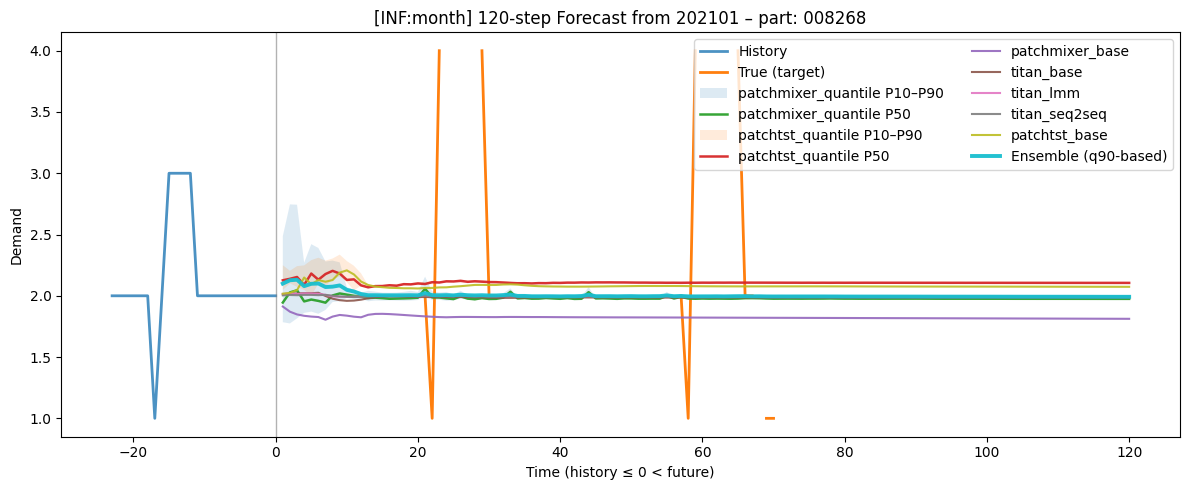

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

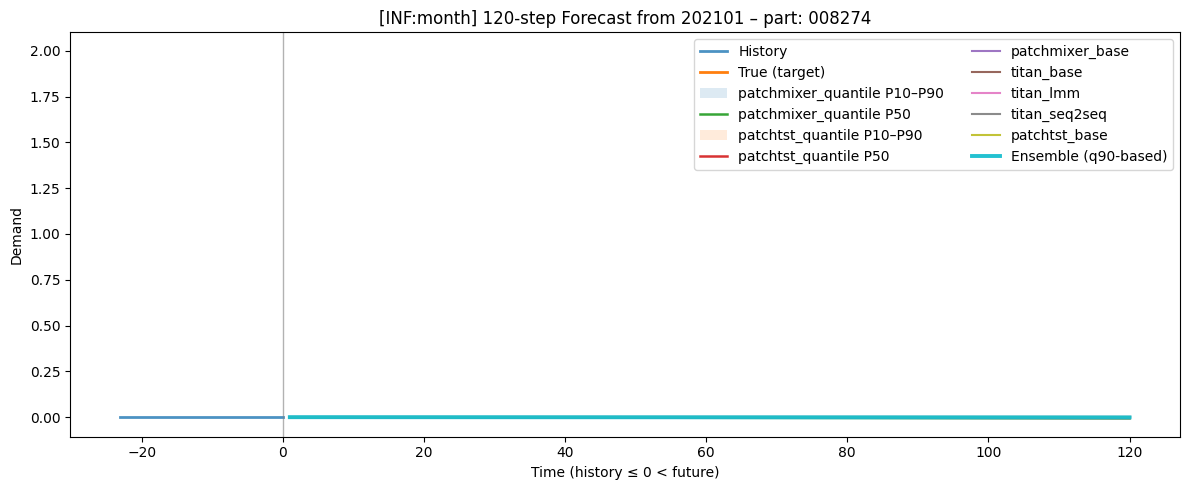

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

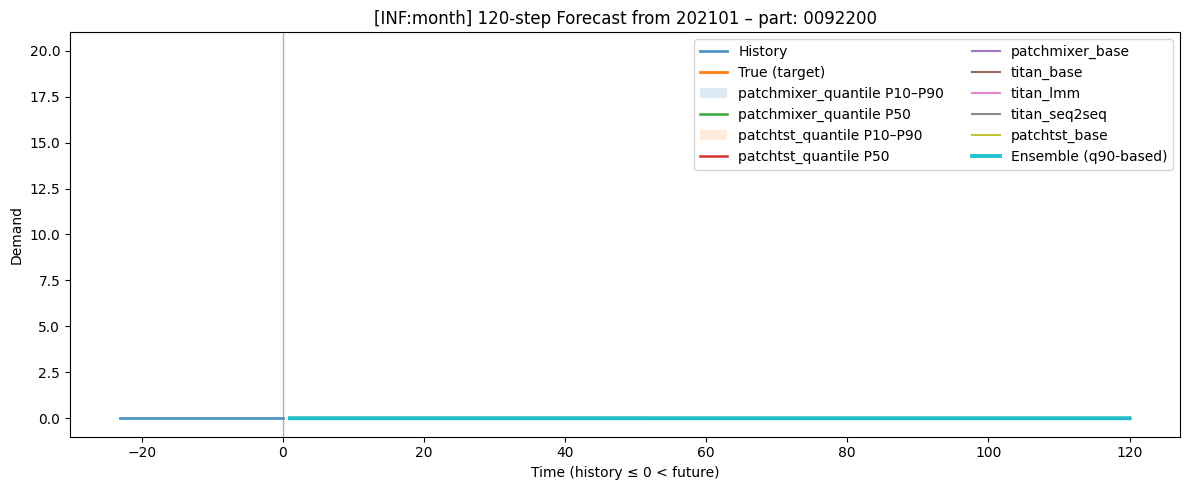

model PatchMixer QuantileModel [DBG] t 0 q10: 0.9992461204528809 q50: 0.9994205832481384 q90: 0.9997384548187256
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9992043972015381 q50: 0.9993777871131897 q90: 0.9997034668922424
model PatchMixer QuantileModel [DBG] t 2 q10: 0.9991669654846191 q50: 0.9993583559989929 q90: 0.9997172355651855
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9991217851638794 q50: 0.999293327331543 q90: 0.9997464418411255
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9990863800048828 q50: 0.9992753863334656 q90: 0.9996991753578186
model PatchTST QuantileModel [DBG] t 0 q10: 0.9991579651832581 q50: 0.9995782375335693 q90: 1.0014750957489014
model PatchTST QuantileModel [DBG] t 1 q10: 0.9991275072097778 q50: 0.9995693564414978 q90: 1.0014744997024536
model PatchTST QuantileModel [DBG] t 2 q10: 0.9991117119789124 q50: 0.9995369911193848 q90: 1.0014644861221313
model PatchTST QuantileModel [DBG] t 3 q10: 0.9991029500961304 q50: 0.9995430111885071 q90: 1.001441478

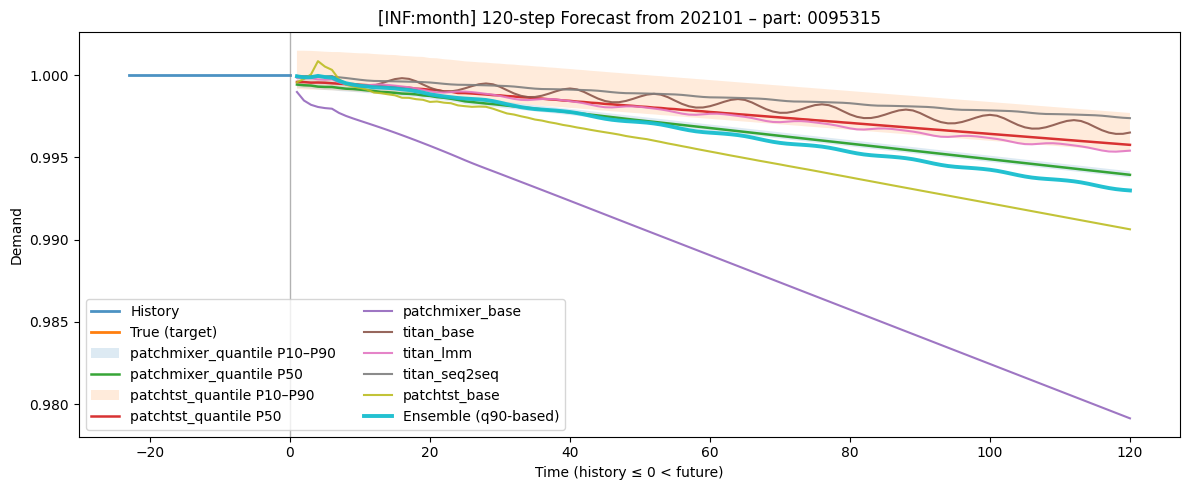

model PatchMixer QuantileModel [DBG] t 0 q10: -0.5458204746246338 q50: 0.002437591552734375 q90: 2.5642170906066895
model PatchMixer QuantileModel [DBG] t 1 q10: -0.2823069095611572 q50: 0.03273117542266846 q90: 1.9271793365478516
model PatchMixer QuantileModel [DBG] t 2 q10: -0.35499775409698486 q50: 0.24985694885253906 q90: 2.8276827335357666
model PatchMixer QuantileModel [DBG] t 3 q10: -0.3488956689834595 q50: 0.23114079236984253 q90: 3.299424886703491
model PatchMixer QuantileModel [DBG] t 4 q10: -0.45990484952926636 q50: 0.24687159061431885 q90: 3.6415085792541504
model PatchTST QuantileModel [DBG] t 0 q10: 0.7417312860488892 q50: 0.7962180376052856 q90: 1.090814232826233
model PatchTST QuantileModel [DBG] t 1 q10: 0.7552946209907532 q50: 0.8355275392532349 q90: 1.1512540578842163
model PatchTST QuantileModel [DBG] t 2 q10: 0.8199559450149536 q50: 0.9382522702217102 q90: 1.1787480115890503
model PatchTST QuantileModel [DBG] t 3 q10: 0.8942188024520874 q50: 1.006898283958435 q90: 

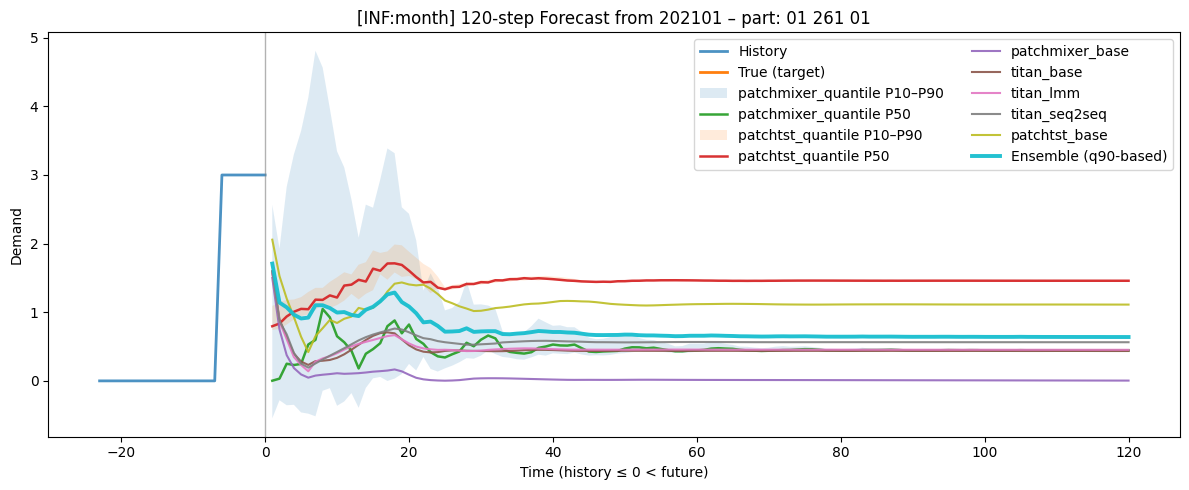

model PatchMixer QuantileModel [DBG] t 0 q10: 4.812588691711426 q50: 5.10145378112793 q90: 5.537664890289307
model PatchMixer QuantileModel [DBG] t 1 q10: 4.9989800453186035 q50: 5.000030040740967 q90: 5.001681804656982
model PatchMixer QuantileModel [DBG] t 2 q10: 4.9980597496032715 q50: 5.000823020935059 q90: 5.007140636444092
model PatchMixer QuantileModel [DBG] t 3 q10: 4.99806022644043 q50: 4.999916076660156 q90: 5.002655029296875
model PatchMixer QuantileModel [DBG] t 4 q10: 4.998970031738281 q50: 5.000644683837891 q90: 5.002228260040283
model PatchTST QuantileModel [DBG] t 0 q10: 5.1626973152160645 q50: 5.212780475616455 q90: 7.630436420440674
model PatchTST QuantileModel [DBG] t 1 q10: 5.001661777496338 q50: 5.00386381149292 q90: 5.0221357345581055
model PatchTST QuantileModel [DBG] t 2 q10: 5.000716686248779 q50: 5.006802082061768 q90: 5.02238655090332
model PatchTST QuantileModel [DBG] t 3 q10: 4.999514102935791 q50: 5.002573013305664 q90: 5.023214340209961
model PatchTST Qua

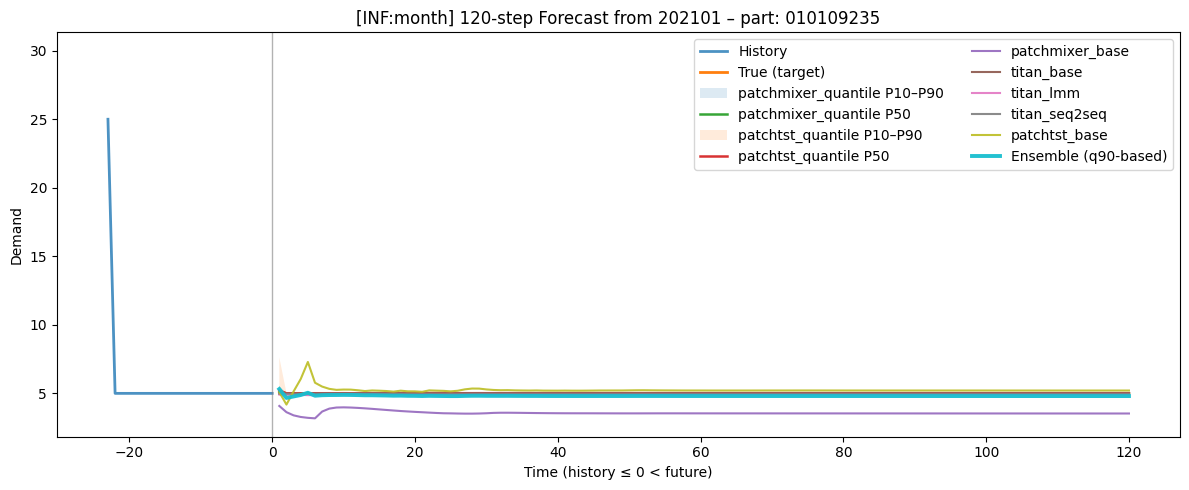

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

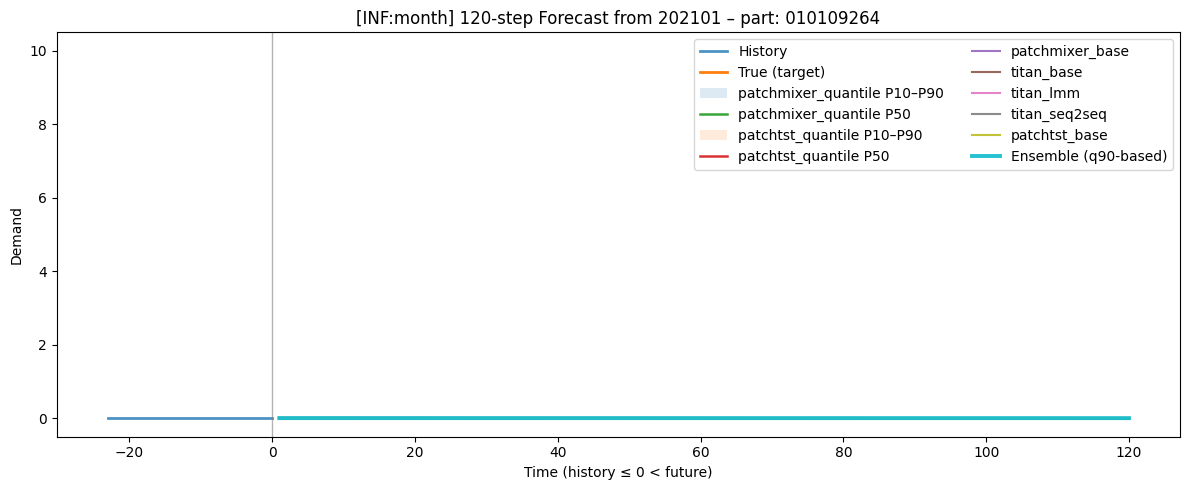

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

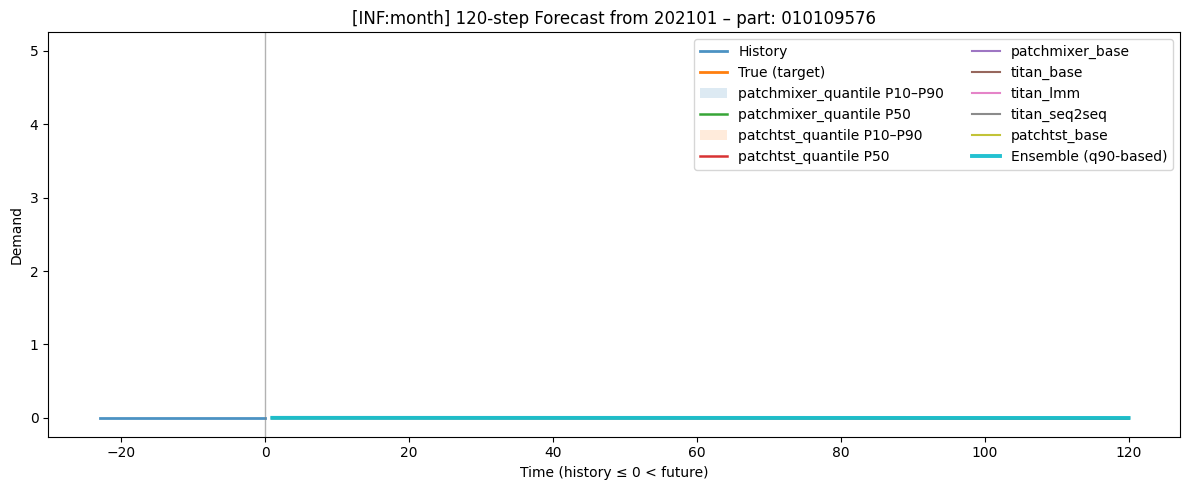

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

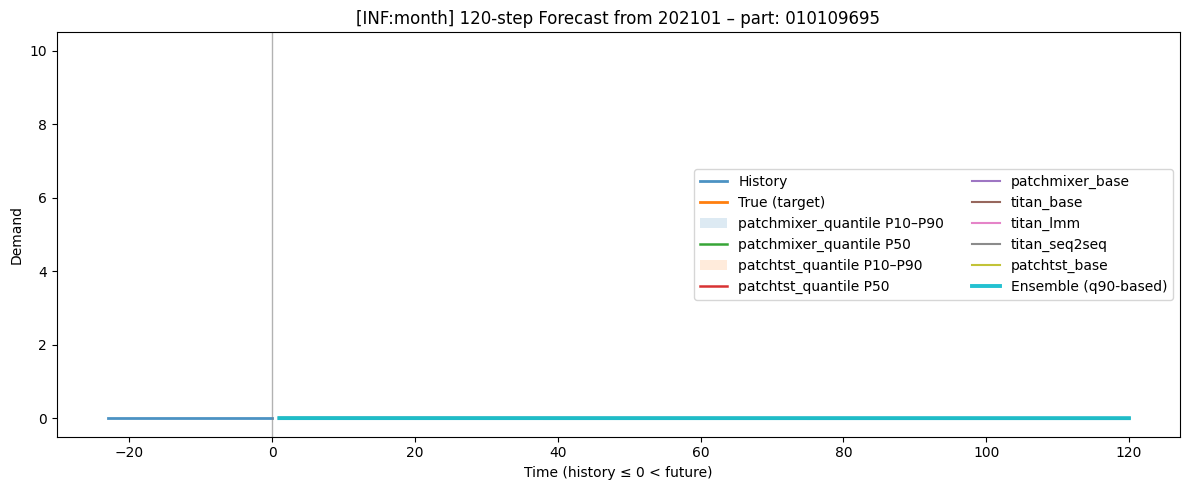

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

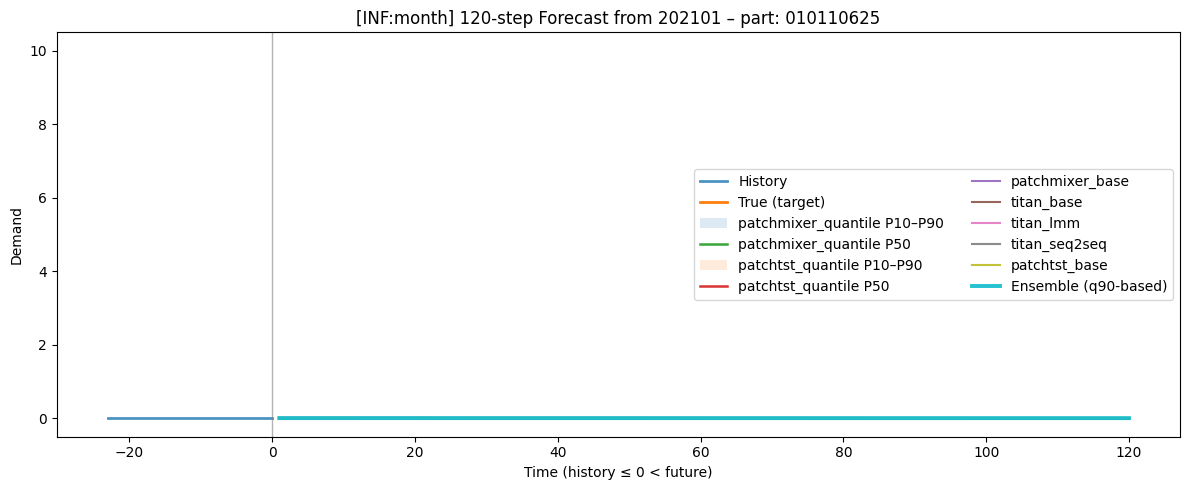

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

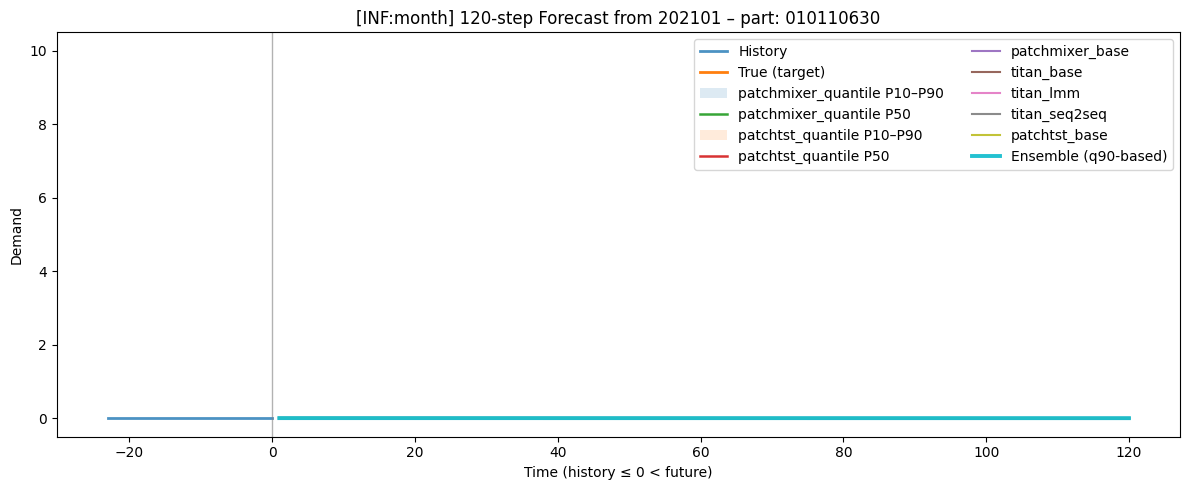

model PatchMixer QuantileModel [DBG] t 0 q10: 3.596607208251953 q50: 5.933712482452393 q90: 13.638357162475586
model PatchMixer QuantileModel [DBG] t 1 q10: 3.7978105545043945 q50: 5.974484920501709 q90: 12.944677352905273
model PatchMixer QuantileModel [DBG] t 2 q10: 4.143871307373047 q50: 6.135404109954834 q90: 12.736554145812988
model PatchMixer QuantileModel [DBG] t 3 q10: 4.131412506103516 q50: 6.040719032287598 q90: 13.217373847961426
model PatchMixer QuantileModel [DBG] t 4 q10: 4.401823997497559 q50: 7.128938674926758 q90: 15.754033088684082
model PatchTST QuantileModel [DBG] t 0 q10: 7.451392650604248 q50: 7.628043174743652 q90: 8.254589080810547
model PatchTST QuantileModel [DBG] t 1 q10: 7.354584693908691 q50: 7.672289848327637 q90: 8.158589363098145
model PatchTST QuantileModel [DBG] t 2 q10: 7.31515645980835 q50: 7.369600772857666 q90: 7.920863628387451
model PatchTST QuantileModel [DBG] t 3 q10: 7.050269603729248 q50: 7.4880170822143555 q90: 7.917914867401123
model PatchT

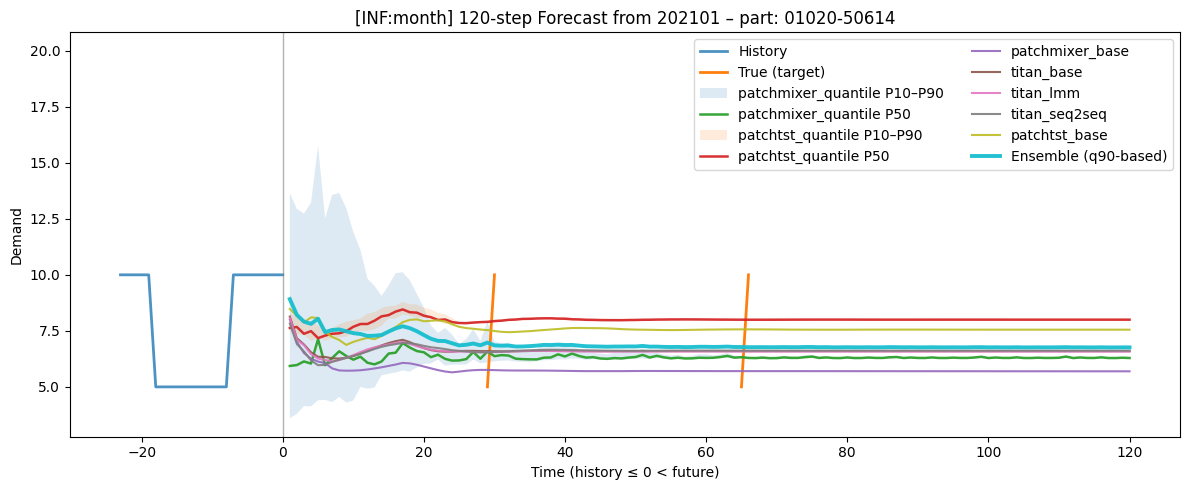

model PatchMixer QuantileModel [DBG] t 0 q10: -49.741310119628906 q50: 32.946502685546875 q90: 369.9728698730469
model PatchMixer QuantileModel [DBG] t 1 q10: -36.08656311035156 q50: 38.23158645629883 q90: 326.1565246582031
model PatchMixer QuantileModel [DBG] t 2 q10: -38.3568115234375 q50: 47.116188049316406 q90: 388.04107666015625
model PatchMixer QuantileModel [DBG] t 3 q10: -31.254348754882812 q50: 48.08196258544922 q90: 373.7371520996094
model PatchMixer QuantileModel [DBG] t 4 q10: -28.339019775390625 q50: 50.29903030395508 q90: 379.68389892578125
model PatchTST QuantileModel [DBG] t 0 q10: 84.97671508789062 q50: 91.41193389892578 q90: 106.2330551147461
model PatchTST QuantileModel [DBG] t 1 q10: 86.10696411132812 q50: 93.5940170288086 q90: 112.91036987304688
model PatchTST QuantileModel [DBG] t 2 q10: 92.00524139404297 q50: 103.58744812011719 q90: 116.48197937011719
model PatchTST QuantileModel [DBG] t 3 q10: 98.94760131835938 q50: 108.49158477783203 q90: 117.57438659667969
mod

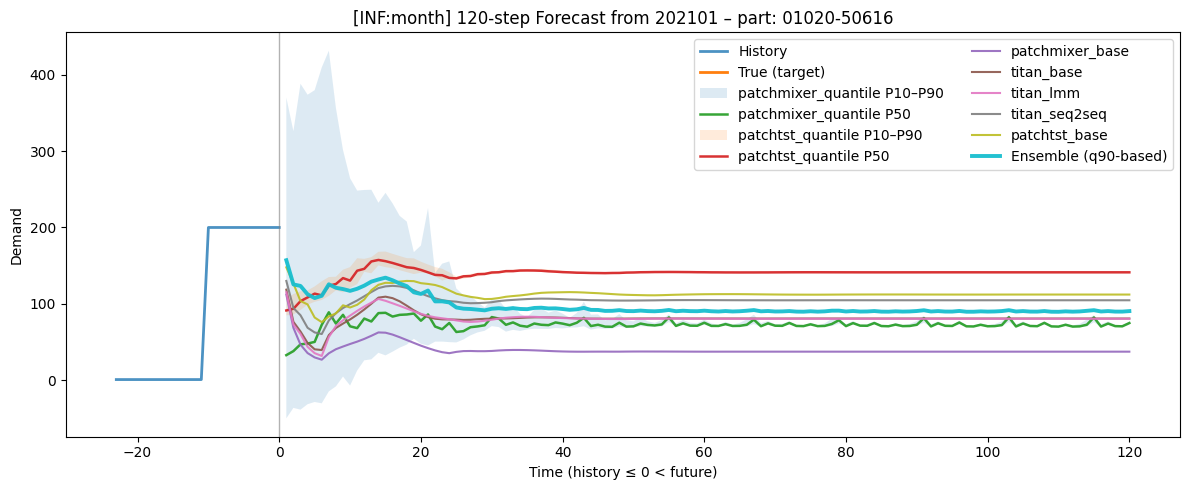

model PatchMixer QuantileModel [DBG] t 0 q10: 4.201141357421875 q50: 18.17578887939453 q90: 83.01605224609375
model PatchMixer QuantileModel [DBG] t 1 q10: -0.07105255126953125 q50: 17.52309226989746 q90: 70.79277801513672
model PatchMixer QuantileModel [DBG] t 2 q10: -5.967723846435547 q50: 11.044628143310547 q90: 50.6982421875
model PatchMixer QuantileModel [DBG] t 3 q10: -4.92987060546875 q50: 15.273529052734375 q90: 136.38912963867188
model PatchMixer QuantileModel [DBG] t 4 q10: 97.93058776855469 q50: 251.31100463867188 q90: 614.2879638671875
model PatchTST QuantileModel [DBG] t 0 q10: 40.7755126953125 q50: 42.31703567504883 q90: 70.53602600097656
model PatchTST QuantileModel [DBG] t 1 q10: 44.19371795654297 q50: 50.305885314941406 q90: 65.12142944335938
model PatchTST QuantileModel [DBG] t 2 q10: 43.5301628112793 q50: 49.389495849609375 q90: 64.49959564208984
model PatchTST QuantileModel [DBG] t 3 q10: 37.53645706176758 q50: 48.729270935058594 q90: 70.61380767822266
model PatchTS

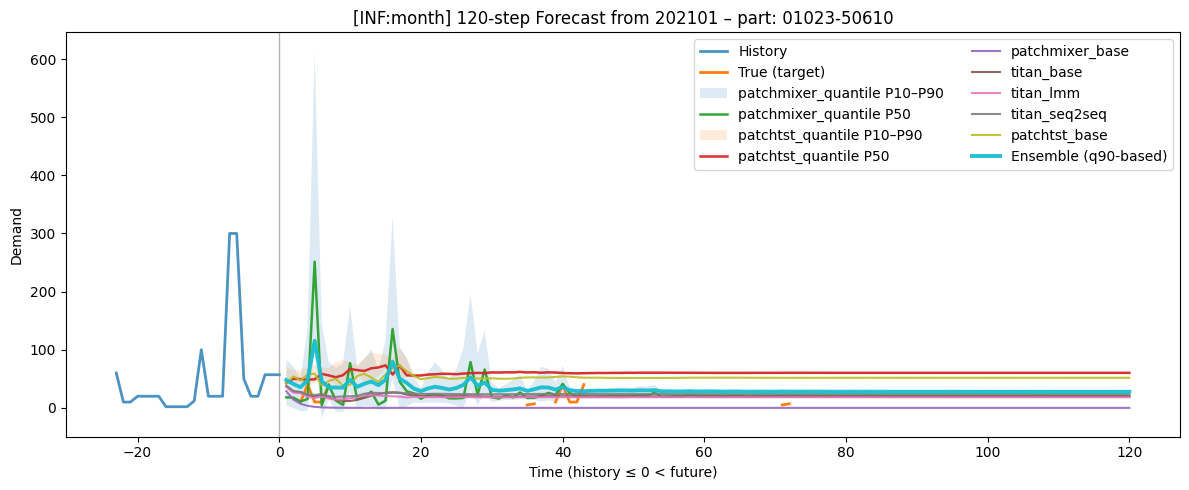

model PatchMixer QuantileModel [DBG] t 0 q10: -12.147857666015625 q50: 2.2961044311523438 q90: 65.78343200683594
model PatchMixer QuantileModel [DBG] t 1 q10: -22.178939819335938 q50: 21.609397888183594 q90: 182.88961791992188
model PatchMixer QuantileModel [DBG] t 2 q10: -7.540199279785156 q50: 15.201866149902344 q90: 112.80293273925781
model PatchMixer QuantileModel [DBG] t 3 q10: -38.0682373046875 q50: 7.750099182128906 q90: 104.25977325439453
model PatchMixer QuantileModel [DBG] t 4 q10: -49.2393798828125 q50: 11.275016784667969 q90: 90.06524658203125
model PatchTST QuantileModel [DBG] t 0 q10: 51.099090576171875 q50: 60.498104095458984 q90: 198.86294555664062
model PatchTST QuantileModel [DBG] t 1 q10: 41.93633270263672 q50: 110.92918395996094 q90: 195.10162353515625
model PatchTST QuantileModel [DBG] t 2 q10: 54.94472885131836 q50: 81.99227905273438 q90: 167.3291778564453
model PatchTST QuantileModel [DBG] t 3 q10: 35.84331512451172 q50: 105.31575775146484 q90: 218.4490966796875


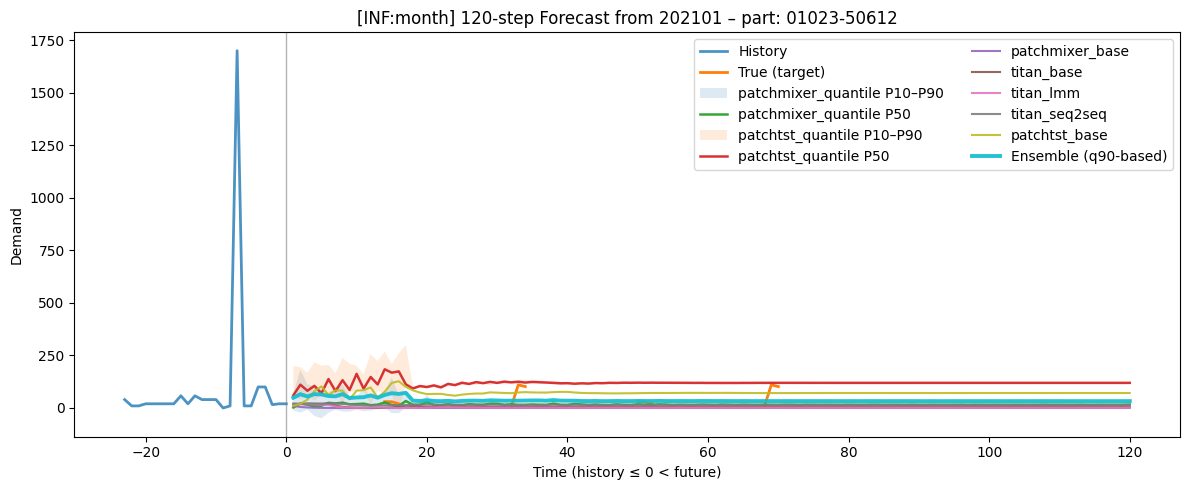

model PatchMixer QuantileModel [DBG] t 0 q10: -143.1387939453125 q50: 49.2779541015625 q90: 498.5615539550781
model PatchMixer QuantileModel [DBG] t 1 q10: -65.91900634765625 q50: 85.1414794921875 q90: 719.8099975585938
model PatchMixer QuantileModel [DBG] t 2 q10: -15.43359375 q50: 177.50799560546875 q90: 791.3387451171875
model PatchMixer QuantileModel [DBG] t 3 q10: -11.45758056640625 q50: 132.78759765625 q90: 699.0787353515625
model PatchMixer QuantileModel [DBG] t 4 q10: -62.1109619140625 q50: 74.750244140625 q90: 394.5232849121094
model PatchTST QuantileModel [DBG] t 0 q10: 380.0198974609375 q50: 518.85009765625 q90: 1050.2486572265625
model PatchTST QuantileModel [DBG] t 1 q10: 308.01312255859375 q50: 665.8043212890625 q90: 1215.439453125
model PatchTST QuantileModel [DBG] t 2 q10: 499.53204345703125 q50: 685.6796264648438 q90: 1036.7769775390625
model PatchTST QuantileModel [DBG] t 3 q10: 545.7802734375 q50: 826.0106811523438 q90: 1075.1678466796875
model PatchTST QuantileModel

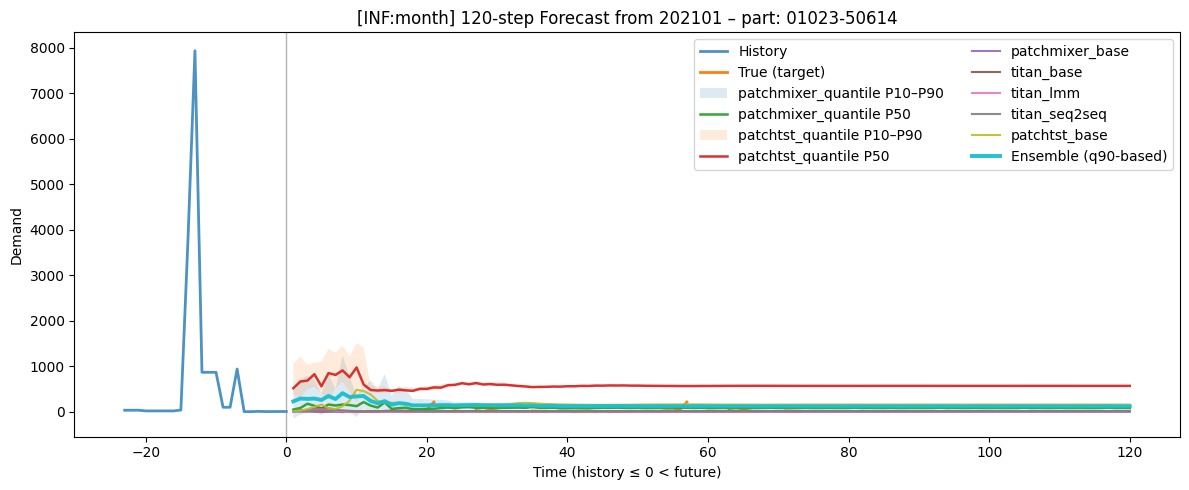

model PatchMixer QuantileModel [DBG] t 0 q10: -79.57171630859375 q50: 101.96444702148438 q90: 662.1138916015625
model PatchMixer QuantileModel [DBG] t 1 q10: -104.72152709960938 q50: 67.20413208007812 q90: 347.43804931640625
model PatchMixer QuantileModel [DBG] t 2 q10: -14.662261962890625 q50: 77.10687255859375 q90: 323.77972412109375
model PatchMixer QuantileModel [DBG] t 3 q10: -33.681976318359375 q50: 95.82962036132812 q90: 536.5938110351562
model PatchMixer QuantileModel [DBG] t 4 q10: -36.58062744140625 q50: 106.22479248046875 q90: 290.76837158203125
model PatchTST QuantileModel [DBG] t 0 q10: 85.197021484375 q50: 447.1615905761719 q90: 925.8107299804688
model PatchTST QuantileModel [DBG] t 1 q10: 245.17393493652344 q50: 326.01251220703125 q90: 808.462890625
model PatchTST QuantileModel [DBG] t 2 q10: 297.50531005859375 q50: 623.39599609375 q90: 770.7122802734375
model PatchTST QuantileModel [DBG] t 3 q10: 281.695556640625 q50: 315.451904296875 q90: 612.2605590820312
model PatchT

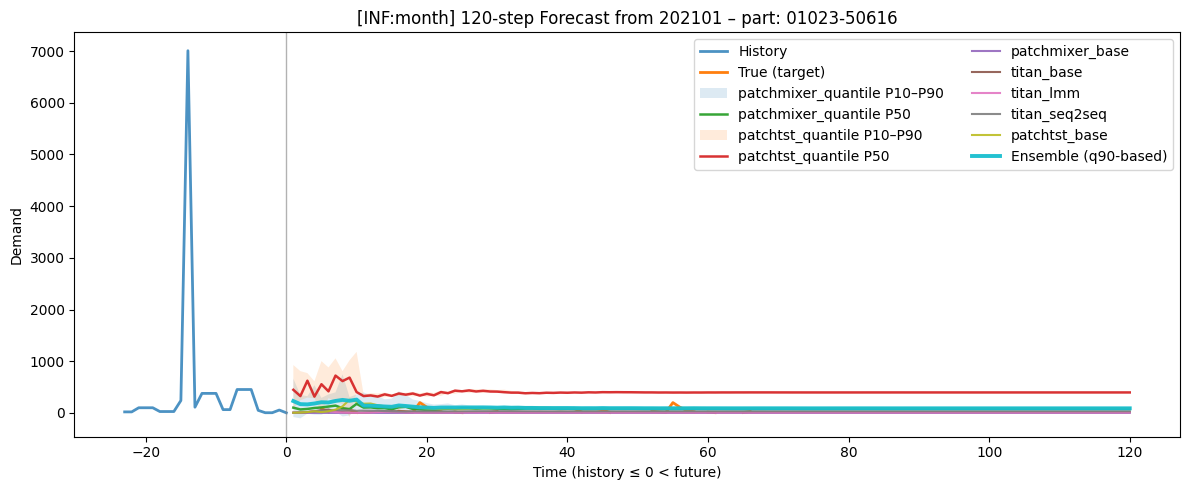

model PatchMixer QuantileModel [DBG] t 0 q10: -86.47000122070312 q50: 61.80615234375 q90: 884.6178588867188
model PatchMixer QuantileModel [DBG] t 1 q10: -61.851409912109375 q50: 80.0970458984375 q90: 803.7752685546875
model PatchMixer QuantileModel [DBG] t 2 q10: -84.21670532226562 q50: 94.32147216796875 q90: 941.682373046875
model PatchMixer QuantileModel [DBG] t 3 q10: -80.458251953125 q50: 126.75653076171875 q90: 1070.171875
model PatchMixer QuantileModel [DBG] t 4 q10: -68.32809448242188 q50: 196.78573608398438 q90: 1149.408447265625
model PatchTST QuantileModel [DBG] t 0 q10: 257.9940185546875 q50: 268.7489929199219 q90: 350.93328857421875
model PatchTST QuantileModel [DBG] t 1 q10: 269.90911865234375 q50: 302.5270080566406 q90: 360.6314392089844
model PatchTST QuantileModel [DBG] t 2 q10: 290.1882629394531 q50: 313.47003173828125 q90: 366.1514892578125
model PatchTST QuantileModel [DBG] t 3 q10: 300.6705017089844 q50: 335.5660705566406 q90: 381.103515625
model PatchTST QuantileM

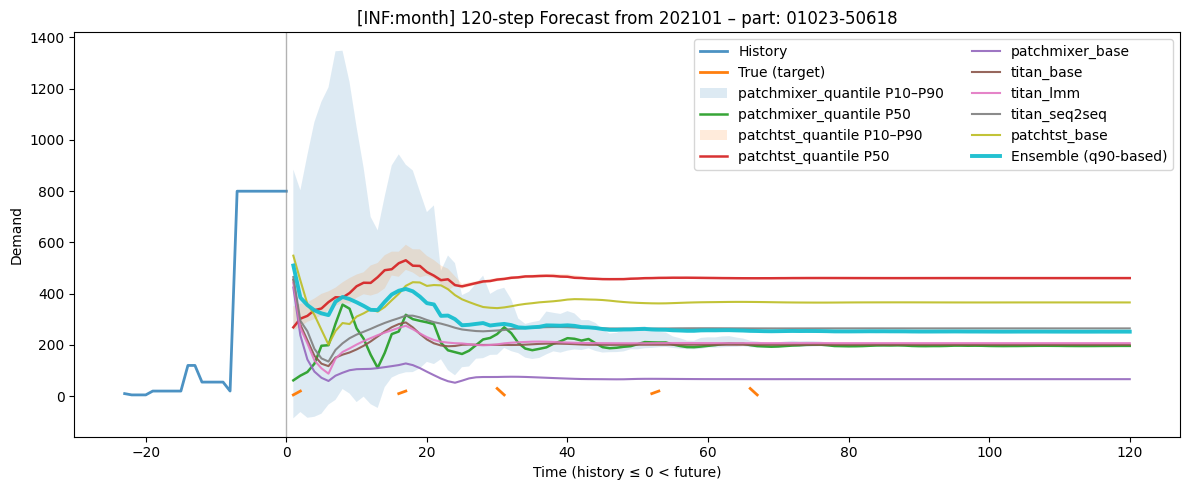

model PatchMixer QuantileModel [DBG] t 0 q10: -14.550117492675781 q50: 26.599315643310547 q90: 154.97117614746094
model PatchMixer QuantileModel [DBG] t 1 q10: -4.617534637451172 q50: 32.99497985839844 q90: 148.037841796875
model PatchMixer QuantileModel [DBG] t 2 q10: -5.747501373291016 q50: 22.70171356201172 q90: 148.3020782470703
model PatchMixer QuantileModel [DBG] t 3 q10: -13.710929870605469 q50: 22.55768585205078 q90: 150.96942138671875
model PatchMixer QuantileModel [DBG] t 4 q10: 7.755649566650391 q50: 102.90825653076172 q90: 336.102783203125
model PatchTST QuantileModel [DBG] t 0 q10: 40.603363037109375 q50: 73.34867095947266 q90: 93.99507141113281
model PatchTST QuantileModel [DBG] t 1 q10: 50.728214263916016 q50: 54.300987243652344 q90: 76.72248077392578
model PatchTST QuantileModel [DBG] t 2 q10: 39.58108901977539 q50: 65.11148071289062 q90: 74.06755828857422
model PatchTST QuantileModel [DBG] t 3 q10: 50.330657958984375 q50: 57.66812515258789 q90: 69.68374633789062
model 

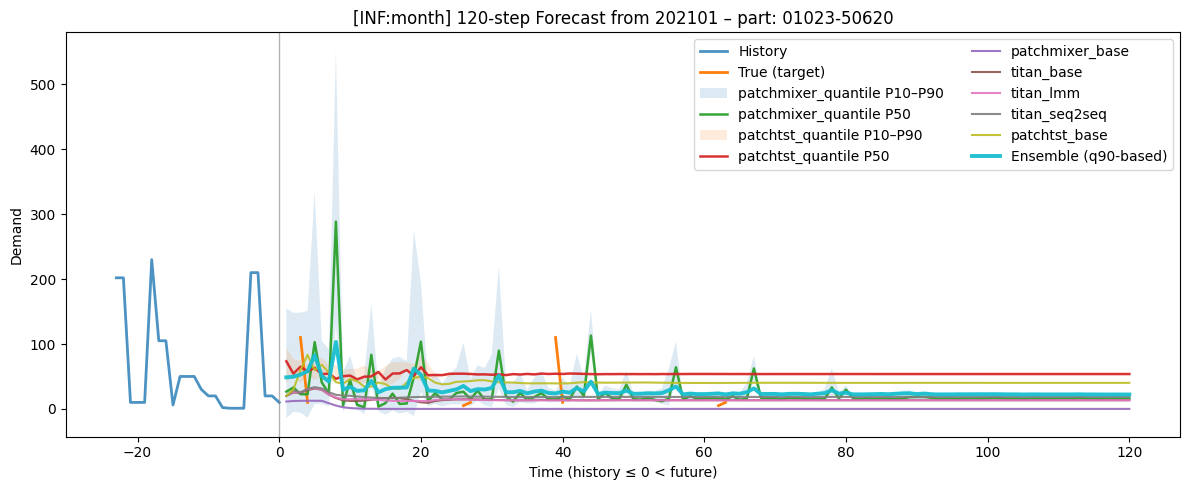

model PatchMixer QuantileModel [DBG] t 0 q10: -2.176179885864258 q50: 8.13686752319336 q90: 45.01283264160156
model PatchMixer QuantileModel [DBG] t 1 q10: -6.386190414428711 q50: 3.6138763427734375 q90: 39.10102462768555
model PatchMixer QuantileModel [DBG] t 2 q10: -1.2757816314697266 q50: 7.834632873535156 q90: 43.26664733886719
model PatchMixer QuantileModel [DBG] t 3 q10: -0.23548316955566406 q50: 6.421354293823242 q90: 36.37726974487305
model PatchMixer QuantileModel [DBG] t 4 q10: -0.10045242309570312 q50: 7.058349609375 q90: 37.986637115478516
model PatchTST QuantileModel [DBG] t 0 q10: 19.360027313232422 q50: 25.86874008178711 q90: 42.76900863647461
model PatchTST QuantileModel [DBG] t 1 q10: 18.941417694091797 q50: 28.079748153686523 q90: 45.611263275146484
model PatchTST QuantileModel [DBG] t 2 q10: 24.106761932373047 q50: 32.166709899902344 q90: 42.87297058105469
model PatchTST QuantileModel [DBG] t 3 q10: 25.387779235839844 q50: 34.27325439453125 q90: 42.77071762084961
mod

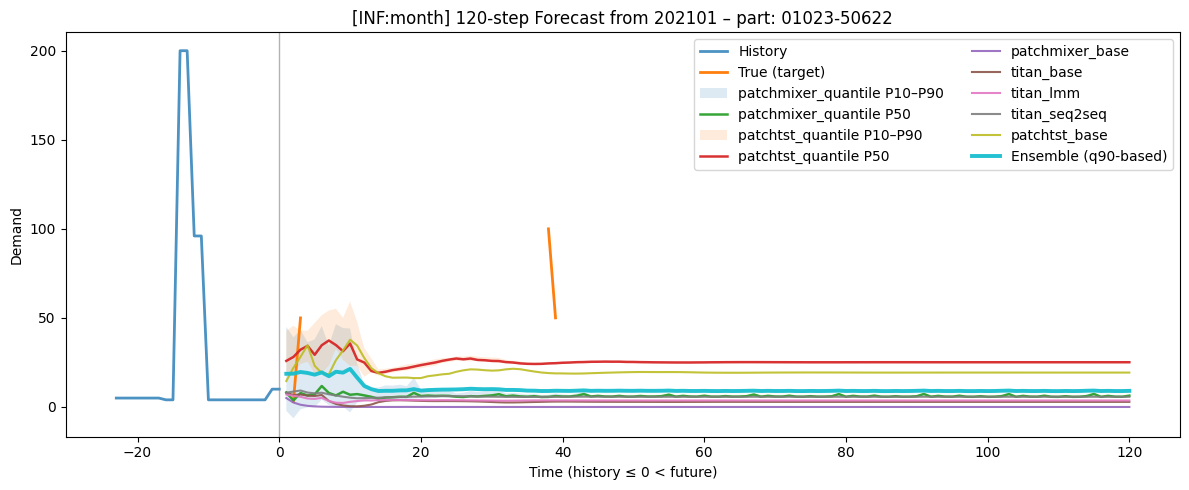

model PatchMixer QuantileModel [DBG] t 0 q10: -0.00362396240234375 q50: 10.25753402709961 q90: 35.748268127441406
model PatchMixer QuantileModel [DBG] t 1 q10: 3.806184768676758 q50: 13.576375007629395 q90: 36.13201141357422
model PatchMixer QuantileModel [DBG] t 2 q10: 4.904572486877441 q50: 15.551383018493652 q90: 36.15629577636719
model PatchMixer QuantileModel [DBG] t 3 q10: 1.4461736679077148 q50: 8.06283187866211 q90: 29.908897399902344
model PatchMixer QuantileModel [DBG] t 4 q10: 3.250369071960449 q50: 9.523611068725586 q90: 33.855812072753906
model PatchTST QuantileModel [DBG] t 0 q10: 14.125247955322266 q50: 16.602489471435547 q90: 17.260805130004883
model PatchTST QuantileModel [DBG] t 1 q10: 14.672629356384277 q50: 15.869129180908203 q90: 19.48605728149414
model PatchTST QuantileModel [DBG] t 2 q10: 14.102761268615723 q50: 15.694673538208008 q90: 19.471345901489258
model PatchTST QuantileModel [DBG] t 3 q10: 14.659003257751465 q50: 16.747472763061523 q90: 18.727258682250977

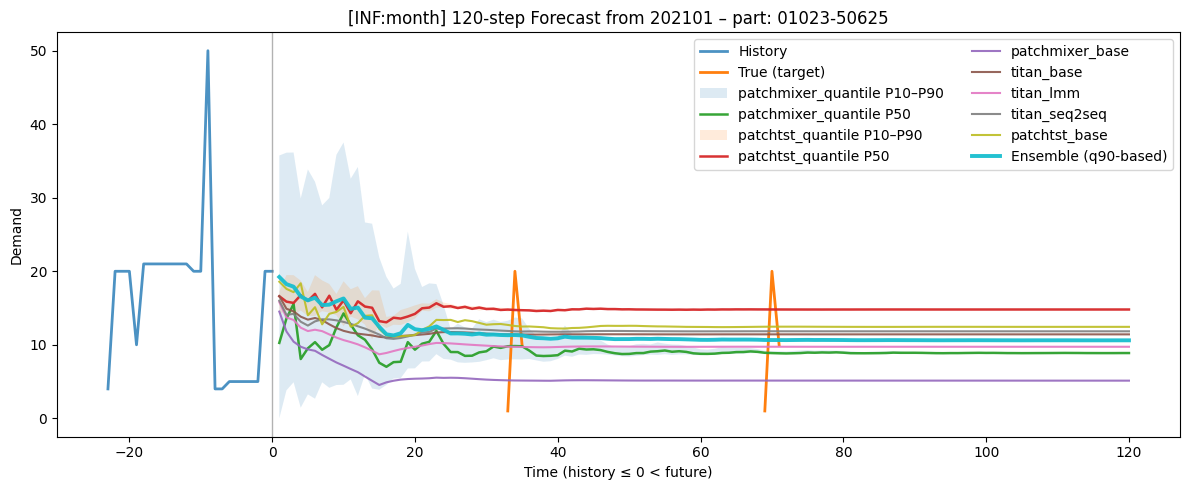

model PatchMixer QuantileModel [DBG] t 0 q10: -609.716064453125 q50: 680.6831665039062 q90: 5768.7568359375
model PatchMixer QuantileModel [DBG] t 1 q10: -450.630859375 q50: 725.8217163085938 q90: 5131.25
model PatchMixer QuantileModel [DBG] t 2 q10: -322.42626953125 q50: 840.0961303710938 q90: 5733.20703125
model PatchMixer QuantileModel [DBG] t 3 q10: -18.2166748046875 q50: 946.5474243164062 q90: 5303.6826171875
model PatchMixer QuantileModel [DBG] t 4 q10: 67.7178955078125 q50: 1130.1153564453125 q90: 5408.51953125
model PatchTST QuantileModel [DBG] t 0 q10: 1425.9451904296875 q50: 1517.8807373046875 q90: 1741.2379150390625
model PatchTST QuantileModel [DBG] t 1 q10: 1439.90234375 q50: 1558.398681640625 q90: 1866.18408203125
model PatchTST QuantileModel [DBG] t 2 q10: 1575.3814697265625 q50: 1742.2232666015625 q90: 1877.0860595703125
model PatchTST QuantileModel [DBG] t 3 q10: 1686.899658203125 q50: 1827.5338134765625 q90: 1890.260009765625
model PatchTST QuantileModel [DBG] t 4 q10

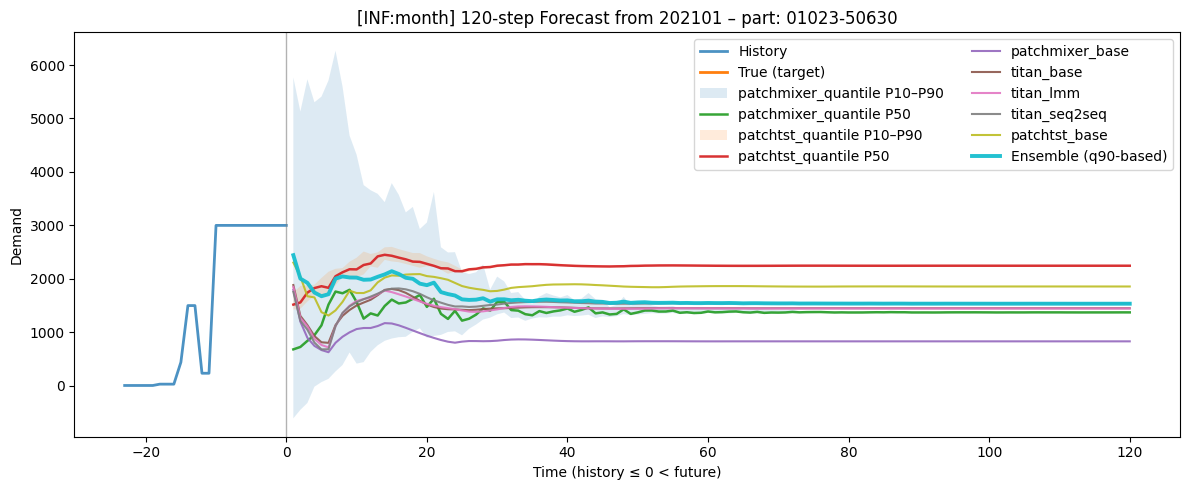

model PatchMixer QuantileModel [DBG] t 0 q10: 30.471115112304688 q50: 45.309181213378906 q90: 98.64051055908203
model PatchMixer QuantileModel [DBG] t 1 q10: 26.549381256103516 q50: 50.191261291503906 q90: 114.59722900390625
model PatchMixer QuantileModel [DBG] t 2 q10: 26.204696655273438 q50: 49.609718322753906 q90: 110.52117919921875
model PatchMixer QuantileModel [DBG] t 3 q10: 26.297115325927734 q50: 50.12947463989258 q90: 114.2689437866211
model PatchMixer QuantileModel [DBG] t 4 q10: 23.73200225830078 q50: 49.610652923583984 q90: 111.27595520019531
model PatchTST QuantileModel [DBG] t 0 q10: 58.02482223510742 q50: 63.02516555786133 q90: 73.56402587890625
model PatchTST QuantileModel [DBG] t 1 q10: 56.227970123291016 q50: 61.91257095336914 q90: 71.04437255859375
model PatchTST QuantileModel [DBG] t 2 q10: 54.936153411865234 q50: 59.81196212768555 q90: 68.5383071899414
model PatchTST QuantileModel [DBG] t 3 q10: 52.787349700927734 q50: 58.05996322631836 q90: 67.72412872314453
model

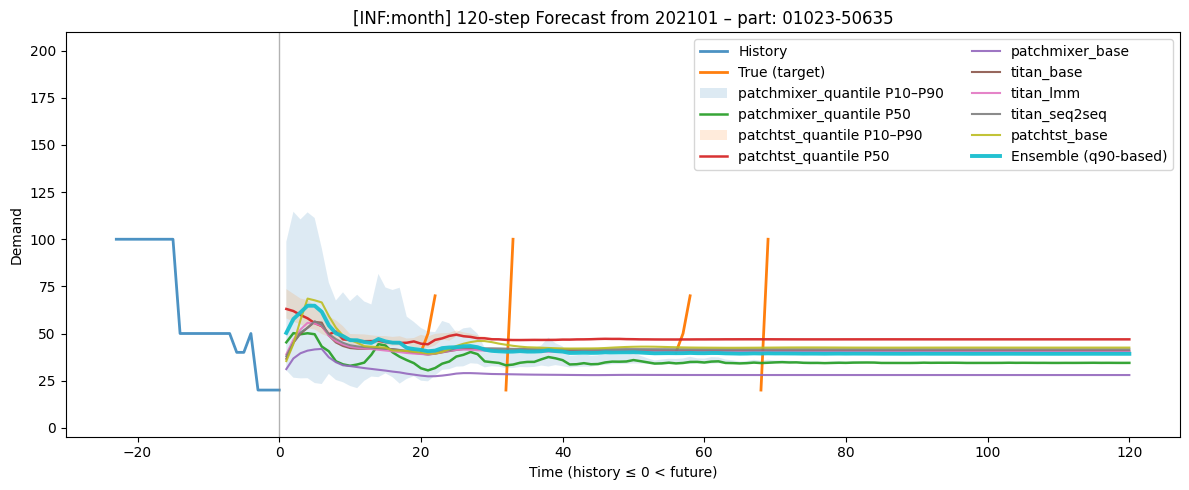

model PatchMixer QuantileModel [DBG] t 0 q10: 16.607118606567383 q50: 30.623310089111328 q90: 67.97154998779297
model PatchMixer QuantileModel [DBG] t 1 q10: 20.11420440673828 q50: 30.986907958984375 q90: 65.66404724121094
model PatchMixer QuantileModel [DBG] t 2 q10: 12.09050178527832 q50: 25.630565643310547 q90: 64.7357406616211
model PatchMixer QuantileModel [DBG] t 3 q10: 13.680191040039062 q50: 28.000883102416992 q90: 70.02726745605469
model PatchMixer QuantileModel [DBG] t 4 q10: 14.897064208984375 q50: 27.389741897583008 q90: 72.28926849365234
model PatchTST QuantileModel [DBG] t 0 q10: 33.17770004272461 q50: 34.646942138671875 q90: 39.64595031738281
model PatchTST QuantileModel [DBG] t 1 q10: 30.453105926513672 q50: 36.24186325073242 q90: 40.375762939453125
model PatchTST QuantileModel [DBG] t 2 q10: 31.60198402404785 q50: 33.929603576660156 q90: 39.82372283935547
model PatchTST QuantileModel [DBG] t 3 q10: 31.95026206970215 q50: 34.703712463378906 q90: 39.838130950927734
model

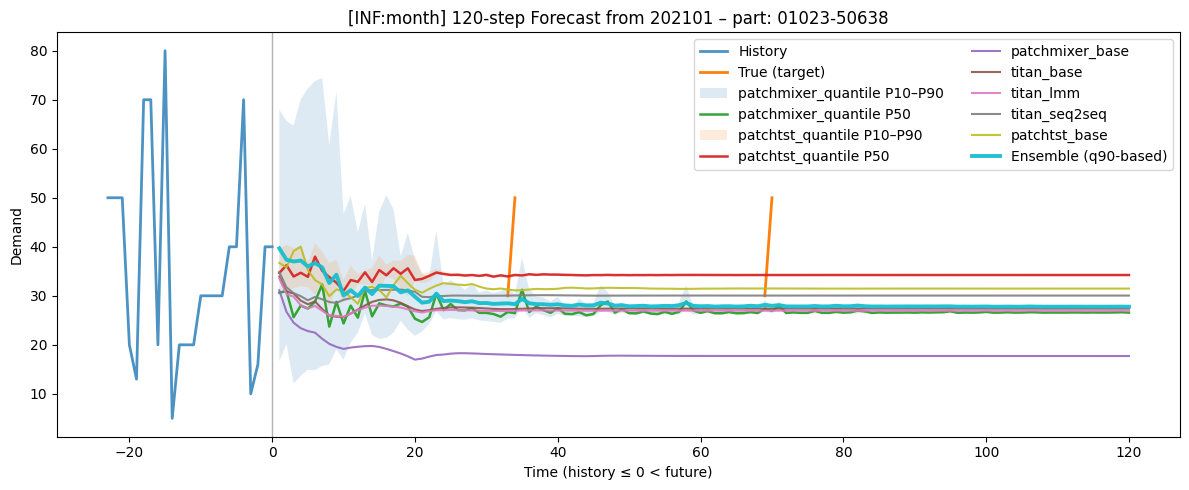

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

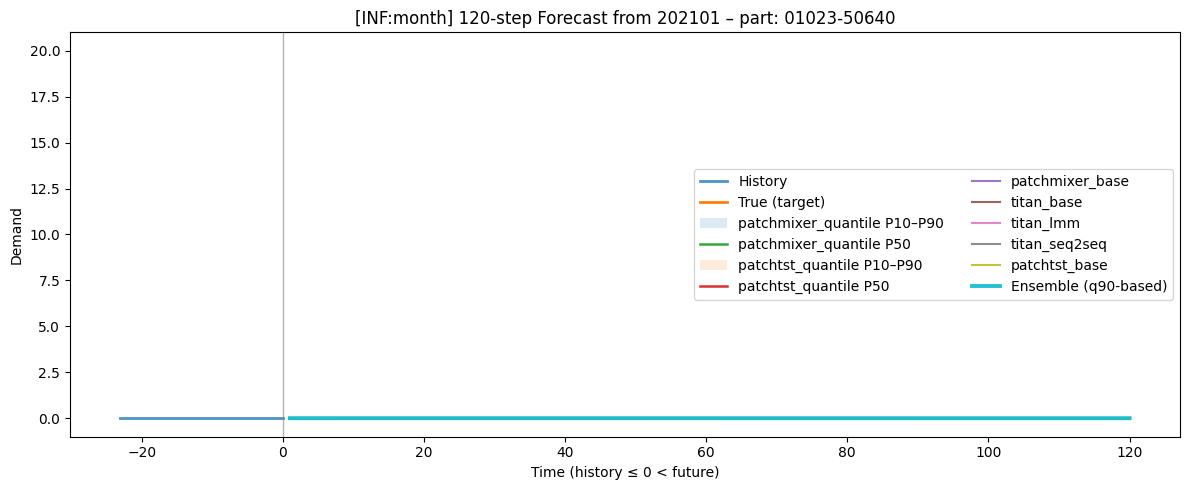

model PatchMixer QuantileModel [DBG] t 0 q10: 1.8769912719726562 q50: 12.491496086120605 q90: 61.848079681396484
model PatchMixer QuantileModel [DBG] t 1 q10: 3.323863983154297 q50: 17.723522186279297 q90: 75.65899658203125
model PatchMixer QuantileModel [DBG] t 2 q10: 4.433012008666992 q50: 14.908086776733398 q90: 58.018245697021484
model PatchMixer QuantileModel [DBG] t 3 q10: 7.964899063110352 q50: 25.088848114013672 q90: 71.34640502929688
model PatchMixer QuantileModel [DBG] t 4 q10: 6.727518081665039 q50: 19.983051300048828 q90: 62.980743408203125
model PatchTST QuantileModel [DBG] t 0 q10: 19.503219604492188 q50: 21.15566062927246 q90: 24.57219696044922
model PatchTST QuantileModel [DBG] t 1 q10: 20.45417022705078 q50: 22.185949325561523 q90: 25.076152801513672
model PatchTST QuantileModel [DBG] t 2 q10: 21.119661331176758 q50: 23.160533905029297 q90: 25.816072463989258
model PatchTST QuantileModel [DBG] t 3 q10: 21.752344131469727 q50: 22.829200744628906 q90: 26.701684951782227


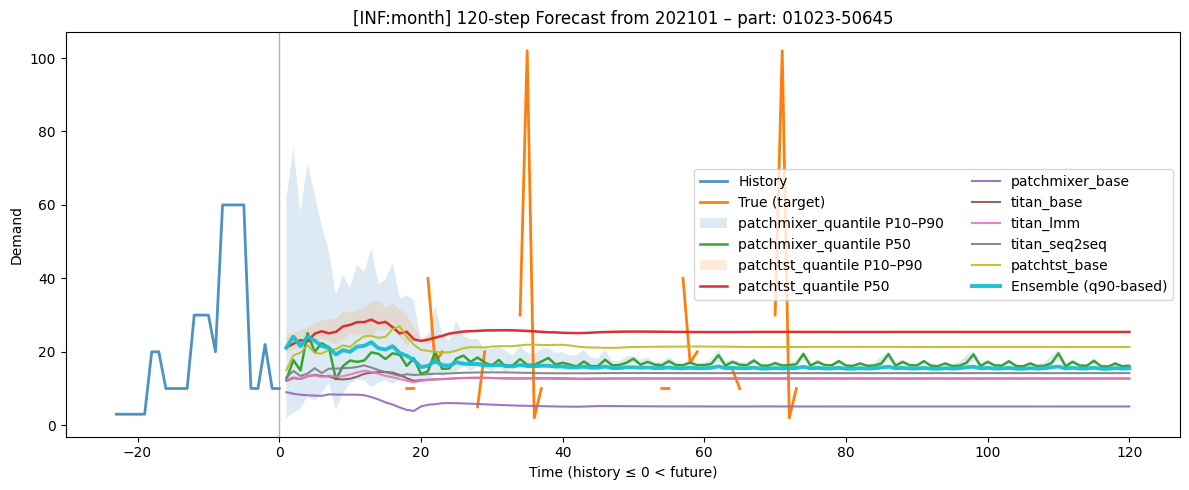

model PatchMixer QuantileModel [DBG] t 0 q10: -2.5094757080078125 q50: 0.5741887092590332 q90: 11.82442855834961
model PatchMixer QuantileModel [DBG] t 1 q10: -2.21580171585083 q50: 1.2268519401550293 q90: 8.129937171936035
model PatchMixer QuantileModel [DBG] t 2 q10: -1.8267788887023926 q50: 1.1548810005187988 q90: 12.089508056640625
model PatchMixer QuantileModel [DBG] t 3 q10: -2.4506845474243164 q50: -0.2657957077026367 q90: 10.71120548248291
model PatchMixer QuantileModel [DBG] t 4 q10: -2.841547966003418 q50: 0.3795967102050781 q90: 15.981466293334961
model PatchTST QuantileModel [DBG] t 0 q10: 4.454512596130371 q50: 4.8800458908081055 q90: 10.069341659545898
model PatchTST QuantileModel [DBG] t 1 q10: 4.8123674392700195 q50: 5.975481986999512 q90: 10.04493236541748
model PatchTST QuantileModel [DBG] t 2 q10: 5.163381099700928 q50: 6.288199424743652 q90: 10.13354206085205
model PatchTST QuantileModel [DBG] t 3 q10: 5.531861305236816 q50: 7.046767234802246 q90: 10.358051300048828

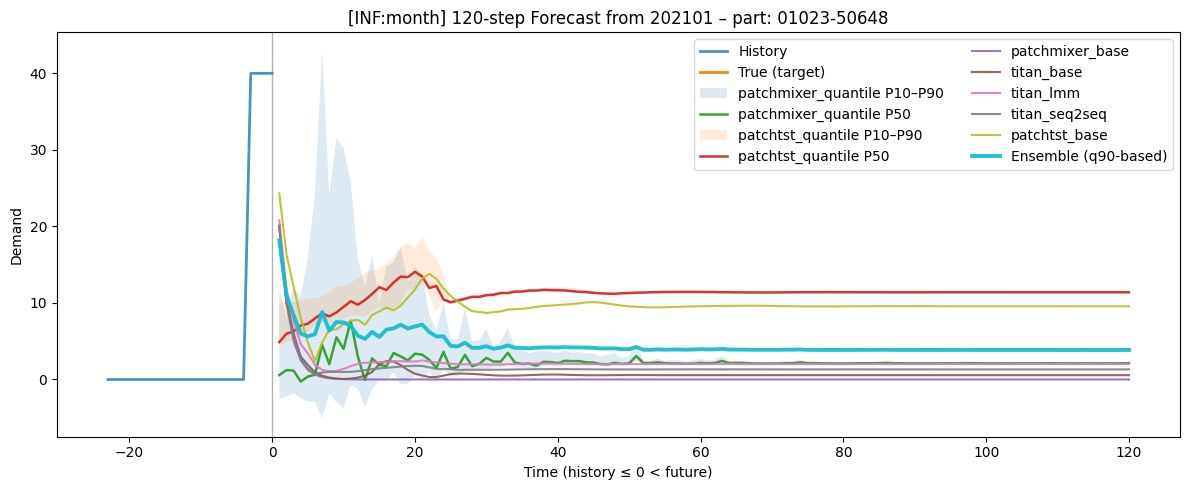

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

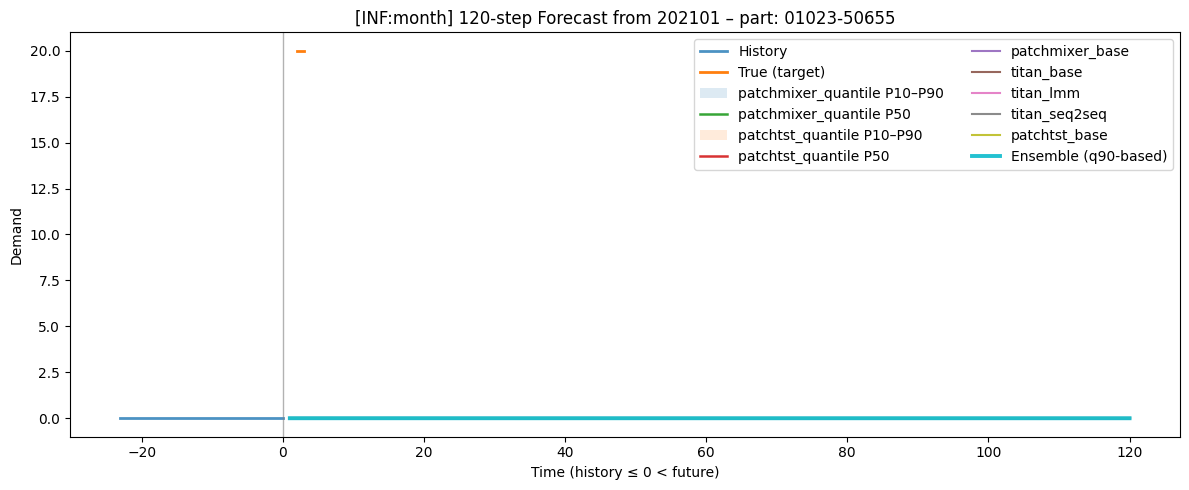

model PatchMixer QuantileModel [DBG] t 0 q10: 6.156473636627197 q50: 11.949848175048828 q90: 27.603260040283203
model PatchMixer QuantileModel [DBG] t 1 q10: 5.049960136413574 q50: 11.160900115966797 q90: 26.14590072631836
model PatchMixer QuantileModel [DBG] t 2 q10: 4.871464729309082 q50: 10.048089981079102 q90: 25.62688446044922
model PatchMixer QuantileModel [DBG] t 3 q10: 5.7803802490234375 q50: 10.802604675292969 q90: 25.26336669921875
model PatchMixer QuantileModel [DBG] t 4 q10: 5.8249192237854 q50: 10.74040699005127 q90: 25.058879852294922
model PatchTST QuantileModel [DBG] t 0 q10: 12.223986625671387 q50: 13.275481224060059 q90: 14.58297061920166
model PatchTST QuantileModel [DBG] t 1 q10: 12.101733207702637 q50: 13.053303718566895 q90: 14.728009223937988
model PatchTST QuantileModel [DBG] t 2 q10: 12.379374504089355 q50: 13.762370109558105 q90: 15.443632125854492
model PatchTST QuantileModel [DBG] t 3 q10: 13.19124698638916 q50: 13.630793571472168 q90: 15.028953552246094
mod

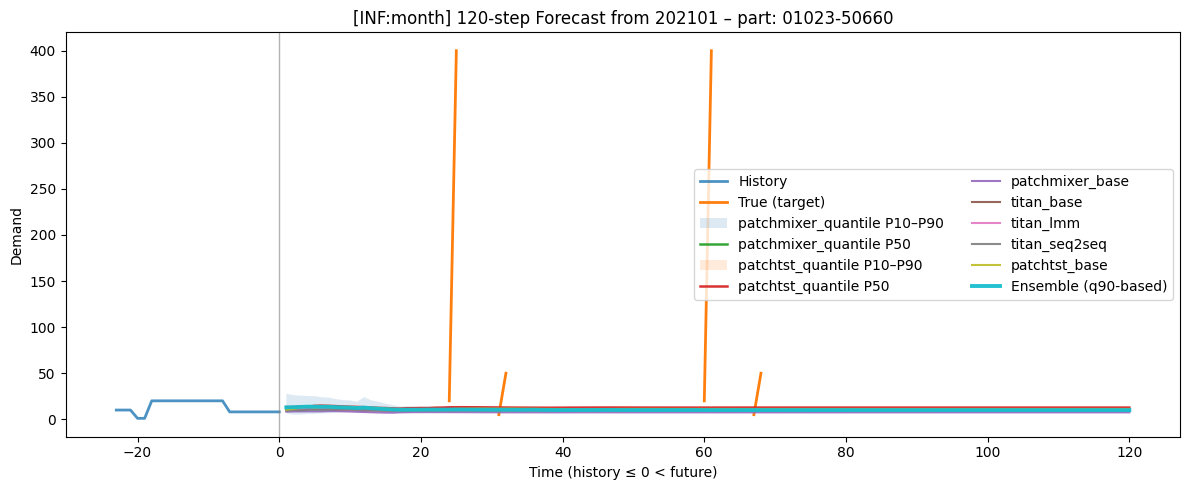

model PatchMixer QuantileModel [DBG] t 0 q10: 11.514511108398438 q50: 15.374228477478027 q90: 30.012359619140625
model PatchMixer QuantileModel [DBG] t 1 q10: 12.463519096374512 q50: 15.350163459777832 q90: 27.118213653564453
model PatchMixer QuantileModel [DBG] t 2 q10: 13.575946807861328 q50: 16.45269203186035 q90: 27.101669311523438
model PatchMixer QuantileModel [DBG] t 3 q10: 14.987919807434082 q50: 16.939350128173828 q90: 26.319538116455078
model PatchMixer QuantileModel [DBG] t 4 q10: 15.7745361328125 q50: 17.468036651611328 q90: 25.126575469970703
model PatchTST QuantileModel [DBG] t 0 q10: 17.278486251831055 q50: 18.090726852416992 q90: 18.849918365478516
model PatchTST QuantileModel [DBG] t 1 q10: 17.54979133605957 q50: 17.997941970825195 q90: 19.014711380004883
model PatchTST QuantileModel [DBG] t 2 q10: 17.93330955505371 q50: 18.687110900878906 q90: 19.4420108795166
model PatchTST QuantileModel [DBG] t 3 q10: 18.861589431762695 q50: 19.12982749938965 q90: 19.578269958496094

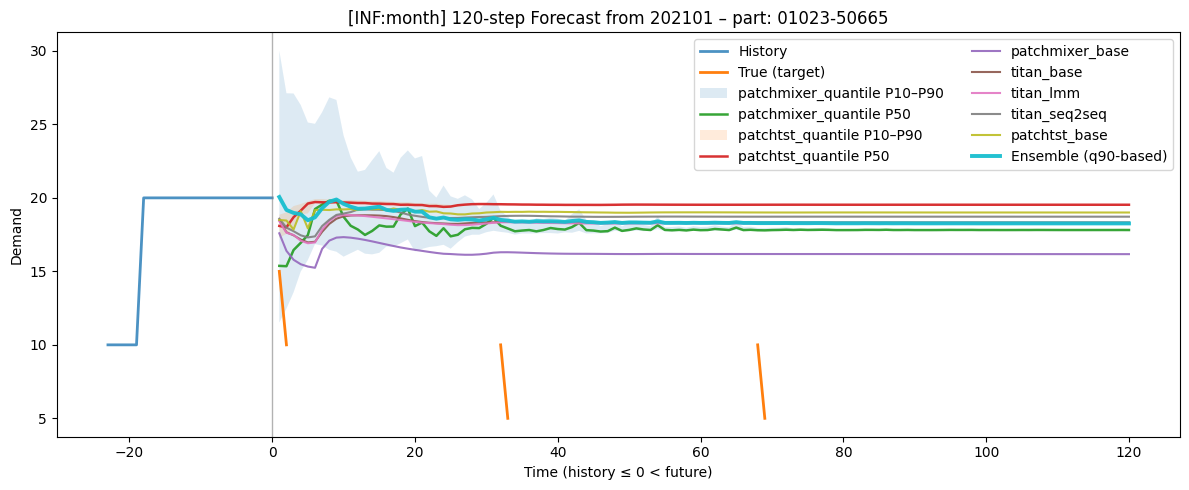

model PatchMixer QuantileModel [DBG] t 0 q10: 7.88510799407959 q50: 13.422298431396484 q90: 33.53963851928711
model PatchMixer QuantileModel [DBG] t 1 q10: 8.760543823242188 q50: 13.091497421264648 q90: 30.639636993408203
model PatchMixer QuantileModel [DBG] t 2 q10: 10.420376777648926 q50: 14.693841934204102 q90: 30.661651611328125
model PatchMixer QuantileModel [DBG] t 3 q10: 12.513617515563965 q50: 15.41797161102295 q90: 29.413991928100586
model PatchMixer QuantileModel [DBG] t 4 q10: 13.729999542236328 q50: 16.217369079589844 q90: 27.521015167236328
model PatchTST QuantileModel [DBG] t 0 q10: 16.209604263305664 q50: 17.218116760253906 q90: 18.417728424072266
model PatchTST QuantileModel [DBG] t 1 q10: 16.330738067626953 q50: 17.00015640258789 q90: 18.52297019958496
model PatchTST QuantileModel [DBG] t 2 q10: 16.902484893798828 q50: 18.03566551208496 q90: 19.16519546508789
model PatchTST QuantileModel [DBG] t 3 q10: 18.295429229736328 q50: 18.695327758789062 q90: 19.372909545898438


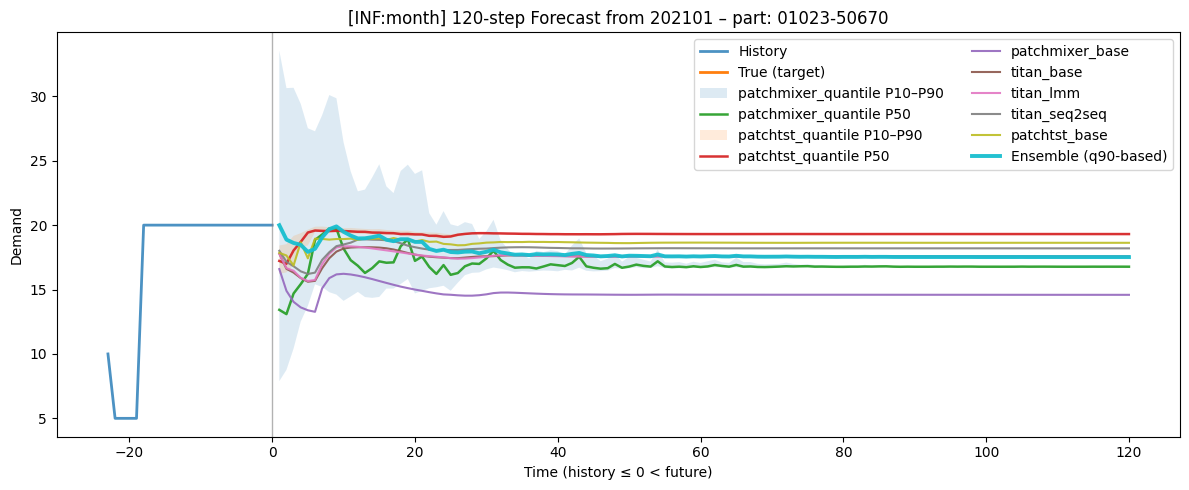

model PatchMixer QuantileModel [DBG] t 0 q10: 9.620058059692383 q50: 11.850409507751465 q90: 21.547828674316406
model PatchMixer QuantileModel [DBG] t 1 q10: 11.057405471801758 q50: 12.565590858459473 q90: 18.539520263671875
model PatchMixer QuantileModel [DBG] t 2 q10: 11.681085586547852 q50: 13.19920539855957 q90: 18.524494171142578
model PatchMixer QuantileModel [DBG] t 3 q10: 12.411442756652832 q50: 13.447821617126465 q90: 18.350236892700195
model PatchMixer QuantileModel [DBG] t 4 q10: 12.739288330078125 q50: 13.68612003326416 q90: 17.81206512451172
model PatchTST QuantileModel [DBG] t 0 q10: 13.291805267333984 q50: 13.963719367980957 q90: 14.351699829101562
model PatchTST QuantileModel [DBG] t 1 q10: 13.768890380859375 q50: 13.995757102966309 q90: 14.506447792053223
model PatchTST QuantileModel [DBG] t 2 q10: 13.964144706726074 q50: 14.338607788085938 q90: 14.718823432922363
model PatchTST QuantileModel [DBG] t 3 q10: 14.42773723602295 q50: 14.564264297485352 q90: 14.783666610717

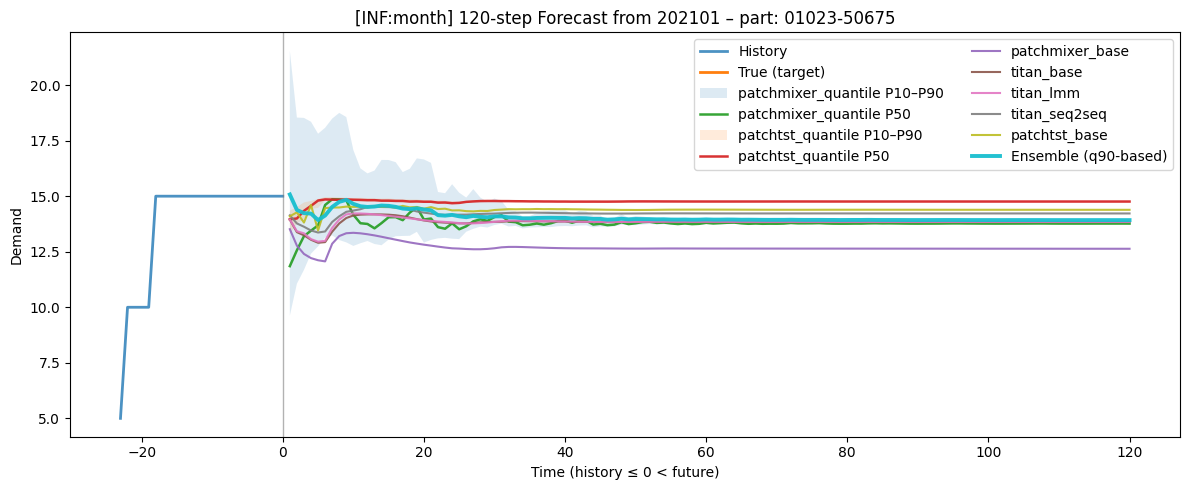

model PatchMixer QuantileModel [DBG] t 0 q10: 2.9498209953308105 q50: 6.94822359085083 q90: 21.065855026245117
model PatchMixer QuantileModel [DBG] t 1 q10: 2.238882064819336 q50: 6.6044602394104 q90: 20.36431121826172
model PatchMixer QuantileModel [DBG] t 2 q10: 2.3519630432128906 q50: 6.680279731750488 q90: 18.574365615844727
model PatchMixer QuantileModel [DBG] t 3 q10: 2.496889114379883 q50: 9.277992248535156 q90: 24.105525970458984
model PatchMixer QuantileModel [DBG] t 4 q10: 1.6446738243103027 q50: 8.829618453979492 q90: 23.315330505371094
model PatchTST QuantileModel [DBG] t 0 q10: 7.124026298522949 q50: 7.6154937744140625 q90: 8.302395820617676
model PatchTST QuantileModel [DBG] t 1 q10: 7.2754740715026855 q50: 7.520568370819092 q90: 7.8717498779296875
model PatchTST QuantileModel [DBG] t 2 q10: 6.9660210609436035 q50: 7.451791763305664 q90: 8.280431747436523
model PatchTST QuantileModel [DBG] t 3 q10: 6.79992151260376 q50: 7.368514060974121 q90: 8.513163566589355
model Patch

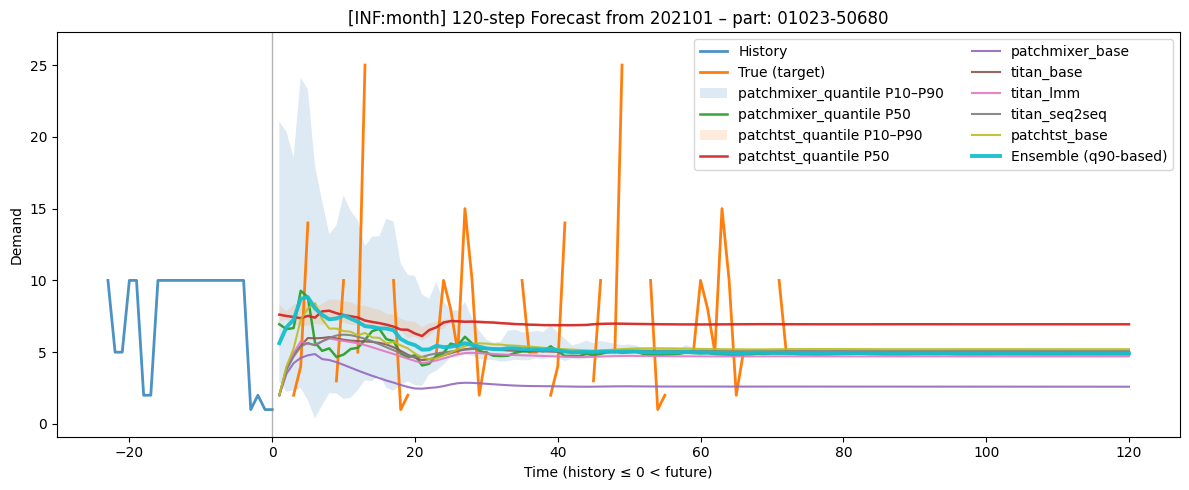

model PatchMixer QuantileModel [DBG] t 0 q10: -103.94802856445312 q50: 73.64569091796875 q90: 838.8489990234375
model PatchMixer QuantileModel [DBG] t 1 q10: -74.49551391601562 q50: 146.36424255371094 q90: 1239.16357421875
model PatchMixer QuantileModel [DBG] t 2 q10: -87.12966918945312 q50: 542.6532592773438 q90: 2436.38720703125
model PatchMixer QuantileModel [DBG] t 3 q10: -96.2152099609375 q50: 214.72207641601562 q90: 1337.670166015625
model PatchMixer QuantileModel [DBG] t 4 q10: 104.21139526367188 q50: 475.7702941894531 q90: 1410.173095703125
model PatchTST QuantileModel [DBG] t 0 q10: 320.0450439453125 q50: 385.6972961425781 q90: 520.552490234375
model PatchTST QuantileModel [DBG] t 1 q10: 335.6514587402344 q50: 412.6081237792969 q90: 528.6605834960938
model PatchTST QuantileModel [DBG] t 2 q10: 364.4862365722656 q50: 430.89971923828125 q90: 555.7645263671875
model PatchTST QuantileModel [DBG] t 3 q10: 367.2608947753906 q50: 401.07647705078125 q90: 540.6541748046875
model PatchT

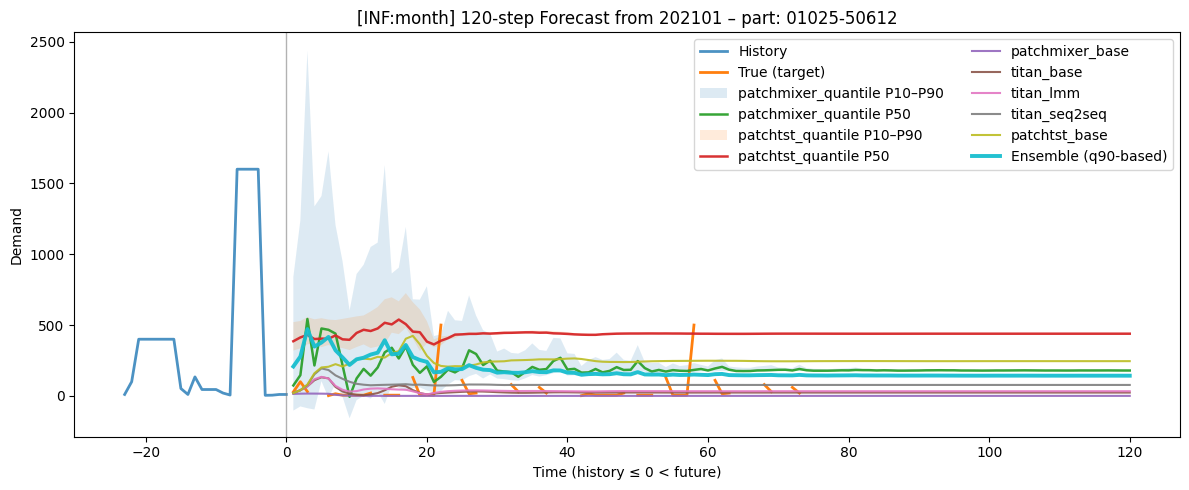

model PatchMixer QuantileModel [DBG] t 0 q10: -205.789306640625 q50: 128.06649780273438 q90: 1974.641357421875
model PatchMixer QuantileModel [DBG] t 1 q10: -96.287109375 q50: 196.8367919921875 q90: 1724.4898681640625
model PatchMixer QuantileModel [DBG] t 2 q10: -142.39947509765625 q50: 232.77621459960938 q90: 2021.0440673828125
model PatchMixer QuantileModel [DBG] t 3 q10: -160.56146240234375 q50: 269.49200439453125 q90: 2260.791748046875
model PatchMixer QuantileModel [DBG] t 4 q10: -175.725830078125 q50: 379.5825500488281 q90: 2407.0693359375
model PatchTST QuantileModel [DBG] t 0 q10: 562.4807739257812 q50: 590.4007568359375 q90: 768.8914794921875
model PatchTST QuantileModel [DBG] t 1 q10: 596.189453125 q50: 665.4480590820312 q90: 785.9076538085938
model PatchTST QuantileModel [DBG] t 2 q10: 634.0161743164062 q50: 687.0206909179688 q90: 801.078125
model PatchTST QuantileModel [DBG] t 3 q10: 656.716064453125 q50: 729.8101806640625 q90: 841.1463012695312
model PatchTST QuantileMode

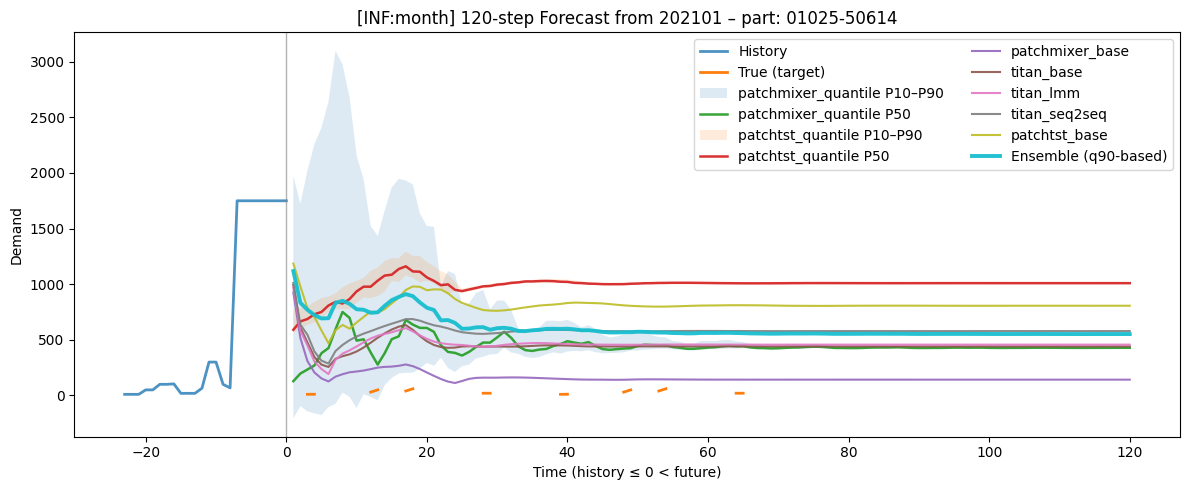

model PatchMixer QuantileModel [DBG] t 0 q10: 18.03594970703125 q50: 46.361663818359375 q90: 136.03079223632812
model PatchMixer QuantileModel [DBG] t 1 q10: 23.59457015991211 q50: 56.46798324584961 q90: 138.24200439453125
model PatchMixer QuantileModel [DBG] t 2 q10: 24.555381774902344 q50: 62.513023376464844 q90: 159.63414001464844
model PatchMixer QuantileModel [DBG] t 3 q10: 30.372447967529297 q50: 49.01176071166992 q90: 114.00151062011719
model PatchMixer QuantileModel [DBG] t 4 q10: 29.557907104492188 q50: 50.307106018066406 q90: 123.17269134521484
model PatchTST QuantileModel [DBG] t 0 q10: 71.89280700683594 q50: 82.08345794677734 q90: 93.57199096679688
model PatchTST QuantileModel [DBG] t 1 q10: 71.59114837646484 q50: 85.40756225585938 q90: 93.56185150146484
model PatchTST QuantileModel [DBG] t 2 q10: 75.98379516601562 q50: 80.47508239746094 q90: 95.1663589477539
model PatchTST QuantileModel [DBG] t 3 q10: 70.48006439208984 q50: 78.92762756347656 q90: 89.9604263305664
model Pat

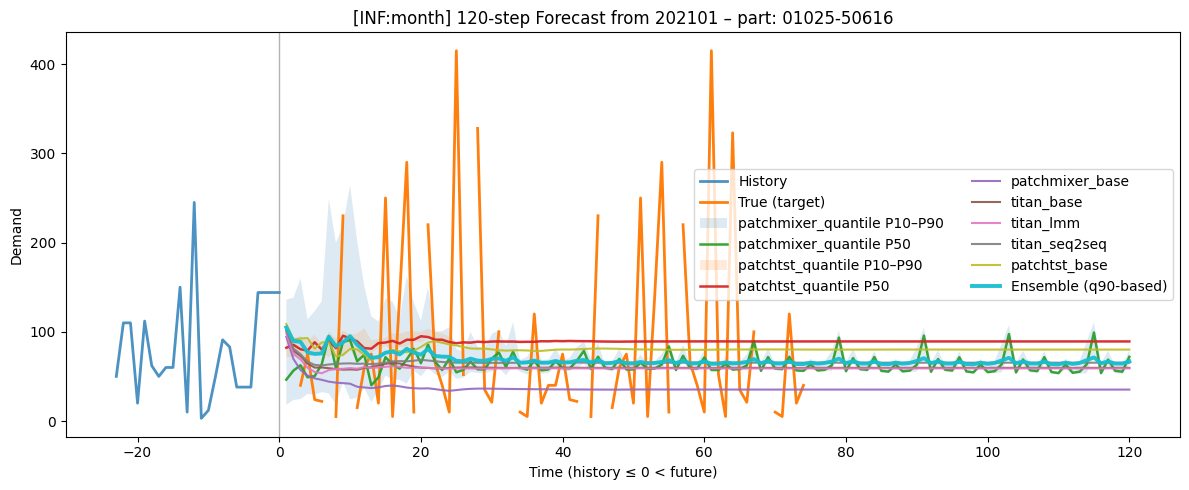

model PatchMixer QuantileModel [DBG] t 0 q10: 5.46898078918457 q50: 7.552500247955322 q90: 14.510740280151367
model PatchMixer QuantileModel [DBG] t 1 q10: 6.206223964691162 q50: 7.7566423416137695 q90: 13.637092590332031
model PatchMixer QuantileModel [DBG] t 2 q10: 6.4090070724487305 q50: 7.99735689163208 q90: 13.955296516418457
model PatchMixer QuantileModel [DBG] t 3 q10: 6.782954692840576 q50: 8.112041473388672 q90: 13.290428161621094
model PatchMixer QuantileModel [DBG] t 4 q10: 7.233211994171143 q50: 8.39195728302002 q90: 13.25265121459961
model PatchTST QuantileModel [DBG] t 0 q10: 8.691483497619629 q50: 8.96370792388916 q90: 9.137024879455566
model PatchTST QuantileModel [DBG] t 1 q10: 8.805093765258789 q50: 9.030672073364258 q90: 9.218892097473145
model PatchTST QuantileModel [DBG] t 2 q10: 8.805998802185059 q50: 9.145309448242188 q90: 9.490471839904785
model PatchTST QuantileModel [DBG] t 3 q10: 8.960627555847168 q50: 9.138015747070312 q90: 9.519623756408691
model PatchTST Q

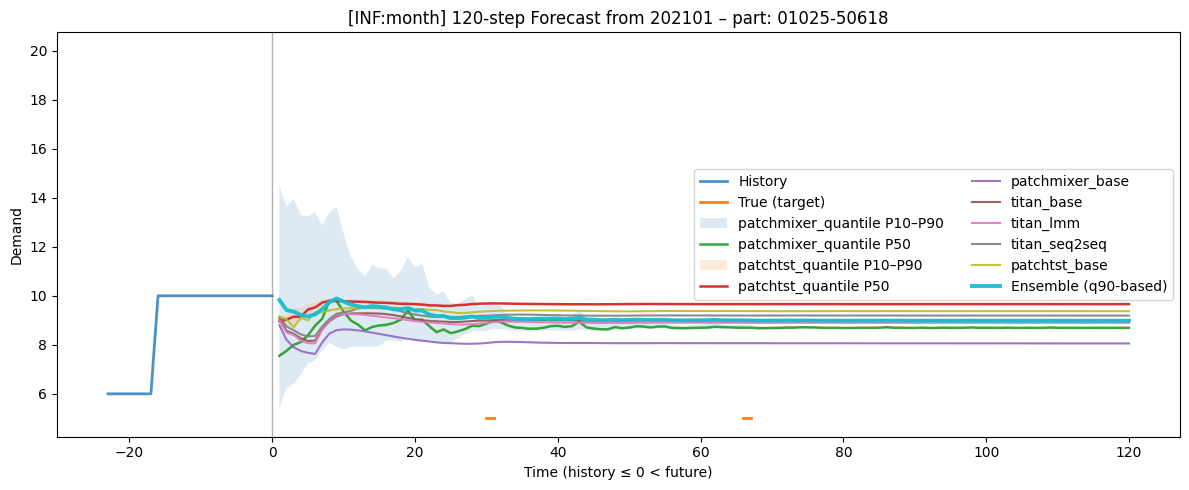

model PatchMixer QuantileModel [DBG] t 0 q10: -15.330131530761719 q50: 18.234481811523438 q90: 152.44497680664062
model PatchMixer QuantileModel [DBG] t 1 q10: -22.442535400390625 q50: 29.64904022216797 q90: 212.66360473632812
model PatchMixer QuantileModel [DBG] t 2 q10: 8.123069763183594 q50: 33.01482391357422 q90: 118.83807373046875
model PatchMixer QuantileModel [DBG] t 3 q10: -7.250419616699219 q50: 23.396812438964844 q90: 100.67687225341797
model PatchMixer QuantileModel [DBG] t 4 q10: -39.09721374511719 q50: 11.545799255371094 q90: 88.84793853759766
model PatchTST QuantileModel [DBG] t 0 q10: 64.44178771972656 q50: 74.38465118408203 q90: 168.64877319335938
model PatchTST QuantileModel [DBG] t 1 q10: 44.54404067993164 q50: 114.11820220947266 q90: 174.01263427734375
model PatchTST QuantileModel [DBG] t 2 q10: 70.98526000976562 q50: 82.88370513916016 q90: 158.44529724121094
model PatchTST QuantileModel [DBG] t 3 q10: 47.25489044189453 q50: 95.63423919677734 q90: 179.6834716796875
m

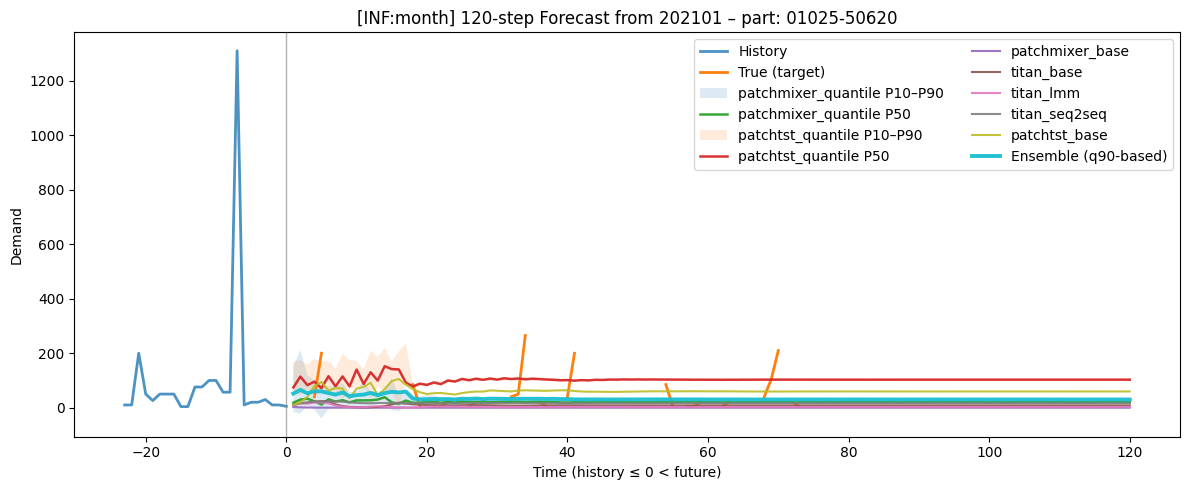

model PatchMixer QuantileModel [DBG] t 0 q10: 1.224405288696289 q50: 10.081521987915039 q90: 51.55479049682617
model PatchMixer QuantileModel [DBG] t 1 q10: 4.654670715332031 q50: 17.533119201660156 q90: 67.39588165283203
model PatchMixer QuantileModel [DBG] t 2 q10: -0.3948707580566406 q50: 12.507465362548828 q90: 55.91096878051758
model PatchMixer QuantileModel [DBG] t 3 q10: 2.9693126678466797 q50: 8.995748519897461 q90: 35.473976135253906
model PatchMixer QuantileModel [DBG] t 4 q10: 4.675775527954102 q50: 8.282292366027832 q90: 24.544754028320312
model PatchTST QuantileModel [DBG] t 0 q10: 22.10386848449707 q50: 24.139097213745117 q90: 33.21189880371094
model PatchTST QuantileModel [DBG] t 1 q10: 18.700613021850586 q50: 19.413455963134766 q90: 30.14105224609375
model PatchTST QuantileModel [DBG] t 2 q10: 13.541608810424805 q50: 25.085168838500977 q90: 35.72254943847656
model PatchTST QuantileModel [DBG] t 3 q10: 16.4722900390625 q50: 16.714763641357422 q90: 29.36363410949707
model

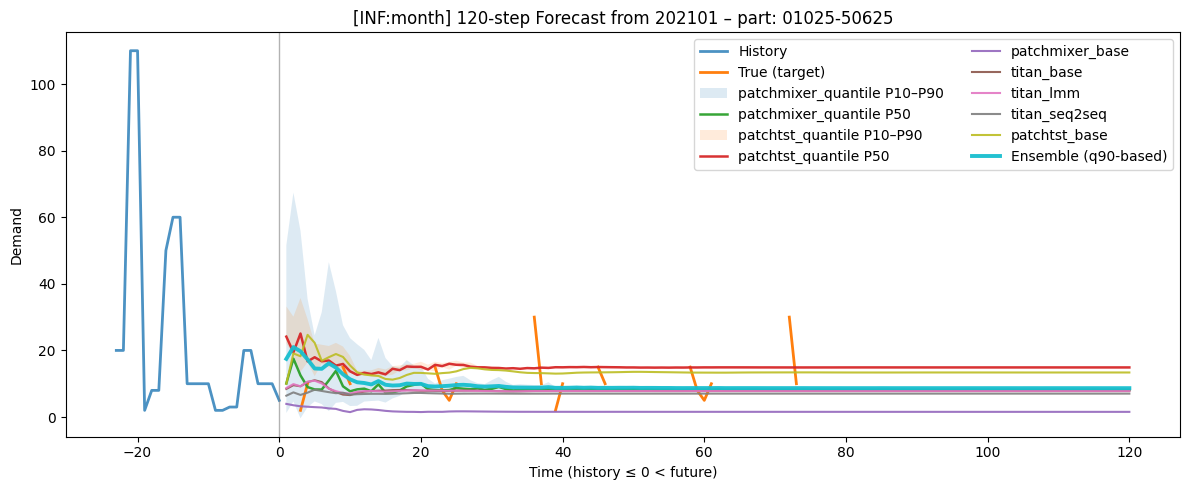

model PatchMixer QuantileModel [DBG] t 0 q10: 15.210163116455078 q50: 35.69393539428711 q90: 122.19468688964844
model PatchMixer QuantileModel [DBG] t 1 q10: 14.551631927490234 q50: 44.690032958984375 q90: 140.92564392089844
model PatchMixer QuantileModel [DBG] t 2 q10: 6.157627105712891 q50: 41.81916427612305 q90: 152.70474243164062
model PatchMixer QuantileModel [DBG] t 3 q10: 8.671955108642578 q50: 48.234893798828125 q90: 145.7899169921875
model PatchMixer QuantileModel [DBG] t 4 q10: 25.237150192260742 q50: 74.85064697265625 q90: 168.68856811523438
model PatchTST QuantileModel [DBG] t 0 q10: 46.948062896728516 q50: 48.04328155517578 q90: 57.14204788208008
model PatchTST QuantileModel [DBG] t 1 q10: 44.61253356933594 q50: 51.18390655517578 q90: 58.85308837890625
model PatchTST QuantileModel [DBG] t 2 q10: 49.90542984008789 q50: 50.039913177490234 q90: 57.937591552734375
model PatchTST QuantileModel [DBG] t 3 q10: 47.0952262878418 q50: 52.49465560913086 q90: 55.83333206176758
model P

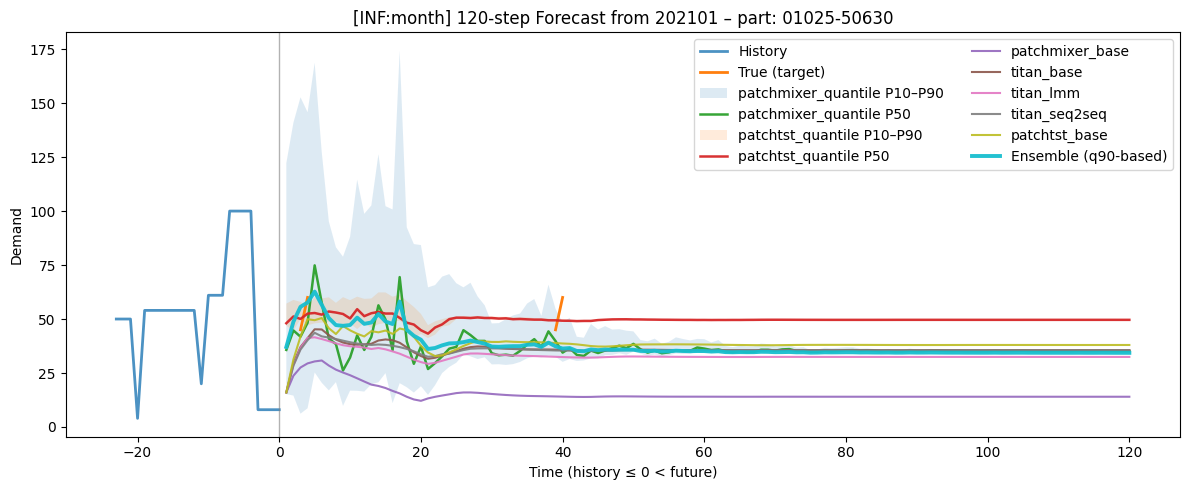

model PatchMixer QuantileModel [DBG] t 0 q10: 0.015685319900512695 q50: 1.647080421447754 q90: 8.843770980834961
model PatchMixer QuantileModel [DBG] t 1 q10: 0.6355986595153809 q50: 1.5210728645324707 q90: 5.939332485198975
model PatchMixer QuantileModel [DBG] t 2 q10: 1.065323829650879 q50: 1.6746565103530884 q90: 4.434149742126465
model PatchMixer QuantileModel [DBG] t 3 q10: 1.1276010274887085 q50: 1.4385045766830444 q90: 2.2410829067230225
model PatchMixer QuantileModel [DBG] t 4 q10: 0.8961499929428101 q50: 1.2829880714416504 q90: 1.636394739151001
model PatchTST QuantileModel [DBG] t 0 q10: 2.301504135131836 q50: 3.8235397338867188 q90: 5.511168956756592
model PatchTST QuantileModel [DBG] t 1 q10: 2.6428728103637695 q50: 3.1807057857513428 q90: 4.879464626312256
model PatchTST QuantileModel [DBG] t 2 q10: 2.2592384815216064 q50: 3.2004973888397217 q90: 4.831011772155762
model PatchTST QuantileModel [DBG] t 3 q10: 1.4325085878372192 q50: 2.6177544593811035 q90: 3.8882980346679688

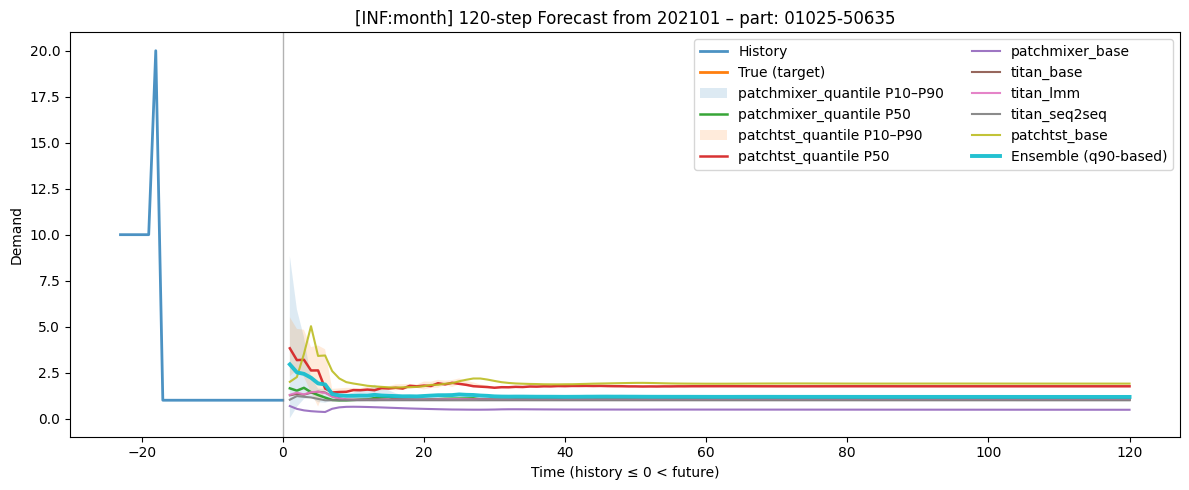

model PatchMixer QuantileModel [DBG] t 0 q10: 3.6090641021728516 q50: 10.612129211425781 q90: 33.29330062866211
model PatchMixer QuantileModel [DBG] t 1 q10: 6.918231964111328 q50: 12.138956069946289 q90: 33.685791015625
model PatchMixer QuantileModel [DBG] t 2 q10: 4.275684356689453 q50: 11.657097816467285 q90: 44.745243072509766
model PatchMixer QuantileModel [DBG] t 3 q10: 7.1465911865234375 q50: 11.119169235229492 q90: 43.6922607421875
model PatchMixer QuantileModel [DBG] t 4 q10: 4.058309555053711 q50: 12.573772430419922 q90: 62.83959197998047
model PatchTST QuantileModel [DBG] t 0 q10: 20.346698760986328 q50: 21.994352340698242 q90: 27.759410858154297
model PatchTST QuantileModel [DBG] t 1 q10: 21.044912338256836 q50: 22.257110595703125 q90: 27.810558319091797
model PatchTST QuantileModel [DBG] t 2 q10: 20.79224395751953 q50: 23.25185775756836 q90: 29.058013916015625
model PatchTST QuantileModel [DBG] t 3 q10: 22.090627670288086 q50: 23.776729583740234 q90: 29.473926544189453
mod

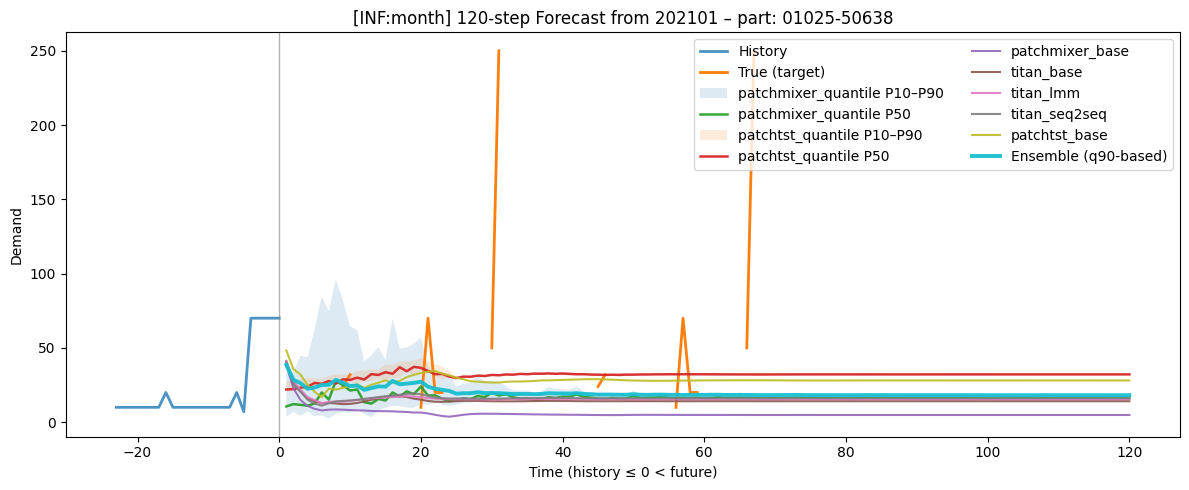

model PatchMixer QuantileModel [DBG] t 0 q10: 2.999246120452881 q50: 2.999420642852783 q90: 2.9997384548187256
model PatchMixer QuantileModel [DBG] t 1 q10: 2.999204397201538 q50: 2.999377965927124 q90: 2.9997034072875977
model PatchMixer QuantileModel [DBG] t 2 q10: 2.999166965484619 q50: 2.9993584156036377 q90: 2.9997172355651855
model PatchMixer QuantileModel [DBG] t 3 q10: 2.999121904373169 q50: 2.999293327331543 q90: 2.999746322631836
model PatchMixer QuantileModel [DBG] t 4 q10: 2.999086618423462 q50: 2.9992756843566895 q90: 2.999699115753174
model PatchTST QuantileModel [DBG] t 0 q10: 2.9991579055786133 q50: 2.9995782375335693 q90: 3.0014750957489014
model PatchTST QuantileModel [DBG] t 1 q10: 2.9991276264190674 q50: 2.9995694160461426 q90: 3.001474618911743
model PatchTST QuantileModel [DBG] t 2 q10: 2.9991116523742676 q50: 2.9995369911193848 q90: 3.001464605331421
model PatchTST QuantileModel [DBG] t 3 q10: 2.999103307723999 q50: 2.9995431900024414 q90: 3.001441717147827
model

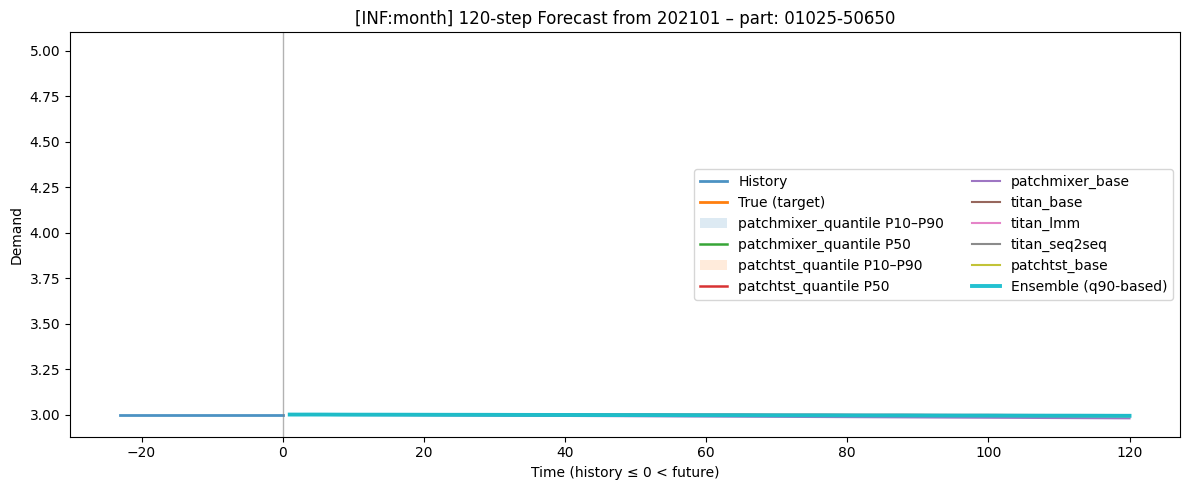

model PatchMixer QuantileModel [DBG] t 0 q10: 8.38022518157959 q50: 11.295242309570312 q90: 14.068284034729004
model PatchMixer QuantileModel [DBG] t 1 q10: 8.56080436706543 q50: 9.467310905456543 q90: 13.317106246948242
model PatchMixer QuantileModel [DBG] t 2 q10: 8.603981018066406 q50: 10.133861541748047 q90: 15.766440391540527
model PatchMixer QuantileModel [DBG] t 3 q10: 9.68411922454834 q50: 10.53954792022705 q90: 11.943015098571777
model PatchMixer QuantileModel [DBG] t 4 q10: 9.189720153808594 q50: 10.508550643920898 q90: 15.627062797546387
model PatchTST QuantileModel [DBG] t 0 q10: 12.857026100158691 q50: 13.619457244873047 q90: 15.73128604888916
model PatchTST QuantileModel [DBG] t 1 q10: 12.016125679016113 q50: 13.723137855529785 q90: 16.363609313964844
model PatchTST QuantileModel [DBG] t 2 q10: 12.34030532836914 q50: 13.475529670715332 q90: 16.474782943725586
model PatchTST QuantileModel [DBG] t 3 q10: 12.66961669921875 q50: 14.633830070495605 q90: 16.787057876586914
mode

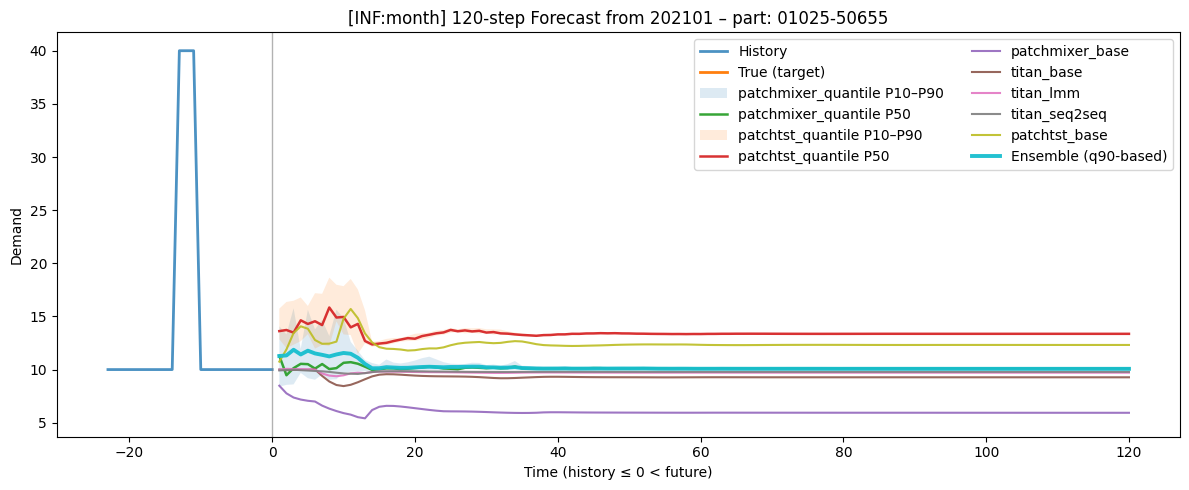

model PatchMixer QuantileModel [DBG] t 0 q10: 8.980201721191406 q50: 11.047187805175781 q90: 20.26521110534668
model PatchMixer QuantileModel [DBG] t 1 q10: 8.732216835021973 q50: 11.699481964111328 q90: 22.59172821044922
model PatchMixer QuantileModel [DBG] t 2 q10: 9.465545654296875 q50: 13.334569931030273 q90: 24.43503761291504
model PatchMixer QuantileModel [DBG] t 3 q10: 8.599264144897461 q50: 11.587946891784668 q90: 21.633298873901367
model PatchMixer QuantileModel [DBG] t 4 q10: 8.719038009643555 q50: 11.349609375 q90: 22.384037017822266
model PatchTST QuantileModel [DBG] t 0 q10: 12.783549308776855 q50: 13.13829517364502 q90: 13.458120346069336
model PatchTST QuantileModel [DBG] t 1 q10: 12.916221618652344 q50: 13.853829383850098 q90: 14.913875579833984
model PatchTST QuantileModel [DBG] t 2 q10: 13.35204029083252 q50: 13.530278205871582 q90: 14.79923152923584
model PatchTST QuantileModel [DBG] t 3 q10: 13.576255798339844 q50: 14.507880210876465 q90: 14.572028160095215
model Pa

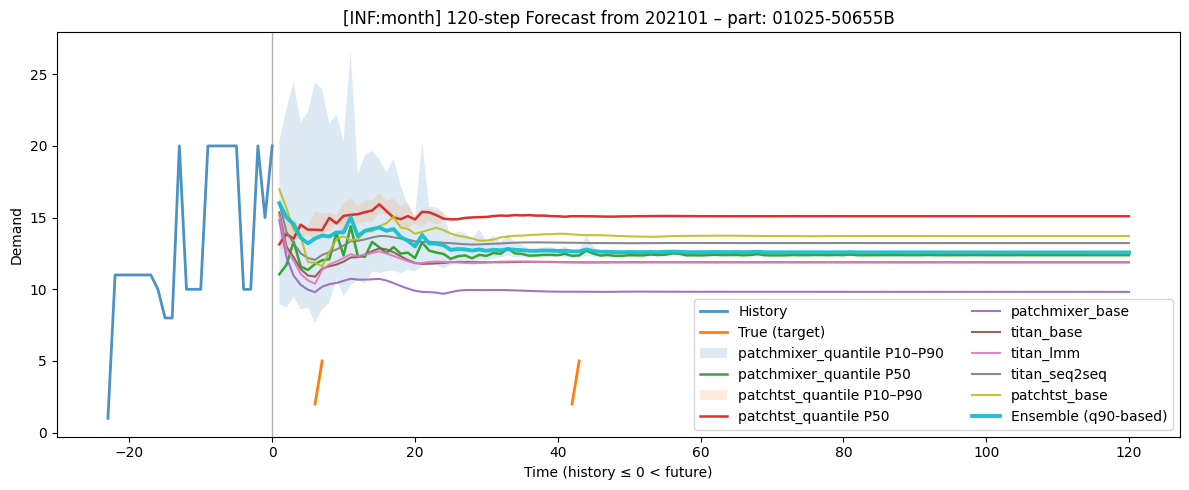

model PatchMixer QuantileModel [DBG] t 0 q10: -16.979248046875 q50: 16.138866424560547 q90: 209.00587463378906
model PatchMixer QuantileModel [DBG] t 1 q10: -13.398406982421875 q50: 22.00287628173828 q90: 192.2593536376953
model PatchMixer QuantileModel [DBG] t 2 q10: -18.791961669921875 q50: 26.056541442871094 q90: 231.61837768554688
model PatchMixer QuantileModel [DBG] t 3 q10: -21.20349884033203 q50: 30.268051147460938 q90: 263.5404052734375
model PatchMixer QuantileModel [DBG] t 4 q10: -16.69731903076172 q50: 47.923118591308594 q90: 284.70477294921875
model PatchTST QuantileModel [DBG] t 0 q10: 65.54090118408203 q50: 68.29267883300781 q90: 88.01543426513672
model PatchTST QuantileModel [DBG] t 1 q10: 68.34141540527344 q50: 76.65857696533203 q90: 91.21056365966797
model PatchTST QuantileModel [DBG] t 2 q10: 72.7505111694336 q50: 78.15867614746094 q90: 92.53446960449219
model PatchTST QuantileModel [DBG] t 3 q10: 75.24017333984375 q50: 84.37418365478516 q90: 96.1731185913086
model Pa

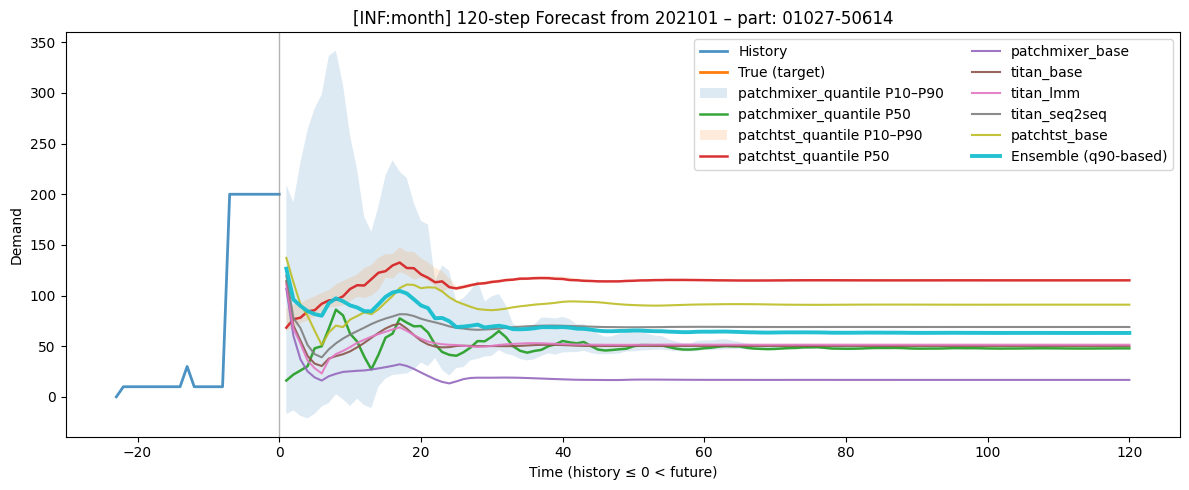

model PatchMixer QuantileModel [DBG] t 0 q10: 2.0546092987060547 q50: 3.941544771194458 q90: 7.668406963348389
model PatchMixer QuantileModel [DBG] t 1 q10: 1.7413691282272339 q50: 3.5538413524627686 q90: 7.610722064971924
model PatchMixer QuantileModel [DBG] t 2 q10: 1.7680456638336182 q50: 3.3676023483276367 q90: 6.876067161560059
model PatchMixer QuantileModel [DBG] t 3 q10: 1.8393752574920654 q50: 3.4324285984039307 q90: 6.85740852355957
model PatchMixer QuantileModel [DBG] t 4 q10: 1.439335823059082 q50: 2.770840644836426 q90: 5.970184326171875
model PatchTST QuantileModel [DBG] t 0 q10: 3.414027690887451 q50: 3.6311683654785156 q90: 3.893118381500244
model PatchTST QuantileModel [DBG] t 1 q10: 3.401702404022217 q50: 3.5605084896087646 q90: 3.8692243099212646
model PatchTST QuantileModel [DBG] t 2 q10: 3.3849377632141113 q50: 3.5503170490264893 q90: 3.9175548553466797
model PatchTST QuantileModel [DBG] t 3 q10: 3.3748226165771484 q50: 3.5330634117126465 q90: 3.8406600952148438
mod

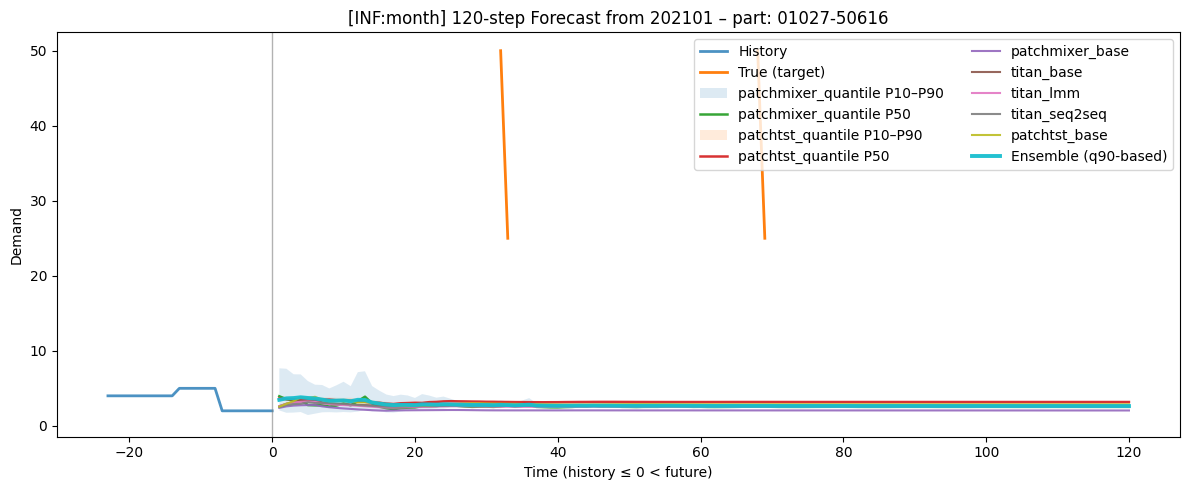

model PatchMixer QuantileModel [DBG] t 0 q10: 22.306875228881836 q50: 27.980403900146484 q90: 42.507198333740234
model PatchMixer QuantileModel [DBG] t 1 q10: 23.18576431274414 q50: 27.915264129638672 q90: 44.246761322021484
model PatchMixer QuantileModel [DBG] t 2 q10: 21.70835304260254 q50: 26.172609329223633 q90: 40.25811004638672
model PatchMixer QuantileModel [DBG] t 3 q10: 19.60125160217285 q50: 29.415210723876953 q90: 52.64844512939453
model PatchMixer QuantileModel [DBG] t 4 q10: 19.652812957763672 q50: 31.24092674255371 q90: 56.614540100097656
model PatchTST QuantileModel [DBG] t 0 q10: 27.911548614501953 q50: 28.813566207885742 q90: 31.803823471069336
model PatchTST QuantileModel [DBG] t 1 q10: 28.149126052856445 q50: 28.933622360229492 q90: 31.28620147705078
model PatchTST QuantileModel [DBG] t 2 q10: 28.20720863342285 q50: 29.04815101623535 q90: 30.962923049926758
model PatchTST QuantileModel [DBG] t 3 q10: 27.942527770996094 q50: 28.738779067993164 q90: 30.884599685668945


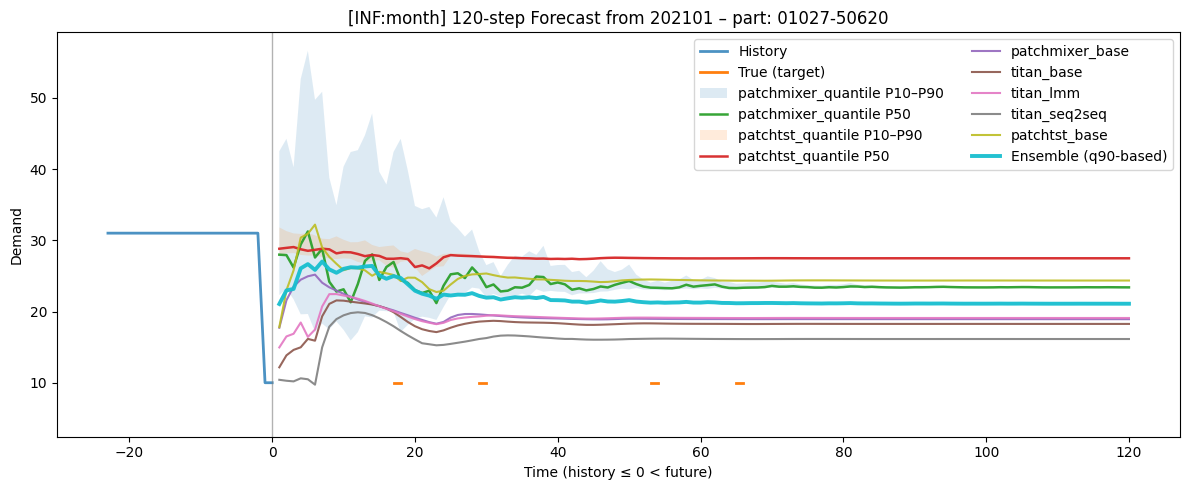

model PatchMixer QuantileModel [DBG] t 0 q10: 7.3186492919921875 q50: 54.24833297729492 q90: 204.7285919189453
model PatchMixer QuantileModel [DBG] t 1 q10: 19.579330444335938 q50: 61.28516387939453 q90: 228.854248046875
model PatchMixer QuantileModel [DBG] t 2 q10: 14.888641357421875 q50: 69.958740234375 q90: 264.92449951171875
model PatchMixer QuantileModel [DBG] t 3 q10: 9.450447082519531 q50: 60.3283805847168 q90: 240.75828552246094
model PatchMixer QuantileModel [DBG] t 4 q10: 29.244140625 q50: 114.48516082763672 q90: 355.9762268066406
model PatchTST QuantileModel [DBG] t 0 q10: 85.42449188232422 q50: 94.18472290039062 q90: 117.19995880126953
model PatchTST QuantileModel [DBG] t 1 q10: 88.61344146728516 q50: 98.96599578857422 q90: 116.06499481201172
model PatchTST QuantileModel [DBG] t 2 q10: 92.55191802978516 q50: 99.99201202392578 q90: 109.02039337158203
model PatchTST QuantileModel [DBG] t 3 q10: 91.84709930419922 q50: 96.46209716796875 q90: 109.5615463256836
model PatchTST Qua

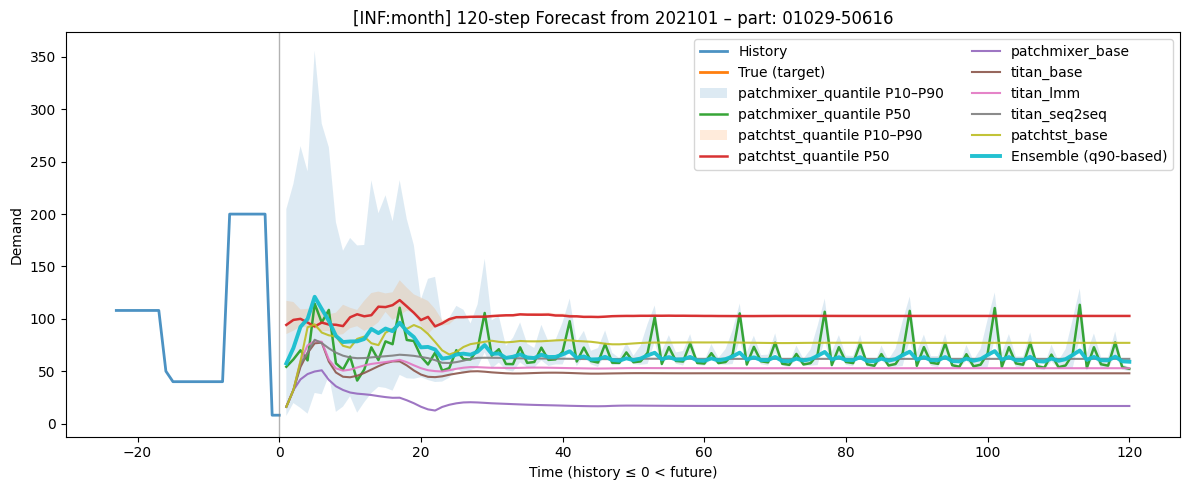

model PatchMixer QuantileModel [DBG] t 0 q10: -18.861080169677734 q50: 15.317556381225586 q90: 148.74929809570312
model PatchMixer QuantileModel [DBG] t 1 q10: -18.739585876464844 q50: 12.95745849609375 q90: 144.83984375
model PatchMixer QuantileModel [DBG] t 2 q10: -15.51519775390625 q50: 21.81874656677246 q90: 166.7989501953125
model PatchMixer QuantileModel [DBG] t 3 q10: -13.029582977294922 q50: 21.949966430664062 q90: 168.87066650390625
model PatchMixer QuantileModel [DBG] t 4 q10: -11.040576934814453 q50: 22.226266860961914 q90: 168.68533325195312
model PatchTST QuantileModel [DBG] t 0 q10: 40.80073547363281 q50: 42.56169509887695 q90: 49.38117218017578
model PatchTST QuantileModel [DBG] t 1 q10: 40.67418670654297 q50: 44.89151382446289 q90: 52.365543365478516
model PatchTST QuantileModel [DBG] t 2 q10: 42.07802963256836 q50: 45.38078689575195 q90: 55.388389587402344
model PatchTST QuantileModel [DBG] t 3 q10: 45.3209342956543 q50: 51.5938835144043 q90: 56.40382766723633
model Pa

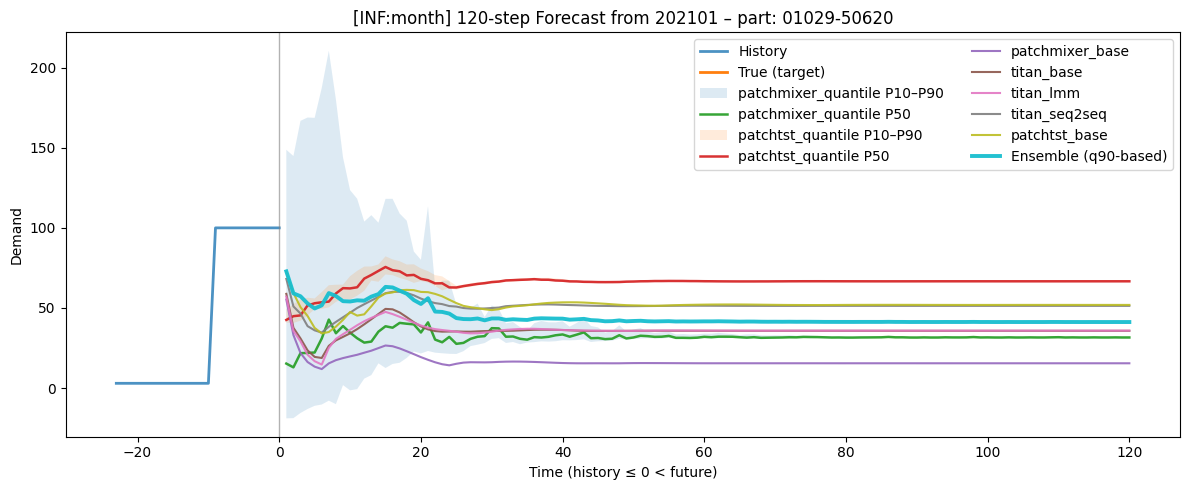

model PatchMixer QuantileModel [DBG] t 0 q10: -4.587930679321289 q50: 6.40138053894043 q90: 41.114532470703125
model PatchMixer QuantileModel [DBG] t 1 q10: -1.7166423797607422 q50: 7.068608283996582 q90: 41.64604949951172
model PatchMixer QuantileModel [DBG] t 2 q10: 0.862788200378418 q50: 8.21208667755127 q90: 37.904212951660156
model PatchMixer QuantileModel [DBG] t 3 q10: 1.4765129089355469 q50: 8.901779174804688 q90: 37.79669189453125
model PatchMixer QuantileModel [DBG] t 4 q10: 2.5699071884155273 q50: 9.915473937988281 q90: 35.701969146728516
model PatchTST QuantileModel [DBG] t 0 q10: 11.088811874389648 q50: 12.083642959594727 q90: 13.962194442749023
model PatchTST QuantileModel [DBG] t 1 q10: 12.09525203704834 q50: 13.48128890991211 q90: 13.958348274230957
model PatchTST QuantileModel [DBG] t 2 q10: 12.679666519165039 q50: 13.527584075927734 q90: 14.19466781616211
model PatchTST QuantileModel [DBG] t 3 q10: 12.525115013122559 q50: 13.997832298278809 q90: 15.703636169433594
mod

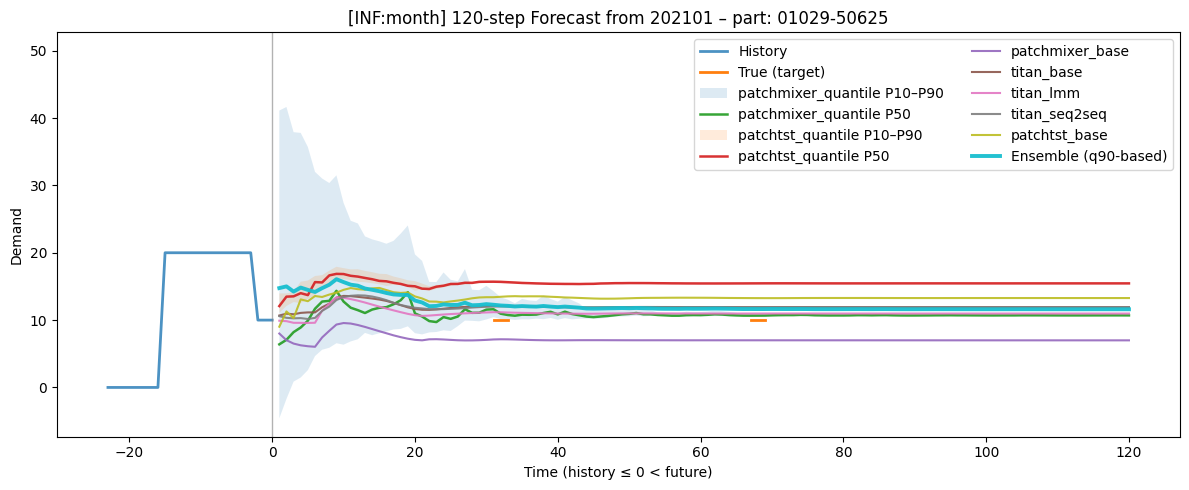

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

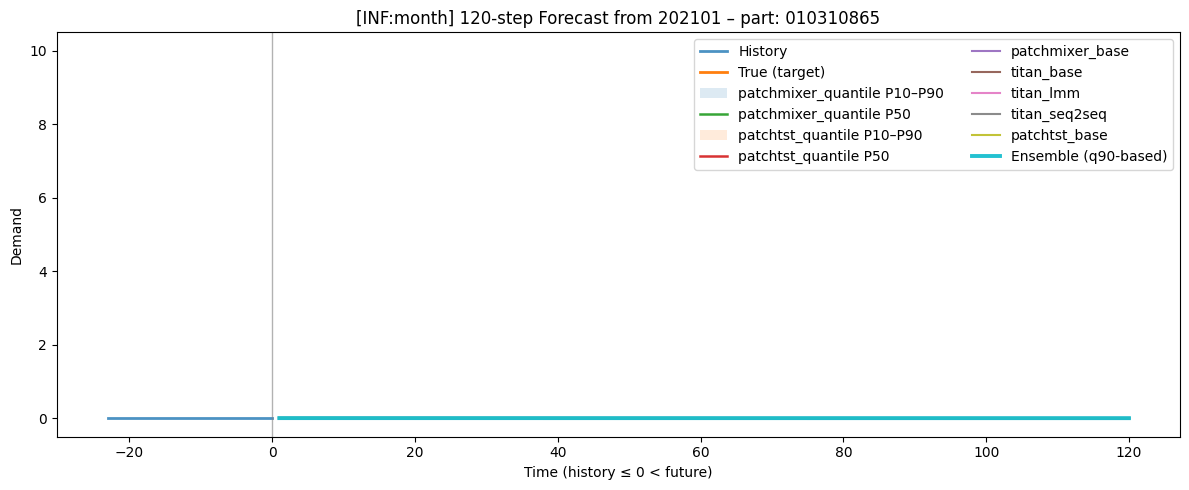

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

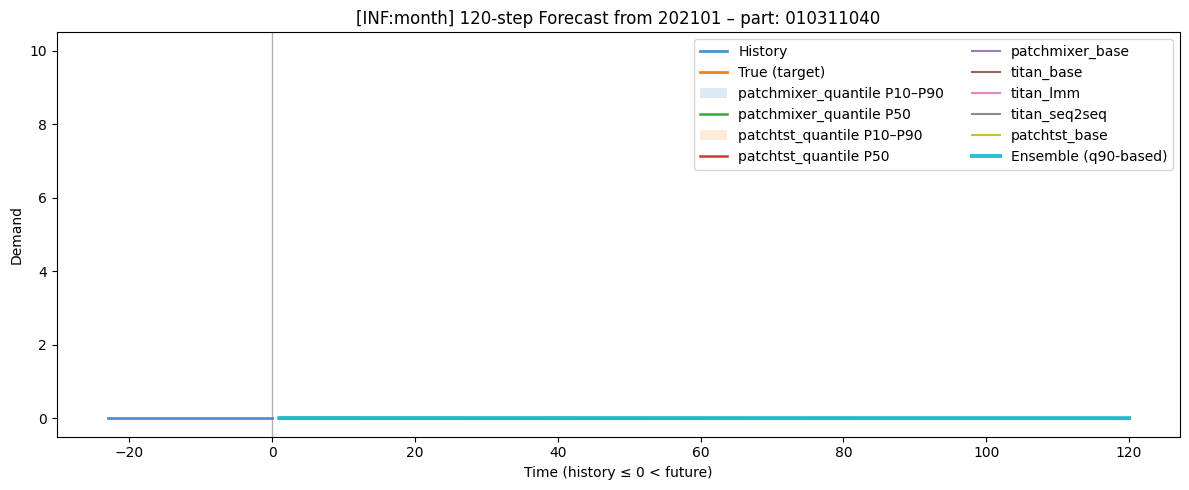

model PatchMixer QuantileModel [DBG] t 0 q10: 1.9500219821929932 q50: 3.731295347213745 q90: 7.901242256164551
model PatchMixer QuantileModel [DBG] t 1 q10: 2.227921962738037 q50: 3.9308412075042725 q90: 8.08842658996582
model PatchMixer QuantileModel [DBG] t 2 q10: 2.531172275543213 q50: 4.22016716003418 q90: 8.913993835449219
model PatchMixer QuantileModel [DBG] t 3 q10: 1.5735924243927002 q50: 3.564427614212036 q90: 9.326583862304688
model PatchMixer QuantileModel [DBG] t 4 q10: 1.3467388153076172 q50: 3.9059550762176514 q90: 10.478484153747559
model PatchTST QuantileModel [DBG] t 0 q10: 4.121092319488525 q50: 4.293043613433838 q90: 4.723529815673828
model PatchTST QuantileModel [DBG] t 1 q10: 4.074028968811035 q50: 4.317409038543701 q90: 4.690238952636719
model PatchTST QuantileModel [DBG] t 2 q10: 4.034486293792725 q50: 4.26406717300415 q90: 4.659510612487793
model PatchTST QuantileModel [DBG] t 3 q10: 4.084506034851074 q50: 4.281991958618164 q90: 4.568929672241211
model PatchTST 

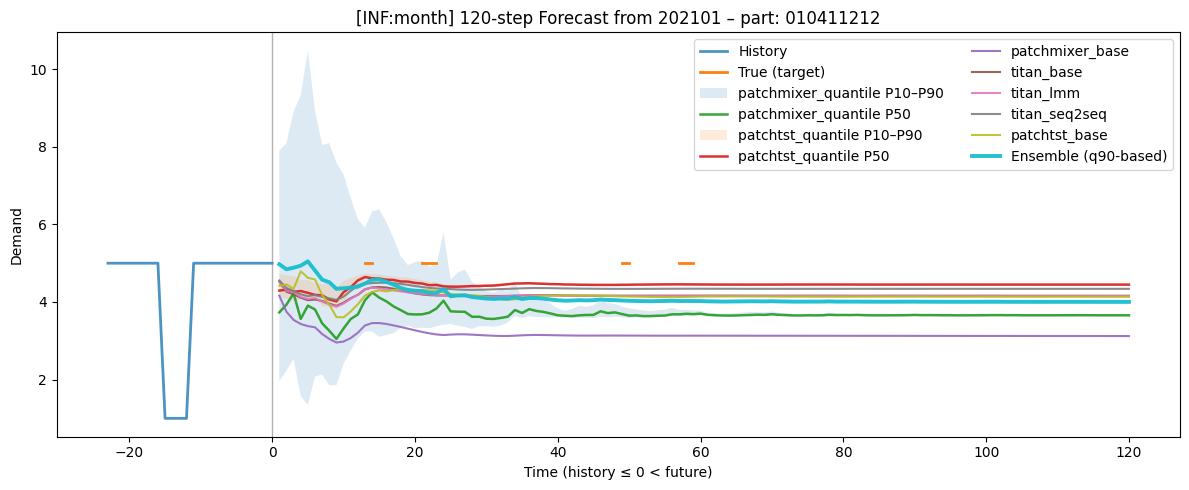

model PatchMixer QuantileModel [DBG] t 0 q10: -28.48998260498047 q50: 11.707695007324219 q90: 163.9188232421875
model PatchMixer QuantileModel [DBG] t 1 q10: -15.459320068359375 q50: 24.92761993408203 q90: 173.53463745117188
model PatchMixer QuantileModel [DBG] t 2 q10: -7.220985412597656 q50: 18.674407958984375 q90: 121.95912170410156
model PatchMixer QuantileModel [DBG] t 3 q10: -9.163917541503906 q50: 22.15727996826172 q90: 176.09689331054688
model PatchMixer QuantileModel [DBG] t 4 q10: -2.7528610229492188 q50: 22.42406463623047 q90: 130.35955810546875
model PatchTST QuantileModel [DBG] t 0 q10: 62.062679290771484 q50: 90.09577941894531 q90: 137.4063720703125
model PatchTST QuantileModel [DBG] t 1 q10: 73.83595275878906 q50: 96.56205749511719 q90: 135.06466674804688
model PatchTST QuantileModel [DBG] t 2 q10: 76.54290008544922 q50: 108.454345703125 q90: 137.47528076171875
model PatchTST QuantileModel [DBG] t 3 q10: 70.21955871582031 q50: 100.80557250976562 q90: 144.16879272460938
m

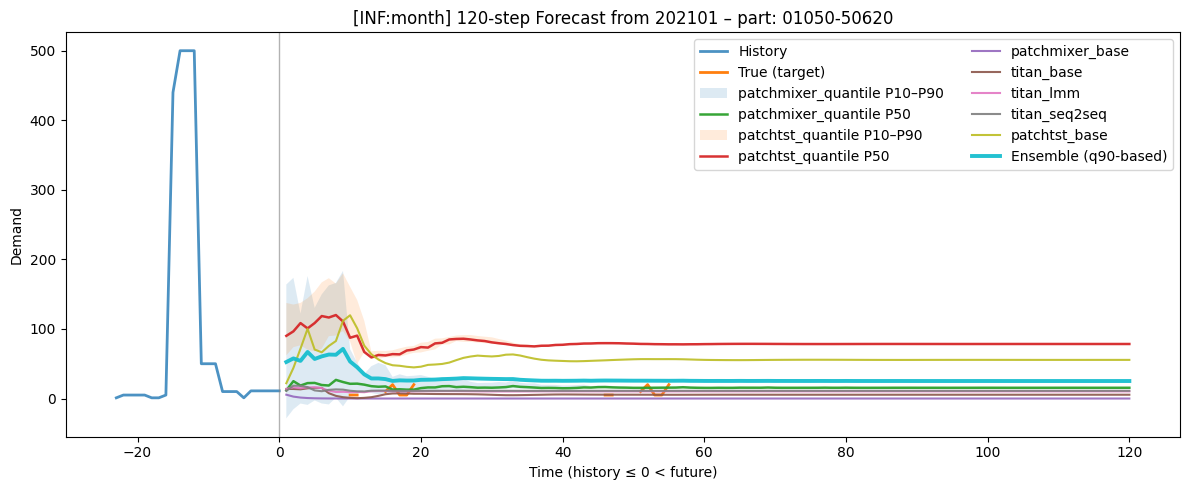

model PatchMixer QuantileModel [DBG] t 0 q10: -1.7730722427368164 q50: 3.772909641265869 q90: 27.893959045410156
model PatchMixer QuantileModel [DBG] t 1 q10: -1.5918054580688477 q50: 3.7267236709594727 q90: 27.12953758239746
model PatchMixer QuantileModel [DBG] t 2 q10: -1.987828254699707 q50: 5.128679275512695 q90: 31.676271438598633
model PatchMixer QuantileModel [DBG] t 3 q10: 0.24516677856445312 q50: 5.586568832397461 q90: 28.310117721557617
model PatchMixer QuantileModel [DBG] t 4 q10: 0.4473543167114258 q50: 6.488347053527832 q90: 31.062889099121094
model PatchTST QuantileModel [DBG] t 0 q10: 7.526695251464844 q50: 8.377988815307617 q90: 10.202123641967773
model PatchTST QuantileModel [DBG] t 1 q10: 7.958818435668945 q50: 8.680054664611816 q90: 10.738134384155273
model PatchTST QuantileModel [DBG] t 2 q10: 8.991047859191895 q50: 10.074313163757324 q90: 10.349068641662598
model PatchTST QuantileModel [DBG] t 3 q10: 9.408384323120117 q50: 9.694195747375488 q90: 10.369112014770508


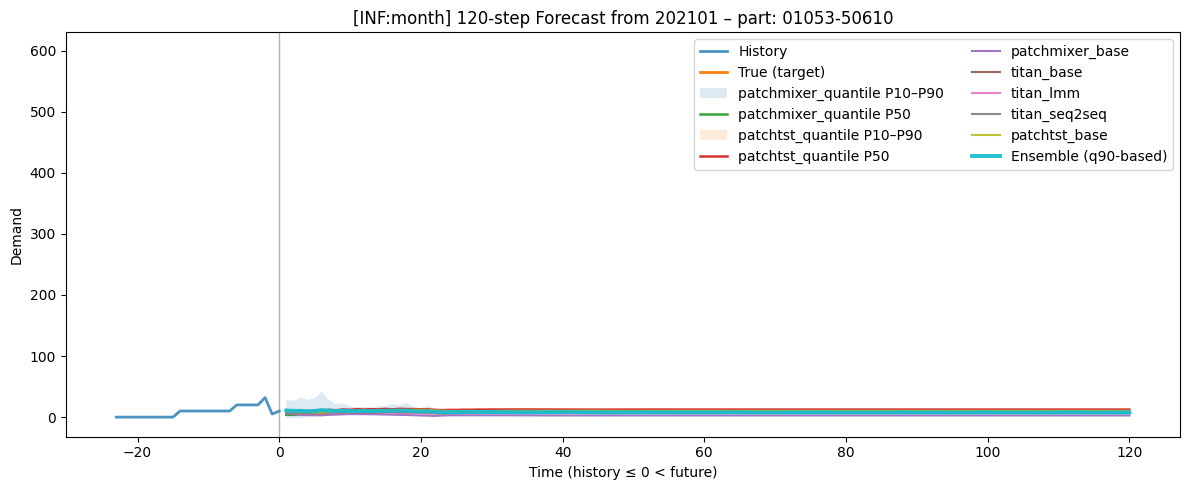

model PatchMixer QuantileModel [DBG] t 0 q10: 11.499319076538086 q50: 16.86309242248535 q90: 30.289703369140625
model PatchMixer QuantileModel [DBG] t 1 q10: 11.357454299926758 q50: 17.195232391357422 q90: 32.0657958984375
model PatchMixer QuantileModel [DBG] t 2 q10: 10.275360107421875 q50: 18.25493049621582 q90: 34.62921905517578
model PatchMixer QuantileModel [DBG] t 3 q10: 10.71204948425293 q50: 19.800098419189453 q90: 38.697017669677734
model PatchMixer QuantileModel [DBG] t 4 q10: 9.597058296203613 q50: 17.921175003051758 q90: 34.09370803833008
model PatchTST QuantileModel [DBG] t 0 q10: 17.201473236083984 q50: 17.859994888305664 q90: 19.291980743408203
model PatchTST QuantileModel [DBG] t 1 q10: 17.241132736206055 q50: 17.70937156677246 q90: 19.229219436645508
model PatchTST QuantileModel [DBG] t 2 q10: 17.197328567504883 q50: 17.741910934448242 q90: 18.954675674438477
model PatchTST QuantileModel [DBG] t 3 q10: 17.014163970947266 q50: 17.732471466064453 q90: 18.776859283447266


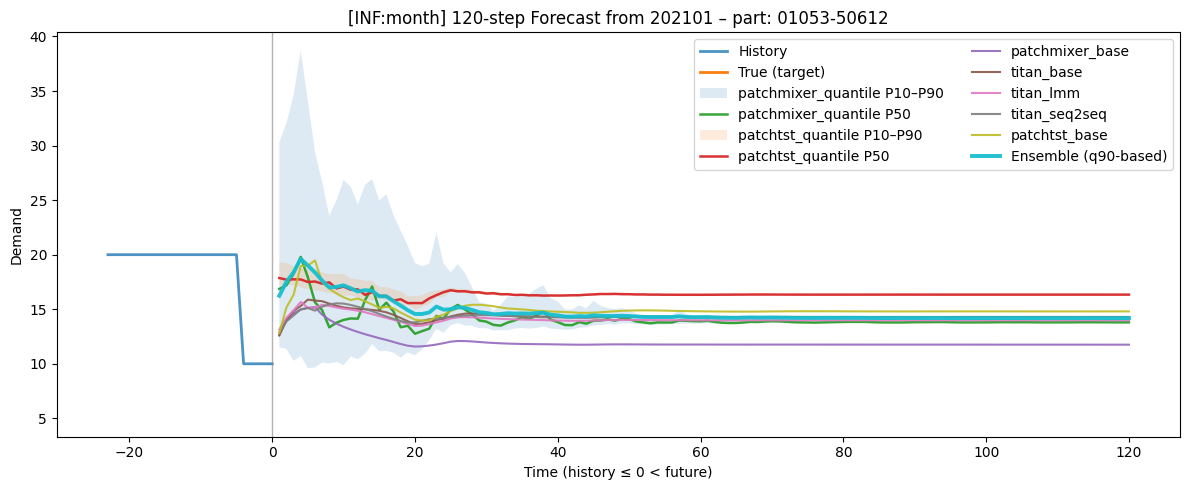

model PatchMixer QuantileModel [DBG] t 0 q10: 0.9881582260131836 q50: 9.085041046142578 q90: 29.7957820892334
model PatchMixer QuantileModel [DBG] t 1 q10: 0.037194252014160156 q50: 7.263513088226318 q90: 28.25676918029785
model PatchMixer QuantileModel [DBG] t 2 q10: 0.6537446975708008 q50: 7.832076072692871 q90: 26.503999710083008
model PatchMixer QuantileModel [DBG] t 3 q10: 1.2237558364868164 q50: 8.550212860107422 q90: 25.799259185791016
model PatchMixer QuantileModel [DBG] t 4 q10: 1.0875787734985352 q50: 7.06539249420166 q90: 25.007904052734375
model PatchTST QuantileModel [DBG] t 0 q10: 11.406942367553711 q50: 12.649458885192871 q90: 15.085531234741211
model PatchTST QuantileModel [DBG] t 1 q10: 11.06070613861084 q50: 12.662222862243652 q90: 14.515464782714844
model PatchTST QuantileModel [DBG] t 2 q10: 10.851045608520508 q50: 12.073267936706543 q90: 13.915364265441895
model PatchTST QuantileModel [DBG] t 3 q10: 10.265725135803223 q50: 11.82655143737793 q90: 14.058791160583496


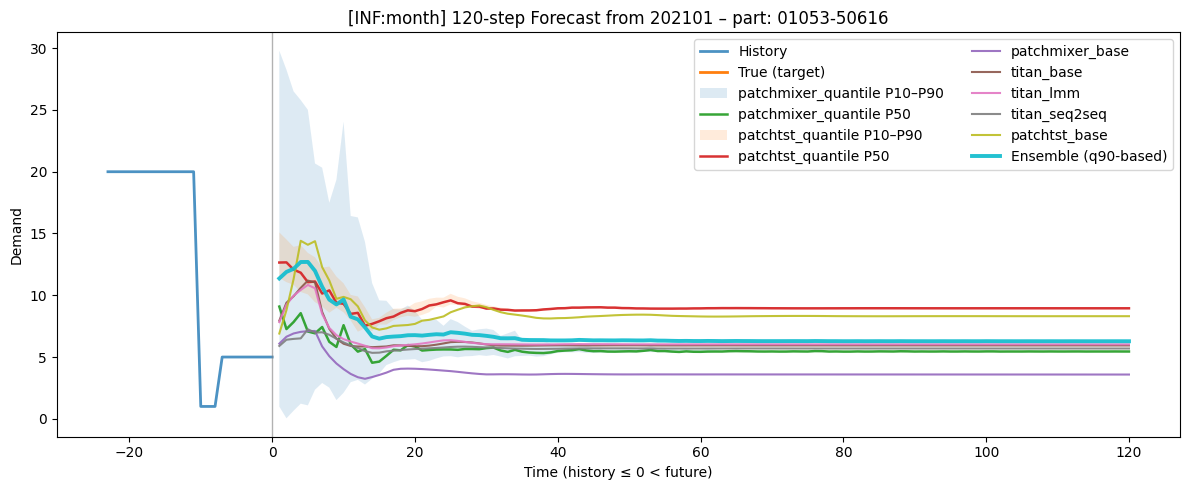

model PatchMixer QuantileModel [DBG] t 0 q10: 0.882988452911377 q50: 3.12282657623291 q90: 9.05744743347168
model PatchMixer QuantileModel [DBG] t 1 q10: 1.1035358905792236 q50: 3.148297071456909 q90: 9.196680068969727
model PatchMixer QuantileModel [DBG] t 2 q10: 1.3296358585357666 q50: 3.354464292526245 q90: 9.974832534790039
model PatchMixer QuantileModel [DBG] t 3 q10: 0.7109909057617188 q50: 2.302990436553955 q90: 7.60541296005249
model PatchMixer QuantileModel [DBG] t 4 q10: 0.5816020965576172 q50: 2.461625099182129 q90: 8.865643501281738
model PatchTST QuantileModel [DBG] t 0 q10: 3.885402202606201 q50: 5.443058013916016 q90: 7.285062789916992
model PatchTST QuantileModel [DBG] t 1 q10: 4.117107391357422 q50: 4.486306667327881 q90: 6.297259330749512
model PatchTST QuantileModel [DBG] t 2 q10: 3.379385471343994 q50: 4.148651599884033 q90: 4.974428176879883
model PatchTST QuantileModel [DBG] t 3 q10: 3.5590124130249023 q50: 4.093095302581787 q90: 5.0746564865112305
model PatchTST 

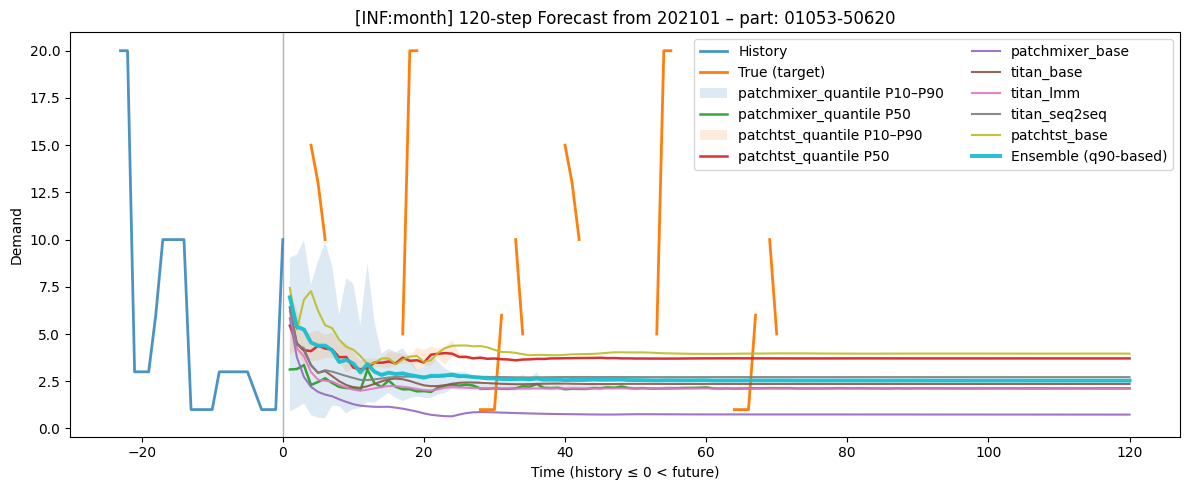

model PatchMixer QuantileModel [DBG] t 0 q10: 1.1197361946105957 q50: 3.1600050926208496 q90: 12.223892211914062
model PatchMixer QuantileModel [DBG] t 1 q10: 1.9990692138671875 q50: 3.032789707183838 q90: 11.779158592224121
model PatchMixer QuantileModel [DBG] t 2 q10: 1.3797454833984375 q50: 3.491806745529175 q90: 17.91518783569336
model PatchMixer QuantileModel [DBG] t 3 q10: 1.248300552368164 q50: 5.081357479095459 q90: 22.71577262878418
model PatchMixer QuantileModel [DBG] t 4 q10: 0.6738343238830566 q50: 4.449606895446777 q90: 21.776992797851562
model PatchTST QuantileModel [DBG] t 0 q10: 5.578394889831543 q50: 6.166492938995361 q90: 7.973083019256592
model PatchTST QuantileModel [DBG] t 1 q10: 5.881580829620361 q50: 6.447371959686279 q90: 8.14922046661377
model PatchTST QuantileModel [DBG] t 2 q10: 6.371161460876465 q50: 7.0154218673706055 q90: 7.988595962524414
model PatchTST QuantileModel [DBG] t 3 q10: 6.650410175323486 q50: 6.994556903839111 q90: 7.991620063781738
model Patc

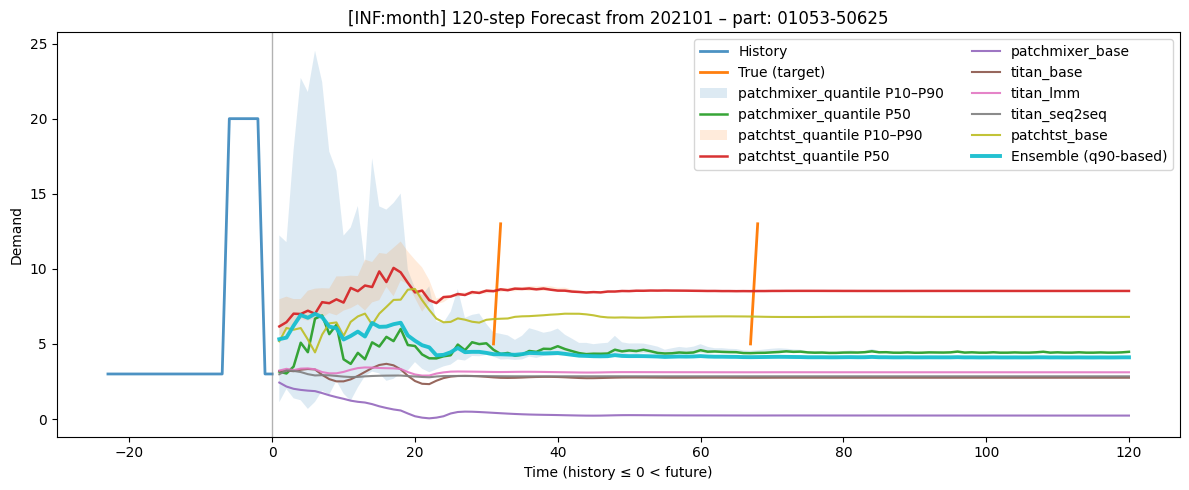

model PatchMixer QuantileModel [DBG] t 0 q10: 19.99924659729004 q50: 19.999420166015625 q90: 19.999738693237305
model PatchMixer QuantileModel [DBG] t 1 q10: 19.99920654296875 q50: 19.999380111694336 q90: 19.999704360961914
model PatchMixer QuantileModel [DBG] t 2 q10: 19.999168395996094 q50: 19.999359130859375 q90: 19.999717712402344
model PatchMixer QuantileModel [DBG] t 3 q10: 19.999122619628906 q50: 19.99929428100586 q90: 19.999746322631836
model PatchMixer QuantileModel [DBG] t 4 q10: 19.999088287353516 q50: 19.999277114868164 q90: 19.999698638916016
model PatchTST QuantileModel [DBG] t 0 q10: 19.99915885925293 q50: 19.99957847595215 q90: 20.001474380493164
model PatchTST QuantileModel [DBG] t 1 q10: 19.999128341674805 q50: 19.999568939208984 q90: 20.001474380493164
model PatchTST QuantileModel [DBG] t 2 q10: 19.999113082885742 q50: 19.99953842163086 q90: 20.00146484375
model PatchTST QuantileModel [DBG] t 3 q10: 19.999103546142578 q50: 19.999544143676758 q90: 20.001441955566406
m

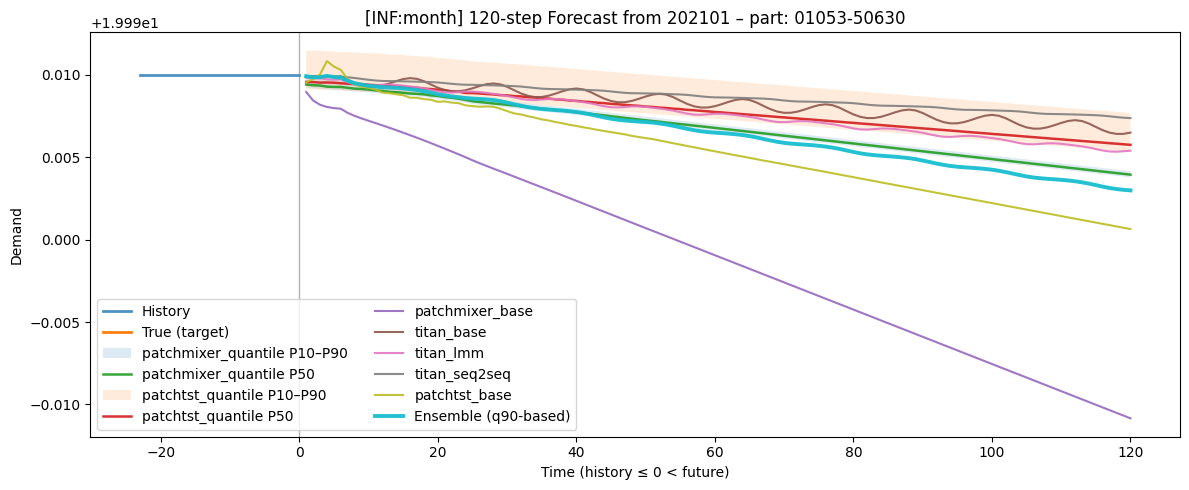

model PatchMixer QuantileModel [DBG] t 0 q10: 9.999246597290039 q50: 9.999420166015625 q90: 9.999738693237305
model PatchMixer QuantileModel [DBG] t 1 q10: 9.999204635620117 q50: 9.999378204345703 q90: 9.999703407287598
model PatchMixer QuantileModel [DBG] t 2 q10: 9.999167442321777 q50: 9.999359130859375 q90: 9.999717712402344
model PatchMixer QuantileModel [DBG] t 3 q10: 9.999122619628906 q50: 9.99929428100586 q90: 9.999746322631836
model PatchMixer QuantileModel [DBG] t 4 q10: 9.9990873336792 q50: 9.999276161193848 q90: 9.999698638916016
model PatchTST QuantileModel [DBG] t 0 q10: 9.999157905578613 q50: 9.999578475952148 q90: 10.00147533416748
model PatchTST QuantileModel [DBG] t 1 q10: 9.999128341674805 q50: 9.9995698928833 q90: 10.001474380493164
model PatchTST QuantileModel [DBG] t 2 q10: 9.999112129211426 q50: 9.999537467956543 q90: 10.00146484375
model PatchTST QuantileModel [DBG] t 3 q10: 9.999103546142578 q50: 9.999543190002441 q90: 10.001441955566406
model PatchTST QuantileM

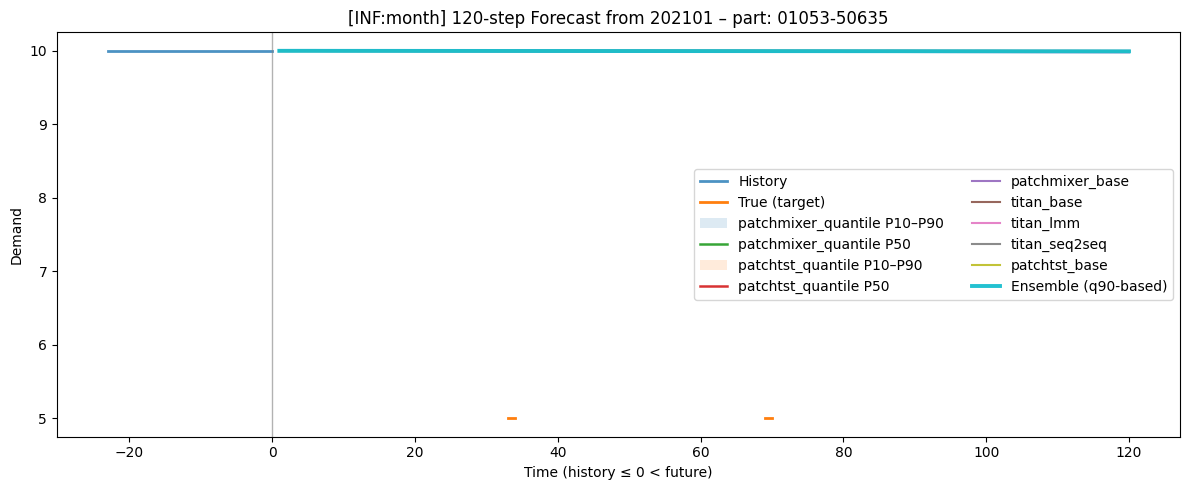

model PatchMixer QuantileModel [DBG] t 0 q10: -2.785893440246582 q50: 4.423541069030762 q90: 24.49587059020996
model PatchMixer QuantileModel [DBG] t 1 q10: -1.046339988708496 q50: 3.2495884895324707 q90: 18.978914260864258
model PatchMixer QuantileModel [DBG] t 2 q10: -2.2716493606567383 q50: 2.193272590637207 q90: 17.275646209716797
model PatchMixer QuantileModel [DBG] t 3 q10: -0.5758724212646484 q50: 3.2909231185913086 q90: 19.893840789794922
model PatchMixer QuantileModel [DBG] t 4 q10: 0.7235231399536133 q50: 6.487995624542236 q90: 26.81593132019043
model PatchTST QuantileModel [DBG] t 0 q10: 7.747429847717285 q50: 9.315176010131836 q90: 10.443025588989258
model PatchTST QuantileModel [DBG] t 1 q10: 8.171893119812012 q50: 9.374186515808105 q90: 10.276445388793945
model PatchTST QuantileModel [DBG] t 2 q10: 7.763043403625488 q50: 9.60679817199707 q90: 11.390183448791504
model PatchTST QuantileModel [DBG] t 3 q10: 8.30855655670166 q50: 9.560047149658203 q90: 11.608030319213867
mode

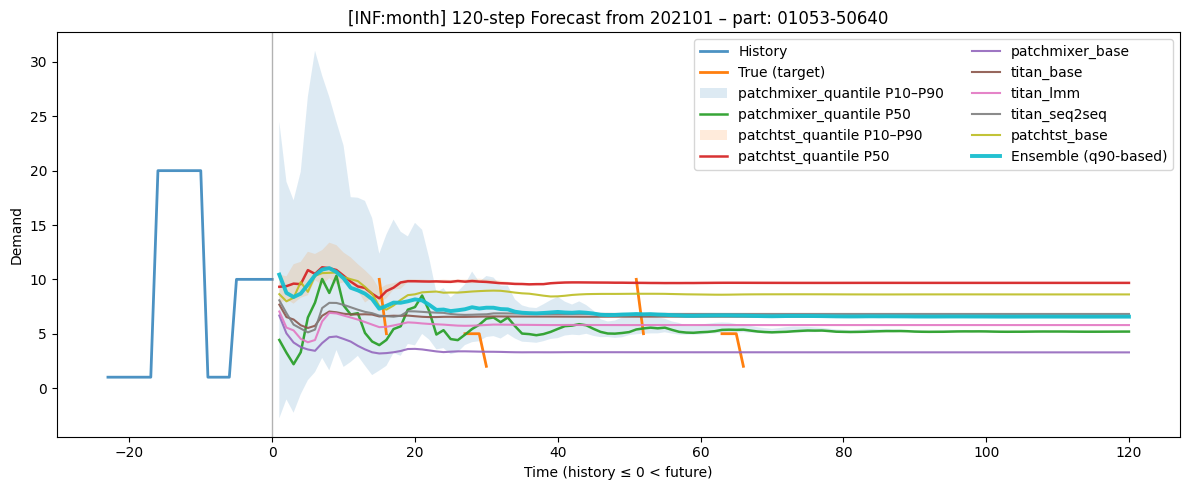

model PatchMixer QuantileModel [DBG] t 0 q10: 0.894364058971405 q50: 1.0307245254516602 q90: 1.7716810703277588
model PatchMixer QuantileModel [DBG] t 1 q10: 0.8182604312896729 q50: 1.080283522605896 q90: 1.639041543006897
model PatchMixer QuantileModel [DBG] t 2 q10: 0.8980002403259277 q50: 1.0629404783248901 q90: 1.5183954238891602
model PatchMixer QuantileModel [DBG] t 3 q10: 0.8583748936653137 q50: 0.9795265197753906 q90: 1.454354166984558
model PatchMixer QuantileModel [DBG] t 4 q10: 0.8284855484962463 q50: 1.004052758216858 q90: 1.3715245723724365
model PatchTST QuantileModel [DBG] t 0 q10: 1.3057842254638672 q50: 1.3348791599273682 q90: 1.8156402111053467
model PatchTST QuantileModel [DBG] t 1 q10: 1.2716220617294312 q50: 1.365405559539795 q90: 1.8546698093414307
model PatchTST QuantileModel [DBG] t 2 q10: 1.327823519706726 q50: 1.4378373622894287 q90: 1.8412001132965088
model PatchTST QuantileModel [DBG] t 3 q10: 1.3700358867645264 q50: 1.5123900175094604 q90: 1.83750581741333


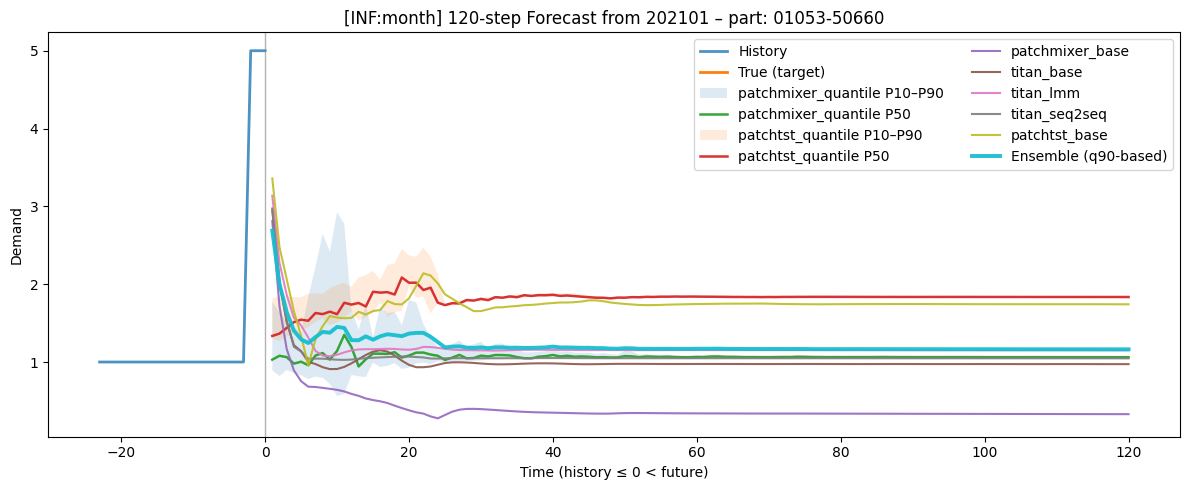

model PatchMixer QuantileModel [DBG] t 0 q10: 9.185361862182617 q50: 21.094398498535156 q90: 67.38075256347656
model PatchMixer QuantileModel [DBG] t 1 q10: 8.39579963684082 q50: 24.599716186523438 q90: 80.4092025756836
model PatchMixer QuantileModel [DBG] t 2 q10: 11.905147552490234 q50: 22.749935150146484 q90: 74.07272338867188
model PatchMixer QuantileModel [DBG] t 3 q10: 11.772623062133789 q50: 21.137928009033203 q90: 59.25664520263672
model PatchMixer QuantileModel [DBG] t 4 q10: 8.203084945678711 q50: 20.545928955078125 q90: 71.94591522216797
model PatchTST QuantileModel [DBG] t 0 q10: 28.318195343017578 q50: 34.75165939331055 q90: 39.50849151611328
model PatchTST QuantileModel [DBG] t 1 q10: 22.550060272216797 q50: 35.480899810791016 q90: 44.27134323120117
model PatchTST QuantileModel [DBG] t 2 q10: 28.811586380004883 q50: 32.508209228515625 q90: 44.54046630859375
model PatchTST QuantileModel [DBG] t 3 q10: 27.25295639038086 q50: 31.19000244140625 q90: 37.83103942871094
model Pa

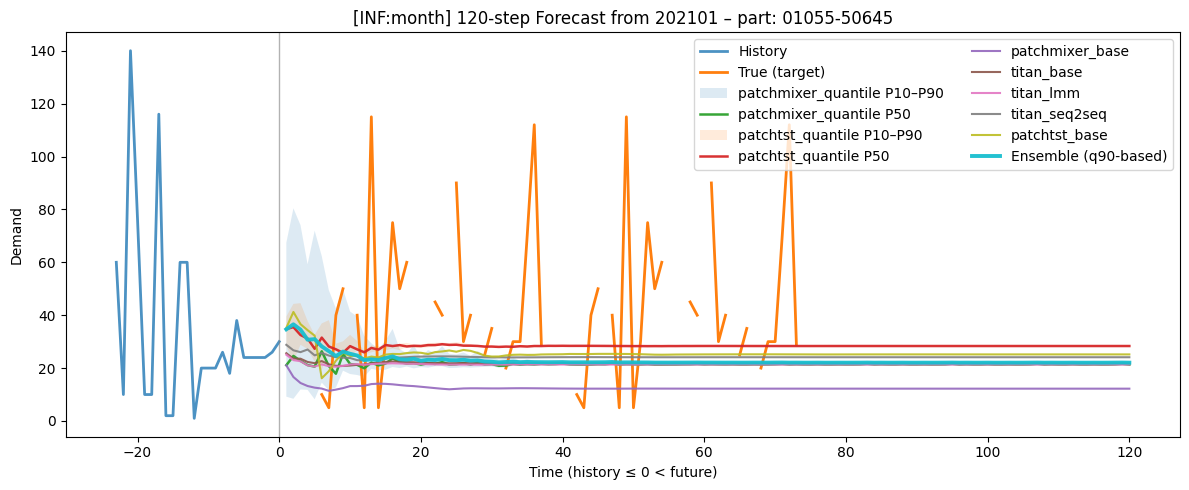

model PatchMixer QuantileModel [DBG] t 0 q10: -101.9925537109375 q50: 64.2140884399414 q90: 741.6539306640625
model PatchMixer QuantileModel [DBG] t 1 q10: -74.54583740234375 q50: 74.83734893798828 q90: 653.580810546875
model PatchMixer QuantileModel [DBG] t 2 q10: -79.10916137695312 q50: 92.69587707519531 q90: 777.9720458984375
model PatchMixer QuantileModel [DBG] t 3 q10: -64.83282470703125 q50: 94.63712310791016 q90: 749.2203369140625
model PatchMixer QuantileModel [DBG] t 4 q10: -58.972900390625 q50: 99.09351348876953 q90: 761.173583984375
model PatchTST QuantileModel [DBG] t 0 q10: 168.79742431640625 q50: 181.73252868652344 q90: 211.52374267578125
model PatchTST QuantileModel [DBG] t 1 q10: 171.06927490234375 q50: 186.11863708496094 q90: 224.94546508789062
model PatchTST QuantileModel [DBG] t 2 q10: 182.92510986328125 q50: 206.2059326171875 q90: 232.1245880126953
model PatchTST QuantileModel [DBG] t 3 q10: 196.87960815429688 q50: 216.06349182128906 q90: 234.3203887939453
model Pat

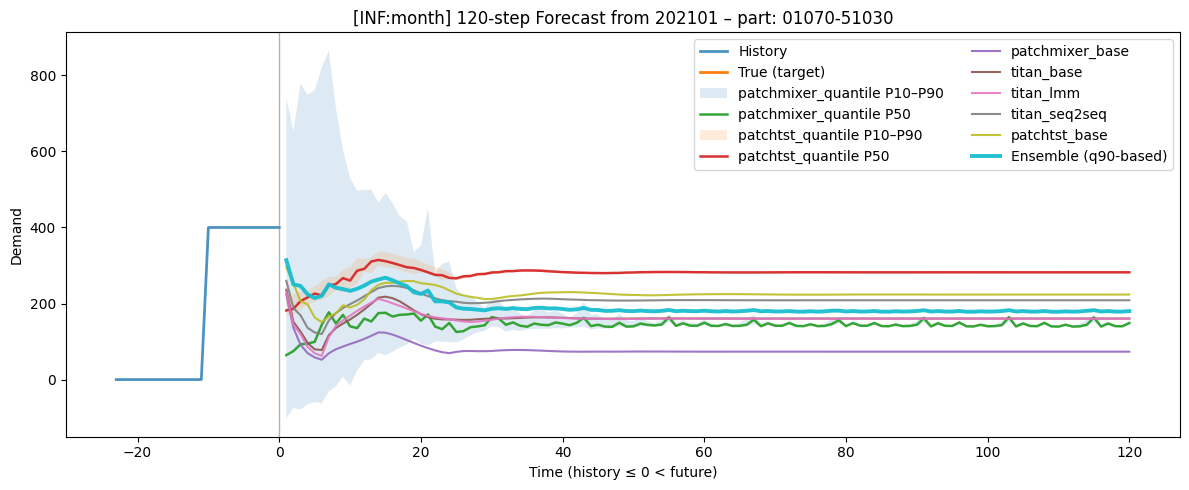

model PatchMixer QuantileModel [DBG] t 0 q10: 19.99924659729004 q50: 19.999420166015625 q90: 19.999738693237305
model PatchMixer QuantileModel [DBG] t 1 q10: 19.99920654296875 q50: 19.999380111694336 q90: 19.999704360961914
model PatchMixer QuantileModel [DBG] t 2 q10: 19.999168395996094 q50: 19.999359130859375 q90: 19.999717712402344
model PatchMixer QuantileModel [DBG] t 3 q10: 19.999122619628906 q50: 19.99929428100586 q90: 19.999746322631836
model PatchMixer QuantileModel [DBG] t 4 q10: 19.999088287353516 q50: 19.999277114868164 q90: 19.999698638916016
model PatchTST QuantileModel [DBG] t 0 q10: 19.99915885925293 q50: 19.99957847595215 q90: 20.001474380493164
model PatchTST QuantileModel [DBG] t 1 q10: 19.999128341674805 q50: 19.999568939208984 q90: 20.001474380493164
model PatchTST QuantileModel [DBG] t 2 q10: 19.999113082885742 q50: 19.99953842163086 q90: 20.00146484375
model PatchTST QuantileModel [DBG] t 3 q10: 19.999103546142578 q50: 19.999544143676758 q90: 20.001441955566406
m

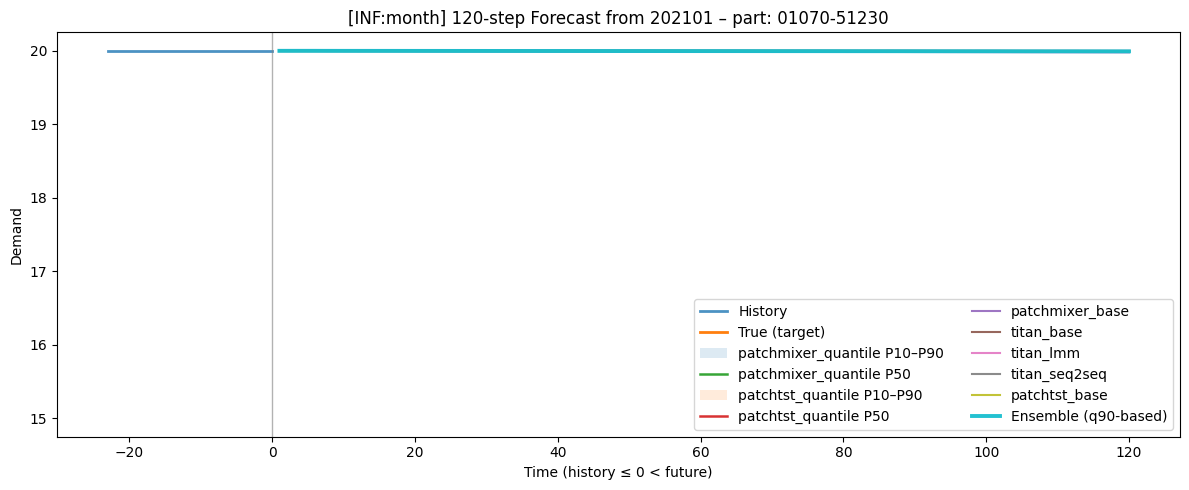

model PatchMixer QuantileModel [DBG] t 0 q10: 0.16780471801757812 q50: 36.258018493652344 q90: 102.37271118164062
model PatchMixer QuantileModel [DBG] t 1 q10: 0.86688232421875 q50: 29.50476837158203 q90: 89.90067291259766
model PatchMixer QuantileModel [DBG] t 2 q10: 4.159839630126953 q50: 27.867229461669922 q90: 85.07577514648438
model PatchMixer QuantileModel [DBG] t 3 q10: 1.9693946838378906 q50: 16.09676170349121 q90: 67.00340270996094
model PatchMixer QuantileModel [DBG] t 4 q10: 2.1874313354492188 q50: 20.109477996826172 q90: 74.34412384033203
model PatchTST QuantileModel [DBG] t 0 q10: 35.6483268737793 q50: 38.60364532470703 q90: 43.933631896972656
model PatchTST QuantileModel [DBG] t 1 q10: 34.56992721557617 q50: 40.237876892089844 q90: 44.98445129394531
model PatchTST QuantileModel [DBG] t 2 q10: 34.86931228637695 q50: 38.629886627197266 q90: 43.83464050292969
model PatchTST QuantileModel [DBG] t 3 q10: 34.4821662902832 q50: 41.05418395996094 q90: 45.3316535949707
model Patch

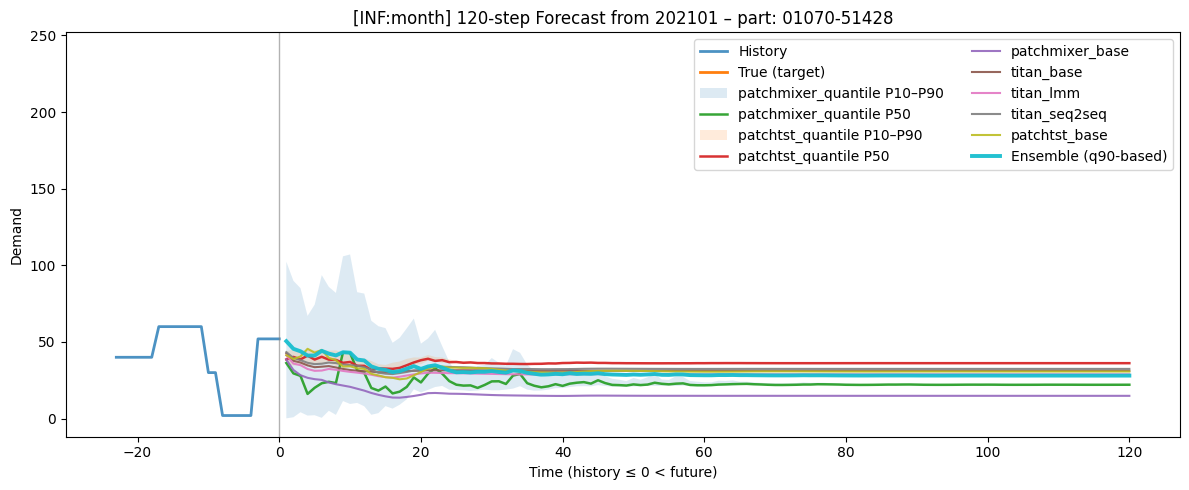

model PatchMixer QuantileModel [DBG] t 0 q10: 2.1229095458984375 q50: 14.116094589233398 q90: 38.76652526855469
model PatchMixer QuantileModel [DBG] t 1 q10: 4.974618911743164 q50: 17.87502670288086 q90: 58.08353805541992
model PatchMixer QuantileModel [DBG] t 2 q10: -1.4024124145507812 q50: 10.508893013000488 q90: 60.611942291259766
model PatchMixer QuantileModel [DBG] t 3 q10: 0.19503211975097656 q50: 11.645512580871582 q90: 58.03289794921875
model PatchMixer QuantileModel [DBG] t 4 q10: -0.13857460021972656 q50: 7.936642646789551 q90: 41.31980895996094
model PatchTST QuantileModel [DBG] t 0 q10: 18.098058700561523 q50: 26.350540161132812 q90: 32.69697952270508
model PatchTST QuantileModel [DBG] t 1 q10: 18.935564041137695 q50: 20.945119857788086 q90: 33.95452880859375
model PatchTST QuantileModel [DBG] t 2 q10: 19.428476333618164 q50: 25.405668258666992 q90: 32.10702133178711
model PatchTST QuantileModel [DBG] t 3 q10: 20.836769104003906 q50: 27.632415771484375 q90: 30.0784454345703

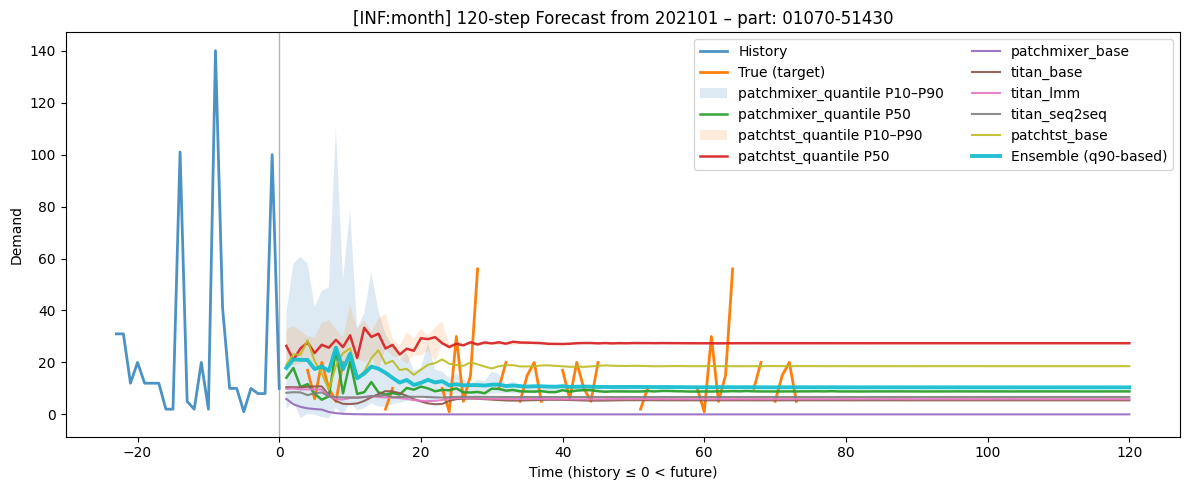

model PatchMixer QuantileModel [DBG] t 0 q10: 346.01470947265625 q50: 808.4614868164062 q90: 1897.399658203125
model PatchMixer QuantileModel [DBG] t 1 q10: -7.008331298828125 q50: 150.64707946777344 q90: 896.0267333984375
model PatchMixer QuantileModel [DBG] t 2 q10: 179.95608520507812 q50: 346.4051818847656 q90: 644.2498779296875
model PatchMixer QuantileModel [DBG] t 3 q10: 44.40553283691406 q50: 116.78182983398438 q90: 319.86431884765625
model PatchMixer QuantileModel [DBG] t 4 q10: 28.915237426757812 q50: 106.57012939453125 q90: 329.9696960449219
model PatchTST QuantileModel [DBG] t 0 q10: 230.83697509765625 q50: 252.13241577148438 q90: 356.21221923828125
model PatchTST QuantileModel [DBG] t 1 q10: 190.05258178710938 q50: 233.182373046875 q90: 284.6322937011719
model PatchTST QuantileModel [DBG] t 2 q10: 217.20318603515625 q50: 247.1641845703125 q90: 289.90850830078125
model PatchTST QuantileModel [DBG] t 3 q10: 207.90528869628906 q50: 217.3448028564453 q90: 249.2244415283203
mode

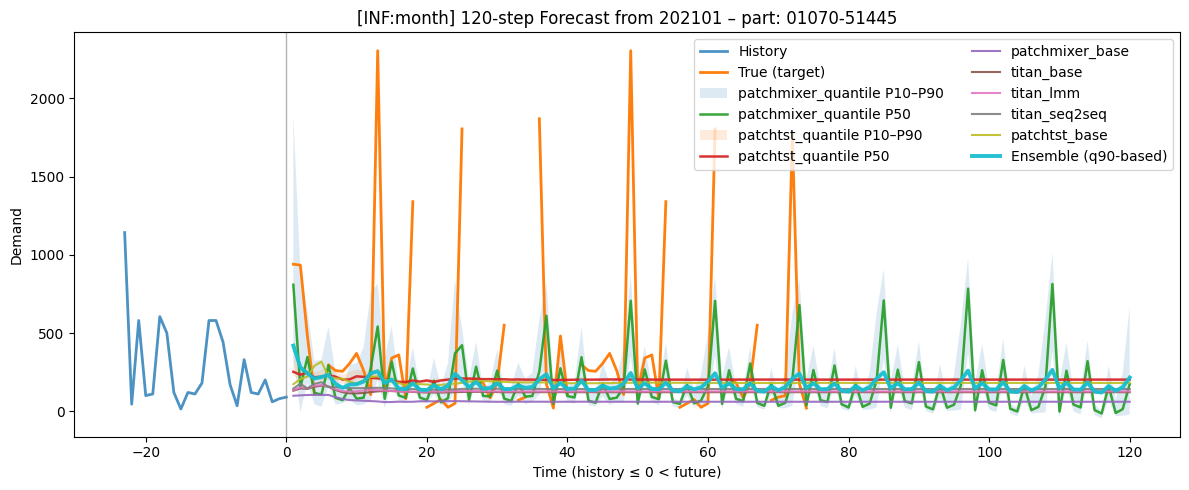

model PatchMixer QuantileModel [DBG] t 0 q10: 4.066577911376953 q50: 16.557737350463867 q90: 62.903358459472656
model PatchMixer QuantileModel [DBG] t 1 q10: 2.225566864013672 q50: 22.790441513061523 q90: 93.33860778808594
model PatchMixer QuantileModel [DBG] t 2 q10: 4.942045211791992 q50: 37.070899963378906 q90: 139.17547607421875
model PatchMixer QuantileModel [DBG] t 3 q10: 4.588903427124023 q50: 22.58145523071289 q90: 87.52023315429688
model PatchMixer QuantileModel [DBG] t 4 q10: 8.995138168334961 q50: 23.097265243530273 q90: 63.851890563964844
model PatchTST QuantileModel [DBG] t 0 q10: 30.181751251220703 q50: 30.491783142089844 q90: 34.52610397338867
model PatchTST QuantileModel [DBG] t 1 q10: 26.32706642150879 q50: 35.144676208496094 q90: 40.352664947509766
model PatchTST QuantileModel [DBG] t 2 q10: 29.932270050048828 q50: 30.13516616821289 q90: 38.16551971435547
model PatchTST QuantileModel [DBG] t 3 q10: 28.438304901123047 q50: 38.14777374267578 q90: 42.14030075073242
model

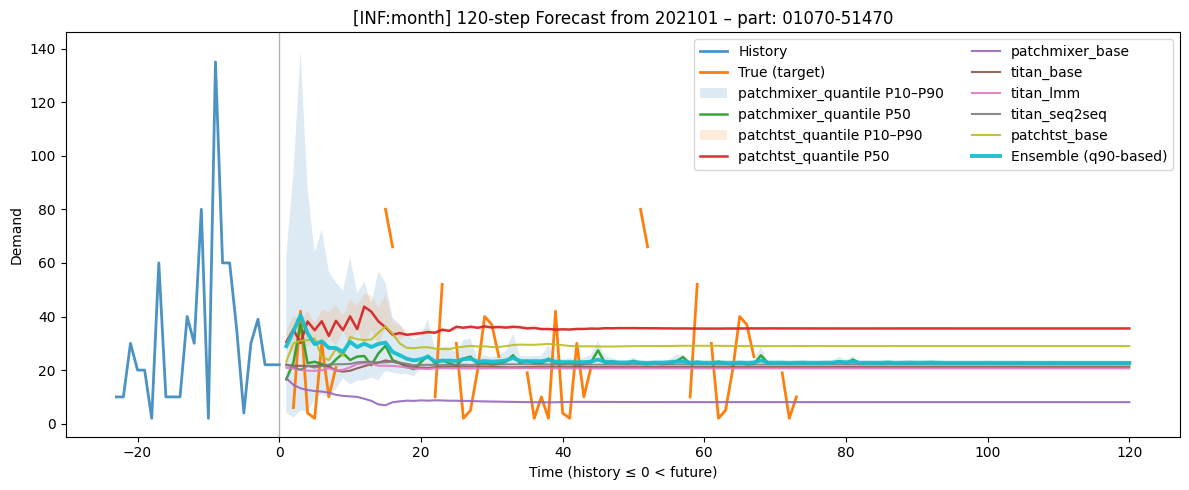

model PatchMixer QuantileModel [DBG] t 0 q10: -0.0007538630161434412 q50: -0.0005794072640128434 q90: -0.00026157486718147993
model PatchMixer QuantileModel [DBG] t 1 q10: -0.000795613566879183 q50: -0.0006222088122740388 q90: -0.0002965435560327023
model PatchMixer QuantileModel [DBG] t 2 q10: -0.0008330154232680798 q50: -0.0006416207179427147 q90: -0.000282792781945318
model PatchMixer QuantileModel [DBG] t 3 q10: -0.0008782636723481119 q50: -0.0007067215628921986 q90: -0.00025354427634738386
model PatchMixer QuantileModel [DBG] t 4 q10: -0.0009136798325926065 q50: -0.0007246772293001413 q90: -0.0003007934137713164
model PatchTST QuantileModel [DBG] t 0 q10: -0.0008420587400905788 q50: -0.0004217594978399575 q90: 0.0014751481357961893
model PatchTST QuantileModel [DBG] t 1 q10: -0.000872545235324651 q50: -0.0004307038034312427 q90: 0.0014744775835424662
model PatchTST QuantileModel [DBG] t 2 q10: -0.0008882550755515695 q50: -0.00046302893315441906 q90: 0.0014645140618085861
model Pat

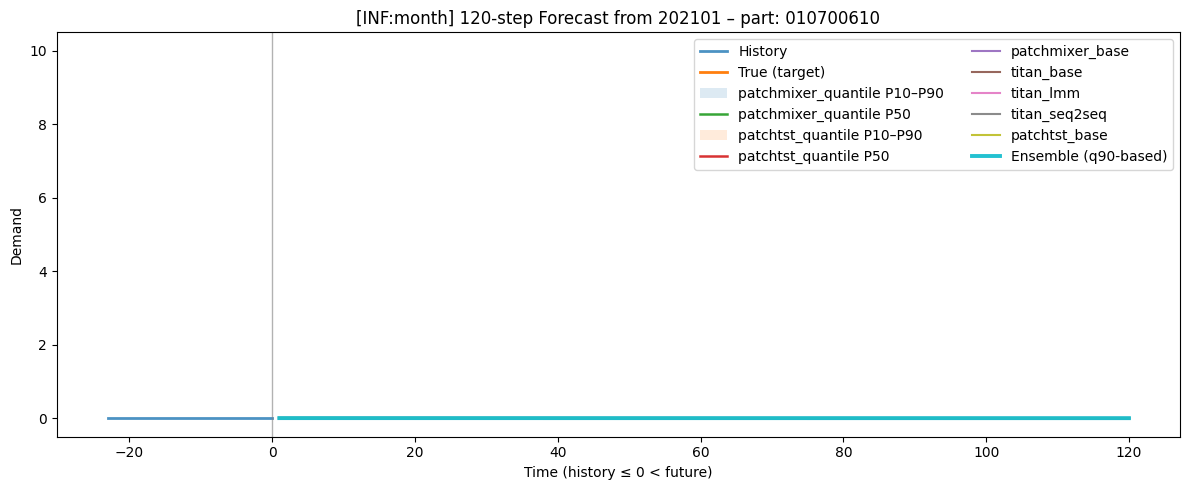

model PatchMixer QuantileModel [DBG] t 0 q10: 4.953146934509277 q50: 5.025362968444824 q90: 5.134415149688721
model PatchMixer QuantileModel [DBG] t 1 q10: 4.99973201751709 q50: 4.999983787536621 q90: 5.000315189361572
model PatchMixer QuantileModel [DBG] t 2 q10: 4.999342918395996 q50: 4.999907493591309 q90: 5.001328468322754
model PatchMixer QuantileModel [DBG] t 3 q10: 4.999382495880127 q50: 4.999746799468994 q90: 5.000030994415283
model PatchMixer QuantileModel [DBG] t 4 q10: 4.999663352966309 q50: 5.000047206878662 q90: 5.000419616699219
model PatchTST QuantileModel [DBG] t 0 q10: 5.04067325592041 q50: 5.053194522857666 q90: 5.65761137008667
model PatchTST QuantileModel [DBG] t 1 q10: 5.000319004058838 q50: 5.000910758972168 q90: 5.005704879760742
model PatchTST QuantileModel [DBG] t 2 q10: 5.000062465667725 q50: 5.0016679763793945 q90: 5.005777359008789
model PatchTST QuantileModel [DBG] t 3 q10: 4.9997477531433105 q50: 5.000561714172363 q90: 5.005996227264404
model PatchTST Quan

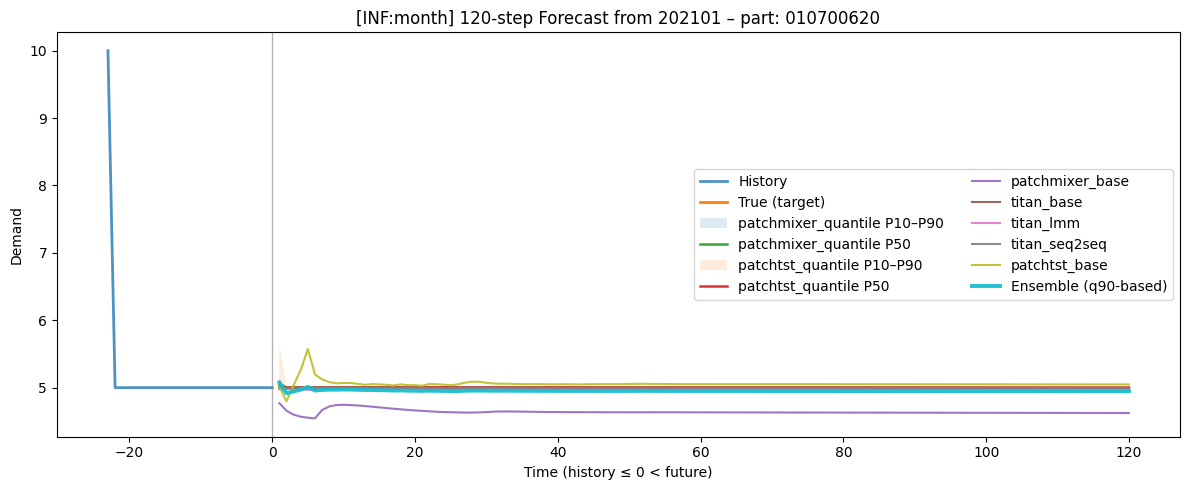

model PatchMixer QuantileModel [DBG] t 0 q10: 4.953146934509277 q50: 5.025362968444824 q90: 5.134415149688721
model PatchMixer QuantileModel [DBG] t 1 q10: 4.99973201751709 q50: 4.999983787536621 q90: 5.000315189361572
model PatchMixer QuantileModel [DBG] t 2 q10: 4.999342918395996 q50: 4.999907493591309 q90: 5.001328468322754
model PatchMixer QuantileModel [DBG] t 3 q10: 4.999382495880127 q50: 4.999746799468994 q90: 5.000030994415283
model PatchMixer QuantileModel [DBG] t 4 q10: 4.999663352966309 q50: 5.000047206878662 q90: 5.000419616699219
model PatchTST QuantileModel [DBG] t 0 q10: 5.04067325592041 q50: 5.053194522857666 q90: 5.65761137008667
model PatchTST QuantileModel [DBG] t 1 q10: 5.000319004058838 q50: 5.000910758972168 q90: 5.005704879760742
model PatchTST QuantileModel [DBG] t 2 q10: 5.000062465667725 q50: 5.0016679763793945 q90: 5.005777359008789
model PatchTST QuantileModel [DBG] t 3 q10: 4.9997477531433105 q50: 5.000561714172363 q90: 5.005996227264404
model PatchTST Quan

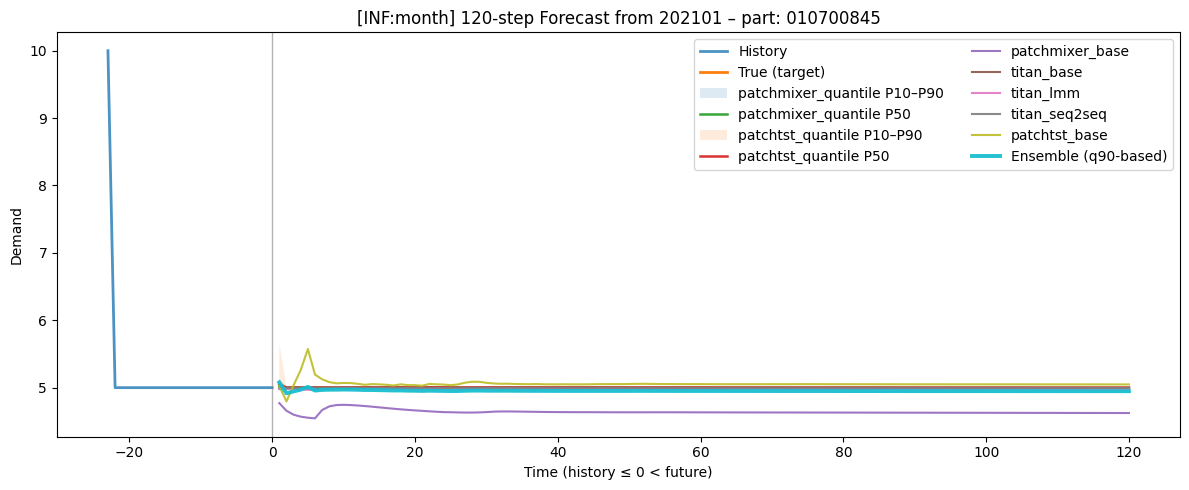

model PatchMixer QuantileModel [DBG] t 0 q10: 19.99924659729004 q50: 19.999420166015625 q90: 19.999738693237305
model PatchMixer QuantileModel [DBG] t 1 q10: 19.99920654296875 q50: 19.999380111694336 q90: 19.999704360961914
model PatchMixer QuantileModel [DBG] t 2 q10: 19.999168395996094 q50: 19.999359130859375 q90: 19.999717712402344
model PatchMixer QuantileModel [DBG] t 3 q10: 19.999122619628906 q50: 19.99929428100586 q90: 19.999746322631836
model PatchMixer QuantileModel [DBG] t 4 q10: 19.999088287353516 q50: 19.999277114868164 q90: 19.999698638916016
model PatchTST QuantileModel [DBG] t 0 q10: 19.99915885925293 q50: 19.99957847595215 q90: 20.001474380493164
model PatchTST QuantileModel [DBG] t 1 q10: 19.999128341674805 q50: 19.999568939208984 q90: 20.001474380493164
model PatchTST QuantileModel [DBG] t 2 q10: 19.999113082885742 q50: 19.99953842163086 q90: 20.00146484375
model PatchTST QuantileModel [DBG] t 3 q10: 19.999103546142578 q50: 19.999544143676758 q90: 20.001441955566406
m

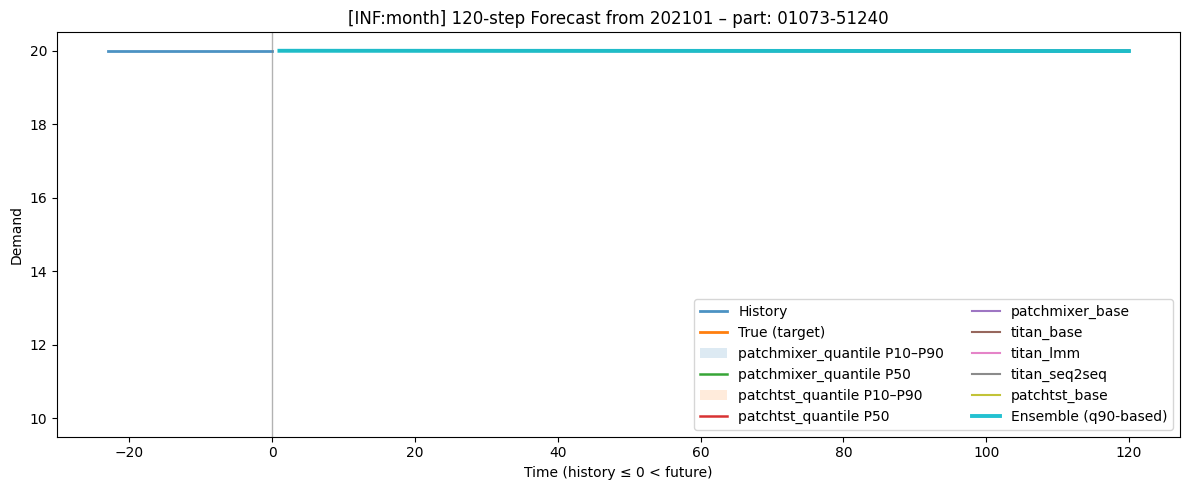

model PatchMixer QuantileModel [DBG] t 0 q10: 0.3549346923828125 q50: 5.804793357849121 q90: 36.52703857421875
model PatchMixer QuantileModel [DBG] t 1 q10: 1.249410629272461 q50: 6.794037818908691 q90: 33.72957229614258
model PatchMixer QuantileModel [DBG] t 2 q10: 0.4339427947998047 q50: 7.553022861480713 q90: 39.75889587402344
model PatchMixer QuantileModel [DBG] t 3 q10: 0.28234195709228516 q50: 8.172510147094727 q90: 44.51011657714844
model PatchMixer QuantileModel [DBG] t 4 q10: 0.3327932357788086 q50: 10.55026626586914 q90: 47.673011779785156
model PatchTST QuantileModel [DBG] t 0 q10: 13.702654838562012 q50: 14.139159202575684 q90: 17.324831008911133
model PatchTST QuantileModel [DBG] t 1 q10: 14.1210355758667 q50: 15.385937690734863 q90: 17.66750144958496
model PatchTST QuantileModel [DBG] t 2 q10: 14.756963729858398 q50: 15.653868675231934 q90: 17.912616729736328
model PatchTST QuantileModel [DBG] t 3 q10: 15.12047290802002 q50: 16.5047550201416 q90: 18.513731002807617
model 

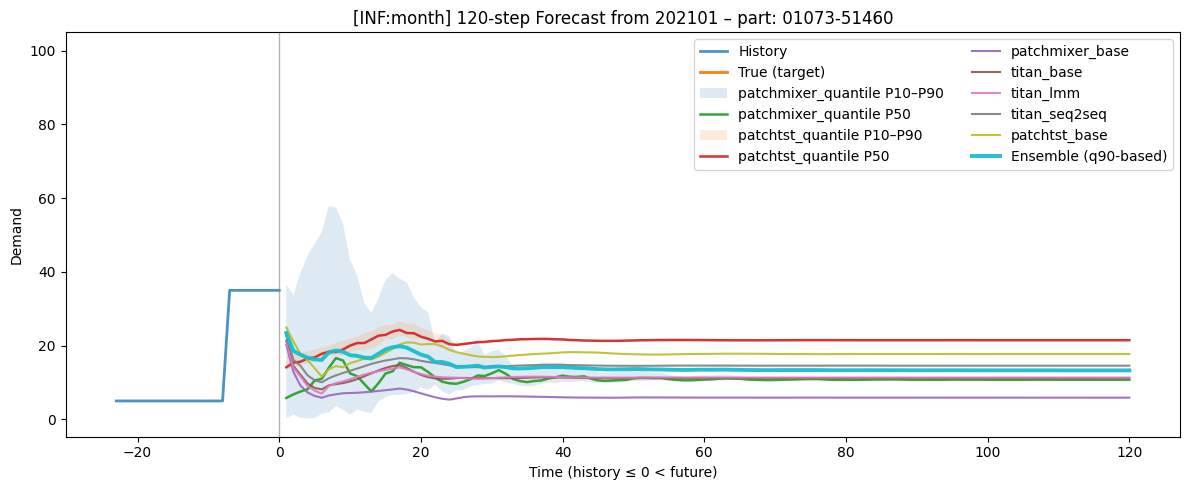

In [7]:

plot_utils.plot_anchored_forecasts_many(
    loaded,
    inference_loader,
    device=device,
    plan_dt=plan_yyyymm,
    time_granularity="month",   # 또는 "week"
    horizon=120,
    max_plots=100,
    show=True,
    future_exo_cb=calendar_cb,
    truth_cb=truth_cb           # 위에서 만든 콜백
)